<a href="https://colab.research.google.com/github/Annettteee/annette-colab-projects/blob/main/Predicting_Architecture_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re, time, csv
from pathlib import Path
from urllib.parse import urljoin, urlparse
import requests
from bs4 import BeautifulSoup

BASE = "https://buildingsdb.com/"
HEADERS = {
    "User-Agent": "AnnetteCapstoneBot/1.0 (academic research; contact: your_email@example.com)"
}
SESSION = requests.Session()
SESSION.headers.update(HEADERS)

OUT_DIR = Path("data_html"); OUT_DIR.mkdir(exist_ok=True, parents=True)

def get(url, sleep=1.0):
    """GET with basic retry + polite delay."""
    time.sleep(sleep)
    for attempt in range(3):
        r = SESSION.get(url, timeout=20)
        if r.ok: return r
        time.sleep(2*(attempt+1))
    r.raise_for_status()

def parse_state_links(home_html):
    """From homepage, gather state index URLs like /GA/, /NY/ ..."""
    soup = BeautifulSoup(home_html, "html.parser")
    links = []
    for a in soup.find_all("a", href=True):
        href = a["href"]
        # state pages are like https://buildingsdb.com/GA/
        if re.fullmatch(r"https?://buildingsdb\.com/[A-Z]{2}/", urljoin(BASE, href)):
            links.append(urljoin(BASE, href))
    return sorted(set(links))

def extract_building_links(state_url):
    """Collect building detail URLs from a state page by finding city/building paths."""
    res = get(state_url)
    soup = BeautifulSoup(res.text, "html.parser")
    bldg_urls = set()
    for a in soup.find_all("a", href=True):
        url = urljoin(state_url, a["href"])
        parsed = urlparse(url)
        # Expect /STATE/city/slug/ (at least 4 segments)
        segments = [s for s in parsed.path.split("/") if s]
        if len(segments) >= 3 and re.fullmatch(r"[A-Z]{2}", segments[0]):
            bldg_urls.add(url)
    return sorted(bldg_urls)

def scrape_building(burl):
    """Parse a building page and extract structured facts with multiple fallback strategies."""
    res = get(burl, sleep=0.8)
    OUT_DIR.joinpath(f"{re.sub(r'[^a-zA-Z0-9]+','_', burl)}.html").write_text(res.text, encoding="utf-8")
    soup = BeautifulSoup(res.text, "html.parser")

    def textnorm(s):
        return re.sub(r"\s+", " ", s or "").strip()

    data = {
        "source_url": burl,
        "name": None, "state": None, "city": None,
        "architect_firm": None, "year_completed": None,
        "typology": None, "main_use": None, "style": None,
        "height_ft": None, "floors": None, "address": None, "aka_names": None
    }

    # name (usually the main H1)
    h1 = soup.find(["h1","h2"])
    if h1: data["name"] = textnorm(h1.get_text())

    # state & city from URL path
    segs = [s for s in urlparse(burl).path.split("/") if s]
    if len(segs) >= 3:
        data["state"], data["city"] = segs[0], segs[1]

    # quick helpers
    page_text = textnorm(soup.get_text(" | "))

    # heuristic field extractors
    def find_labeled_value(label_patterns):
        for pat in label_patterns:
            m = re.search(pat, page_text, flags=re.IGNORECASE)
            if m:
                return textnorm(m.group(1))
        return None

    data["architect_firm"] = find_labeled_value([
        r"Architect\s*\|\s*([^|]+)",           # "Architect | Rabun Hogan ..."
        r"Architect(?:s)?\s*[:\-]\s*([^|]+)"
    ])

    data["year_completed"] = find_labeled_value([
        r"Year\s*\|\s*([0-9]{4})",
        r"completed(?: in)?\s*([12][0-9]{3})"
    ])

    data["typology"] = find_labeled_value([
        r"Typology\s*\|\s*([^|]+)"
    ])

    data["main_use"] = find_labeled_value([
        r"Main use\s*\|\s*([^|]+)"
    ])

    data["style"] = find_labeled_value([
        r"Style\s*\|\s*([^|]+)",
        r"categorized as an?\s*([A-Za-z\-\s]+)\s*building"
    ])

    # height/floors often appear as "610ft" / "53 floors"
    h = re.search(r"([0-9][0-9,]*)\s*ft", page_text, flags=re.I)
    if h: data["height_ft"] = h.group(1).replace(",", "")
    f = re.search(r"([0-9]{1,3})\s*floors?", page_text, flags=re.I)
    if f: data["floors"] = f.group(1)

    # address / aka names (appear on some detail pages)
    addr = re.search(r"(?:address is|street address is)\s*([^|]+?)(?:\||\.)", page_text, flags=re.I)
    if addr: data["address"] = textnorm(addr.group(1))

    aka = re.search(r"also known.*?as,\s*(.+?)(?:\.\s|$)", page_text, flags=re.I)
    if aka: data["aka_names"] = textnorm(aka.group(1))

    return data

def main(sample_only=True, limit_states=5, limit_buildings_per_state=50, outfile="buildingsdb_sample.csv"):
    home = get(BASE).text
    state_links = parse_state_links(home)
    if sample_only:
        state_links = state_links[:limit_states]

    seen = set()
    rows = []

    for s_url in state_links:
        bldg_links = extract_building_links(s_url)[:limit_buildings_per_state]
        for burl in bldg_links:
            if burl in seen: continue
            seen.add(burl)
            try:
                row = scrape_building(burl)
                rows.append(row)
                print(f"OK: {row.get('name')} | {burl}")
            except Exception as e:
                print(f"ERR: {burl} -> {e}")

    # write CSV
    cols = ["name","state","city","architect_firm","year_completed","typology","main_use",
            "style","height_ft","floors","address","aka_names","source_url"]
    with open(outfile, "w", newline="", encoding="utf-8") as f:
        w = csv.DictWriter(f, fieldnames=cols)
        w.writeheader()
        for r in rows: w.writerow(r)

if __name__ == "__main__":
    # start small; later set sample_only=False for full crawl
    main(sample_only=True)


OK: Regions Center | https://buildingsdb.com/AL/birmingham/regions-center/
OK: RSA Battle House Tower | https://buildingsdb.com/AL/mobile/rsa-battle-house-tower/
OK: Simmons Tower | https://buildingsdb.com/AR/little-rock/simmons-tower/
OK: Chase Tower | https://buildingsdb.com/AZ/phoenix/chase-tower/
OK: 5900 Wilshire Building | https://buildingsdb.com/CA/los-angeles/5900-wilshire-building/
OK: 611 Place Building | https://buildingsdb.com/CA/los-angeles/611-place-building/
OK: 777 Tower | https://buildingsdb.com/CA/los-angeles/777-tower/
OK: Aon Center | https://buildingsdb.com/CA/los-angeles/aon-center/
OK: AT&T Center | https://buildingsdb.com/CA/los-angeles/att-center/
OK: Bank of America Plaza Building | https://buildingsdb.com/CA/los-angeles/bank-of-america-plaza-building/
OK: Bullocks Wilshire Building | https://buildingsdb.com/CA/los-angeles/bullocks-wilshire-building/
OK: Century Plaza Towers | https://buildingsdb.com/CA/los-angeles/century-plaza-towers/
OK: City National Plaza

In [ ]:
"""
Scrape ALL buildings from BuildingsDB into CSV.

What you get per row (best-effort, many fields are optional):
- name, state, city, architect_firm, year_completed, typology, main_use, style,
  height_ft, floors, address, source_url

Usage:
  python scrape_buildingsdb_all.py

Tip:
  Start once, inspect CSV, then rerun (it skips already-seen URLs).
"""

import csv
import re
import time
from pathlib import Path
from urllib.parse import urljoin, urlparse

import requests
from bs4 import BeautifulSoup
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

BASE = "https://buildingsdb.com/"
OUT_DIR = Path("data_buildingsdb")
HTML_DIR = OUT_DIR / "html"
OUT_DIR.mkdir(parents=True, exist_ok=True)
HTML_DIR.mkdir(parents=True, exist_ok=True)
CSV_PATH = OUT_DIR / "buildingsdb_all.csv"

HEADERS = {
    "User-Agent": "AnnetteCapstone/1.0 (academic research; contact: youremail@school.edu)"
}

def make_session():
    s = requests.Session()
    s.headers.update(HEADERS)
    retry = Retry(
        total=5,
        backoff_factor=0.8,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=["GET", "HEAD", "OPTIONS"]
    )
    s.mount("https://", HTTPAdapter(max_retries=retry))
    s.mount("http://", HTTPAdapter(max_retries=retry))
    return s

SESSION = make_session()

def get(url, sleep=0.6):
    # Polite crawling: small delay between requests
    time.sleep(sleep)
    r = SESSION.get(url, timeout=25)
    r.raise_for_status()
    return r

def save_html(url, text):
    safe = re.sub(r"[^a-zA-Z0-9]+", "_", url.strip("/"))
    p = HTML_DIR / f"{safe}.html"
    p.write_text(text, encoding="utf-8")
    return p

def parse_state_links(home_html):
    """Collect state pages like https://buildingsdb.com/NY/ from the homepage."""
    soup = BeautifulSoup(home_html, "html.parser")
    links = []
    for a in soup.find_all("a", href=True):
        href = urljoin(BASE, a["href"])
        # Match /XX/ where XX are uppercase letters (states) — we exclude /US/
        if re.fullmatch(r"https?://buildingsdb\.com/[A-Z]{2}/", href):
            links.append(href)
    return sorted(set(links))

def is_building_url(url):
    """True for /STATE/city/building-slug/ and False for state/city indexes."""
    try:
        parsed = urlparse(url)
        if parsed.netloc != "buildingsdb.com":
            return False
        segs = [s for s in parsed.path.split("/") if s]
        # Expect exactly: STATE / city / slug (3+ segments OK; first must be a 2-letter state)
        return len(segs) >= 3 and re.fullmatch(r"[A-Z]{2}", segs[0])
    except Exception:
        return False

def collect_building_links_from_state(state_url):
    """Find every building link on a given state page."""
    res = get(state_url)
    soup = BeautifulSoup(res.text, "html.parser")
    bldg_urls = set()

    for a in soup.find_all("a", href=True):
        url = urljoin(state_url, a["href"])
        if is_building_url(url):
            bldg_urls.add(url)

    # Save HTML for reproducibility
    save_html(state_url, res.text)
    print(f"[state] {state_url} -> {len(bldg_urls)} building links")
    return sorted(bldg_urls)

# ---------- Field extraction helpers ----------

def _norm(s):
    return re.sub(r"\s+", " ", (s or "").strip())

def extract_from_state_card_text(text):
    """
    A state page's building 'card' text often looks like:
    'GLC Grand Building Architect Rabun Hogan Ota Rasche Architects Year 1992
     Typology Skyscraper Main use Hotel Style Art-deco'

    We try to pull these fields when available.
    """
    t = _norm(text)
    data = {}
    m = re.search(r"Architect\s+(.+?)\s+Year\s+(\d{4})\s+Typology\s+(.+?)\s+Main use\s+(.+?)\s+Style\s+(.+)$", t, flags=re.I)
    if m:
        data["architect_firm"] = _norm(m.group(1))
        data["year_completed"] = _norm(m.group(2))
        data["typology"] = _norm(m.group(3))
        data["main_use"] = _norm(m.group(4))
        data["style"] = _norm(m.group(5))
    else:
        # Try partials
        y = re.search(r"\bYear\s+(\d{4})\b", t, flags=re.I)
        if y: data["year_completed"] = y.group(1)
        arch = re.search(r"\bArchitect\s+(.+?)(?:\s+Year|\s*$)", t, flags=re.I)
        if arch: data["architect_firm"] = _norm(arch.group(1))
        typ = re.search(r"\bTypology\s+([A-Za-z\-\s]+)", t, flags=re.I)
        if typ: data["typology"] = _norm(typ.group(1))
        use = re.search(r"\bMain use\s+([A-Za-z\-\s]+)", t, flags=re.I)
        if use: data["main_use"] = _norm(use.group(1))
        sty = re.search(r"\bStyle\s+([A-Za-z\-\s]+)", t, flags=re.I)
        if sty: data["style"] = _norm(sty.group(1))
    return data

def extract_from_building_page(html, burl):
    """
    Parse a building detail page for name, city/state, architect, year(s), style tags, height, floors, address.
    """
    soup = BeautifulSoup(html, "html.parser")
    data = {
        "source_url": burl,
        "name": None, "state": None, "city": None,
        "architect_firm": None, "year_completed": None,
        "typology": None, "main_use": None, "style": None,
        "height_ft": None, "floors": None, "address": None
    }

    # Name
    h1 = soup.find(["h1", "h2"])
    if h1:
        data["name"] = _norm(h1.get_text())

    # State/City from URL
    segs = [s for s in urlparse(burl).path.split("/") if s]
    if len(segs) >= 3:
        data["state"], data["city"] = segs[0], segs[1]

    page_text = _norm(soup.get_text(" | "))

    # Architect patterns (common on many pages)
    m = re.search(r"designed by\s+([^,|]+)", page_text, flags=re.I)
    if m:
        data["architect_firm"] = _norm(m.group(1))

    # Year from narrative or timeline
    m = re.search(r"built between\s+(\d{4})\s+and\s+(\d{4})", page_text, flags=re.I)
    if m:
        data["year_completed"] = m.group(2)
    else:
        m = re.search(r"built in\s+(\d{4})", page_text, flags=re.I)
        if m:
            data["year_completed"] = m.group(1)
        else:
            m = re.search(r"Construction completed\s+(\d{4})", page_text, flags=re.I)
            if m:
                data["year_completed"] = m.group(1)

    # Style & typology hints from narrative (“Art-deco skyscraper” etc.)
    m = re.search(r"\b([A-Za-z\- ]+)\s+skyscraper\b", page_text, flags=re.I)
    if m:
        data["style"] = _norm(m.group(1))
        data["typology"] = "Skyscraper"

    # Height & floors (best-effort)
    h = re.search(r"([0-9][0-9,]*)\s*ft", page_text, flags=re.I)
    if h: data["height_ft"] = h.group(1).replace(",", "")
    f = re.search(r"([0-9]{1,3})\s+floors?", page_text, flags=re.I)
    if f: data["floors"] = f.group(1)

    # Address (some pages state “Its precise street address is …”)
    addr = re.search(r"(?:precise street address is|address is)\s+([^|\.]+)", page_text, flags=re.I)
    if addr: data["address"] = _norm(addr.group(1))

    return data

def scrape_building(burl):
    """Download and parse a single building page; merge with any info from its state card (if available later)."""
    res = get(burl, sleep=0.5)
    save_html(burl, res.text)
    return extract_from_building_page(res.text, burl)

def merge_dict_priority(a, b):
    """Fill missing fields in 'a' with values from 'b'."""
    out = dict(a)
    for k, v in (b or {}).items():
        if (out.get(k) is None or out.get(k) == "") and v:
            out[k] = v
    return out

def crawl_all():
    # Discover all states
    home = get(BASE).text
    save_html(BASE, home)
    state_links = parse_state_links(home)
    if not state_links:
        raise RuntimeError("No state links found on homepage. Site structure may have changed.")

    seen_urls = set()
    rows = []

    # If CSV exists, load existing URLs to avoid re-scraping on resume
    if CSV_PATH.exists():
        with open(CSV_PATH, newline="", encoding="utf-8") as f:
            for row in csv.DictReader(f):
                if row.get("source_url"):
                    seen_urls.add(row["source_url"])

    for s_url in state_links:
        # Collect building URLs from the state page
        bldg_urls = collect_building_links_from_state(s_url)
        print(f" [discover] {s_url} -> {len(bldg_urls)} buildings")

        # Build a map of state-card facts (name + metadata) keyed by URL
        state_card_facts = {}

        # Build a quick index by scanning anchor text on the state page
        res = get(s_url)
        soup = BeautifulSoup(res.text, "html.parser")
        for a in soup.find_all("a", href=True):
            url = urljoin(s_url, a["href"])
            if url in bldg_urls:
                facts = extract_from_state_card_text(a.get_text(" "))
                if facts:
                    state_card_facts[url] = facts

        # Scrape each building page
        for burl in bldg_urls:
            if burl in seen_urls:
                continue
            try:
                detail = scrape_building(burl)
                merged = merge_dict_priority(detail, state_card_facts.get(burl))
                rows.append(merged)
                seen_urls.add(burl)
                print(f"   ✓ {merged.get('name') or burl}")
            except Exception as e:
                print(f"   ✗ ERROR {burl}: {e}")

        # Write incrementally after each state
        write_csv(rows, append=True)
        rows.clear()

    print("Done. CSV at:", CSV_PATH)

def write_csv(new_rows, append=False):
    cols = ["name","state","city","architect_firm","year_completed","typology","main_use",
            "style","height_ft","floors","address","source_url"]
    mode = "a" if append and CSV_PATH.exists() else "w"
    with open(CSV_PATH, mode, newline="", encoding="utf-8") as f:
        w = csv.DictWriter(f, fieldnames=cols)
        if mode == "w":
            w.writeheader()
        for r in new_rows:
            w.writerow({k: r.get(k, "") for k in cols})

if __name__ == "__main__":
    crawl_all()


[state] https://buildingsdb.com/AL/ -> 2 building links
 [discover] https://buildingsdb.com/AL/ -> 2 buildings
   ✓ Regions Center
   ✓ RSA Battle House Tower
[state] https://buildingsdb.com/AR/ -> 1 building links
 [discover] https://buildingsdb.com/AR/ -> 1 buildings
   ✓ Simmons Tower
[state] https://buildingsdb.com/AZ/ -> 1 building links
 [discover] https://buildingsdb.com/AZ/ -> 1 buildings
   ✓ Chase Tower
[state] https://buildingsdb.com/CA/ -> 72 building links
 [discover] https://buildingsdb.com/CA/ -> 72 buildings
   ✓ 5900 Wilshire Building
   ✓ 611 Place Building
   ✓ 777 Tower
   ✓ Aon Center
   ✓ AT&T Center
   ✓ Bank of America Plaza Building
   ✓ Bullocks Wilshire Building
   ✓ Century Plaza Towers
   ✓ City National Plaza
   ✓ DominguezâWilshire Building
   ✓ E. Clem Wilson Building
   ✓ Eastern Columbia Building
   ✓ Equitable Life Building
   ✓ Figueroa at Wilshire Building
   ✓ FourFortyFour South Flower Building
   ✓ Garfield Building
   ✓ Gas Company Tower
   ✓ 

new website

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Scrape building pages from The Skyscraper Center (CTBUH) starting from user-provided seed URLs.

Usage:
  python scrape_ctbuh_us.py --seeds seeds.txt --out ctbuh_us.csv

seeds.txt can contain lines like:
  https://www.skyscrapercenter.com/company/3393            # company page (Weber Thompson)
  https://www.skyscrapercenter.com/city/new-york-city      # example city page (adjust)
  https://www.skyscrapercenter.com/country/united-states   # country hub (if available)
  https://www.skyscrapercenter.com/buildings?country=US    # explore results (if the site uses this pattern)
  https://www.skyscrapercenter.com/search?q=chicago        # search results (if present)

Notes:
- This script does NOT guess URL patterns; it just follows whatever links are present on seed pages.
- It only fetches pages on the domain `www.skyscrapercenter.com`.
- It extracts fields best-effort with multiple fallbacks and keeps the raw HTML for auditability.
"""

import argparse
import csv
import re
import sys
import time
from pathlib import Path
from urllib.parse import urljoin, urlparse

import requests
from bs4 import BeautifulSoup
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

BASE_HOST = "www.skyscrapercenter.com"
UA = {
    "User-Agent": "Annette-Capstone/1.0 (academic research; contact: your_email@example.edu)"
}

def make_session():
    s = requests.Session()
    s.headers.update(UA)
    retry = Retry(
        total=5,
        backoff_factor=0.8,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=["GET", "HEAD", "OPTIONS"],
        raise_on_status=False,
    )
    s.mount("https://", HTTPAdapter(max_retries=retry))
    s.mount("http://", HTTPAdapter(max_retries=retry))
    return s

SESSION = make_session()

def polite_get(url, sleep=0.8, timeout=25):
    time.sleep(sleep)  # be polite
    r = SESSION.get(url, timeout=timeout)
    r.raise_for_status()
    return r

# ----------------------- Utilities -----------------------

def safe_path(s: str) -> str:
    return re.sub(r"[^a-zA-Z0-9_.-]+", "_", s).strip("_")

def is_same_host(url: str) -> bool:
    try:
        return urlparse(url).netloc.lower() == BASE_HOST
    except Exception:
        return False

def is_building_url(url: str) -> bool:
    # Building pages typically contain "/building/" in the path.
    try:
        u = urlparse(url)
        return u.netloc.lower() == BASE_HOST and "/building/" in u.path
    except Exception:
        return False

def normalize_ws(s: str | None) -> str | None:
    if not s: return None
    s = re.sub(r"\s+", " ", s).strip()
    return s or None

def to_int(s: str | None) -> str | None:
    if not s: return None
    m = re.search(r"-?\d+", s.replace(",", ""))
    return m.group(0) if m else None

def to_float(s: str | None) -> str | None:
    if not s: return None
    m = re.search(r"-?\d+(?:\.\d+)?", s.replace(",", ""))
    return m.group(0) if m else None

# ----------------------- Link discovery -----------------------

def discover_building_links_from_seed(seed_url: str, html: str) -> set[str]:
    """Find building links on a generic seed page (company/city/results/etc.)."""
    soup = BeautifulSoup(html, "html.parser")
    links = set()
    for a in soup.find_all("a", href=True):
        href = a["href"]
        abs_url = urljoin(seed_url, href)
        if is_building_url(abs_url):
            links.add(abs_url)
    return links

# ----------------------- Building parsing -----------------------

def parse_building_page(url: str, html: str) -> dict:
    """
    Extracts fields best-effort from a building page.
    We try multiple strategies because CTBUH pages vary by template.
    """
    soup = BeautifulSoup(html, "html.parser")
    text_all = normalize_ws(soup.get_text(" | "))

    data = {
        "source": "ctbuh",
        "source_url": url,
        "name": None,
        "country": None,
        "state": None,
        "city": None,
        "year_completed": None,
        "height_m": None,
        "height_ft": None,
        "floors": None,
        "function": None,
        "material": None,
        "architect_firm": None,
        "developer": None,
        "contractor": None,
        "structural_engineer": None,
        "mep_engineer": None,
        "latitude": None,
        "longitude": None,
    }

    # --- Name (H1/H2) ---
    h = soup.find(["h1", "h2"])
    if h:
        data["name"] = normalize_ws(h.get_text())

    # --- Location block (breadcrumbs or labeled fields) ---
    # Many pages have breadcrumbs like Country > City, sometimes state is shown in parentheses.
    # Try some label-based extraction too.
    # Country / City:
    # Heuristic: look for a table or info block with "City", "Country", sometimes "Location"
    labels = {
        "city": r"(?:\bCity\b|\blocation\b).*?:\s*([^|]+?)(?:\||$)",
        "country": r"(?:\bCountry\b).*?:\s*([^|]+?)(?:\||$)",
    }
    for key, pat in labels.items():
        m = re.search(pat, text_all, flags=re.I)
        if m:
            data[key] = normalize_ws(m.group(1))

    # Try to parse "City, State, Country" in a single line if present
    if not data["country"] or not data["city"]:
        m = re.search(r"\b([A-Za-z .'-]+),\s*([A-Za-z .'-]+),\s*([A-Za-z .'-]+)\b", text_all)
        if m:
            data["city"] = data["city"] or normalize_ws(m.group(1))
            data["state"] = data["state"] or normalize_ws(m.group(2))
            data["country"] = data["country"] or normalize_ws(m.group(3))

    # --- Year completed (various phrasings) ---
    for pat in [
        r"\bCompletion(?: year)?\s*[:|]\s*(\d{4})\b",
        r"\bCompleted(?: in)?\s*(\d{4})\b",
        r"\bYear\s*(\d{4})\b",
    ]:
        m = re.search(pat, text_all, flags=re.I)
        if m:
            data["year_completed"] = m.group(1)
            break

    # --- Height (m/ft) ---
    # Look for patterns like "xxx m / yyy ft"
    m = re.search(r"\b(\d{2,4}(?:\.\d+)?)\s*m\s*/\s*(\d{2,4}(?:\.\d+)?)\s*ft\b", text_all, flags=re.I)
    if m:
        data["height_m"] = m.group(1)
        data["height_ft"] = m.group(2)
    else:
        # Fallback: find "Height: xxx m" or "xxx ft"
        m1 = re.search(r"\bHeight\b[^0-9]*(\d{2,4}(?:\.\d+)?)\s*m\b", text_all, flags=re.I)
        m2 = re.search(r"\bHeight\b[^0-9]*(\d{2,4}(?:\.\d+)?)\s*ft\b", text_all, flags=re.I)
        if m1: data["height_m"] = m1.group(1)
        if m2: data["height_ft"] = m2.group(1)

    # --- Floors ---
    m = re.search(r"\b(\d{1,3})\s+floors?\b", text_all, flags=re.I)
    if m: data["floors"] = m.group(1)

    # --- Function / material (label-based heuristics) ---
    m = re.search(r"\bFunction\b\s*[:|]\s*([^|]+)", text_all, flags=re.I)
    if m: data["function"] = normalize_ws(m.group(1))
    m = re.search(r"\bMaterial\b\s*[:|]\s*([^|]+)", text_all, flags=re.I)
    if m: data["material"] = normalize_ws(m.group(1))

    # --- Companies / firms (if listed) ---
    for key, label in [
        ("architect_firm", r"\bArchitect\b\s*[:|]\s*([^|]+)"),
        ("developer", r"\bDeveloper\b\s*[:|]\s*([^|]+)"),
        ("contractor", r"\bContractor\b\s*[:|]\s*([^|]+)"),
        ("structural_engineer", r"\bStructural Engineer\b\s*[:|]\s*([^|]+)"),
        ("mep_engineer", r"\bMEP Engineer\b\s*[:|]\s*([^|]+)"),
    ]:
        m = re.search(label, text_all, flags=re.I)
        if m:
            data[key] = normalize_ws(m.group(1))

    # --- Coordinates (if present anywhere) ---
    # Look for patterns like "Latitude: xx.xxxx | Longitude: yy.yyyy" or "(xx.x, yy.y)"
    m = re.search(r"Latitude\s*[:]\s*([+-]?\d+(?:\.\d+)?)\b.*?Longitude\s*[:]\s*([+-]?\d+(?:\.\d+)?)\b", text_all, flags=re.I)
    if m:
        data["latitude"], data["longitude"] = m.group(1), m.group(2)
    else:
        m = re.search(r"\(([+-]?\d+(?:\.\d+)?),\s*([+-]?\d+(?:\.\d+)?)\)", text_all)
        if m:
            data["latitude"], data["longitude"] = m.group(1), m.group(2)

    # Normalize numerics to clean strings
    data["year_completed"] = to_int(data["year_completed"])
    data["floors"] = to_int(data["floors"])
    data["height_m"] = to_float(data["height_m"])
    data["height_ft"] = to_float(data["height_ft"])

    return data

# ----------------------- Main crawling logic -----------------------

def read_seeds(path: Path) -> list[str]:
    seeds = []
    for line in path.read_text(encoding="utf-8").splitlines():
        line = line.strip()
        if not line or line.startswith("#"):
            continue
        seeds.append(line)
    return seeds

def crawl(seeds: list[str], out_csv: Path, out_dir: Path, resume: bool = True):
    out_dir.mkdir(parents=True, exist_ok=True)
    html_dir = out_dir / "html"
    html_dir.mkdir(exist_ok=True)

    # For resuming, collect already-scraped building URLs
    seen_buildings = set()
    if resume and out_csv.exists():
        with out_csv.open(newline="", encoding="utf-8") as f:
            for row in csv.DictReader(f):
                if row.get("source_url"):
                    seen_buildings.add(row["source_url"])

    # CSV setup
    fieldnames = [
        "source","source_url","name","country","state","city",
        "year_completed","height_m","height_ft","floors","function","material",
        "architect_firm","developer","contractor","structural_engineer","mep_engineer",
        "latitude","longitude"
    ]
    mode = "a" if out_csv.exists() else "w"
    out_f = out_csv.open(mode, newline="", encoding="utf-8")
    writer = csv.DictWriter(out_f, fieldnames=fieldnames)
    if mode == "w":
        writer.writeheader()

    try:
        # 1) Gather building links from all seeds
        discovered = set()
        for seed in seeds:
            if not is_same_host(seed):
                print(f"[skip external] {seed}")
                continue
            try:
                r = polite_get(seed)
            except Exception as e:
                print(f"[seed error] {seed}: {e}")
                continue

            seed_html = r.text
            (html_dir / f"seed_{safe_path(seed)}.html").write_text(seed_html, encoding="utf-8")
            links = discover_building_links_from_seed(seed, seed_html)
            print(f"[seed] {seed} -> {len(links)} building links")
            discovered.update(links)

        # 2) Visit each building page
        total = len(discovered)
        print(f"[discover] total unique building links: {total}")

        count = 0
        for burl in sorted(discovered):
            count += 1
            if burl in seen_buildings:
                # already scraped
                continue
            try:
                r = polite_get(burl)
            except Exception as e:
                print(f"[building error] {burl}: {e}")
                continue

            html = r.text
            (html_dir / f"b_{safe_path(burl)}.html").write_text(html, encoding="utf-8")
            data = parse_building_page(burl, html)
            writer.writerow(data)
            out_f.flush()
            print(f"[{count}/{total}] ✓ {data.get('name') or burl}")

    finally:
        out_f.close()

# ----------------------- CLI -----------------------

# Modified main function to run within Colab
def main(seeds_file="seeds.txt", out_csv_file="ctbuh_us.csv", out_dir_name="ctbuh_data", no_resume=False):
    seeds_path = Path(seeds_file)
    out_csv = Path(out_csv_file)
    out_dir = Path(out_dir_name)

    # Create a dummy seeds file if it doesn't exist
    if not seeds_path.exists():
        seeds_path.write_text("https://www.skyscrapercenter.com/city/new-york-city")
        print(f"Created dummy seeds file: {seeds_path}")


    seeds = read_seeds(seeds_path)
    if not seeds:
        print("No seeds provided.", file=sys.stderr)
        sys.exit(1)

    crawl(seeds, out_csv, out_dir, resume=(not no_resume))

if __name__ == "__main__":
    # Start the crawl with default or specified parameters
    main()

Created dummy seeds file: seeds.txt
[seed] https://www.skyscrapercenter.com/city/new-york-city -> 11 building links
[discover] total unique building links: 11
[1/11] ✓ 111 West 57th Street
[2/11] ✓ 3 World Trade Center
[3/11] ✓ 30 Hudson Yards
[4/11] ✓ 432 Park Avenue
[5/11] ✓ Bank of America Tower
[6/11] ✓ Central Park Tower
[7/11] ✓ Empire State Building
[8/11] ✓ JPMorgan Chase World Headquarters
[9/11] ✓ Metropolitan Life Tower
[10/11] ✓ One Vanderbilt Avenue
[11/11] ✓ One World Trade Center


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import csv, re, time, sys
from pathlib import Path
from urllib.parse import urljoin, urlparse

import requests
from bs4 import BeautifulSoup
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

BASE = "https://www.skyscrapercenter.com"
COUNTRY_URL = f"{BASE}/country/united-states"  # entry point for U.S. cities
UA = {"User-Agent": "Annette-Capstone/1.0 (academic research; contact: your_email@school.edu)"}

def session():
    s = requests.Session()
    s.headers.update(UA)
    retry = Retry(total=5, backoff_factor=0.8, status_forcelist=[429,500,502,503,504],
                  allowed_methods=["GET","HEAD","OPTIONS"], raise_on_status=False)
    s.mount("https://", HTTPAdapter(max_retries=retry))
    return s

S = session()

def get(url, sleep=1.0, timeout=25):
    time.sleep(sleep)  # politeness
    r = S.get(url, timeout=timeout)
    r.raise_for_status()
    return r.text

def norm(s):
    if not s: return None
    return re.sub(r"\s+", " ", s).strip()

def to_num(s, kind=int):
    if not s: return None
    m = re.search(r"-?\d+(?:\.\d+)?", s.replace(",", ""))
    if not m: return None
    return m.group(0)

def is_building_url(u):
    try:
        p = urlparse(u)
        return p.netloc.lower() == "www.skyscrapercenter.com" and "/building/" in p.path
    except:
        return False

def safe_name(u):
    return re.sub(r"[^a-zA-Z0-9_.-]+","_",u)[:180]

# ---------------- city discovery ----------------

def get_us_city_urls():
    """Collect all /city/... links from the US country hub."""
    html = get(COUNTRY_URL)
    soup = BeautifulSoup(html, "html.parser")
    cities = set()
    for a in soup.find_all("a", href=True):
        href = a["href"]
        absu = urljoin(COUNTRY_URL, href)
        if urlparse(absu).netloc == "www.skyscrapercenter.com" and "/city/" in urlparse(absu).path:
            cities.add(absu)
    # Fallback: also grab from the global Cities index and filter by “United States” in-row text
    try:
        cities_html = get(f"{BASE}/cities")
        sp = BeautifulSoup(cities_html, "html.parser")
        for row in sp.find_all(["tr","li","div"]):
            txt = row.get_text(" ", strip=True)
            if "United States" in txt:
                for a in row.find_all("a", href=True):
                    cu = urljoin(f"{BASE}/cities", a["href"])
                    if "/city/" in cu:
                        cities.add(cu)
    except Exception:
        pass
    return sorted(cities)

# ------------- building discovery on a city page -------------

def discover_building_links_from_city(city_url):
    html = get(city_url)
    soup = BeautifulSoup(html, "html.parser")
    links = set()
    for a in soup.find_all("a", href=True):
        absu = urljoin(city_url, a["href"])
        if is_building_url(absu):
            links.add(absu)
    return links, html  # return html so we can cache

# ------------- building detail parsing -------------

def parse_building(url, html):
    soup = BeautifulSoup(html, "html.parser")
    whole = norm(soup.get_text(" | "))

    out = {
        "source":"ctbuh","source_url":url,
        "name":None,"country":None,"state":None,"city":None,
        "year_completed":None,"height_m":None,"height_ft":None,"floors":None,
        "function":None,"material":None,
        "architect_firm":None,"developer":None,"contractor":None,
        "structural_engineer":None,"mep_engineer":None,
        "latitude":None,"longitude":None
    }

    # name
    h = soup.find(["h1","h2"])
    if h: out["name"] = norm(h.get_text())

    # location (label heuristics + generic pattern)
    for key, pat in {
        "city": r"\bCity\b\s*[:|]\s*([^|]+)",
        "country": r"\bCountry\b\s*[:|]\s*([^|]+)",
        "state": r"\bState\b\s*[:|]\s*([^|]+)",
    }.items():
        m = re.search(pat, whole, flags=re.I)
        if m: out[key] = norm(m.group(1))

    if not out["city"] or not out["country"]:
        m = re.search(r"\b([A-Za-z .'-]+),\s*([A-Za-z .'-]+),\s*([A-Za-z .'-]+)\b", whole)
        if m:
            out["city"] = out["city"] or norm(m.group(1))
            out["state"] = out["state"] or norm(m.group(2))
            out["country"] = out["country"] or norm(m.group(3))

    # year
    for pat in [r"\bCompletion(?: year)?\s*[:|]\s*(\d{4})\b", r"\bCompleted(?: in)?\s*(\d{4})\b", r"\bYear\s*(\d{4})\b"]:
        m = re.search(pat, whole, flags=re.I)
        if m: out["year_completed"] = to_num(m.group(1)); break

    # height (m / ft)
    m = re.search(r"\b(\d{2,4}(?:\.\d+)?)\s*m\s*/\s*(\d{2,4}(?:\.\d+)?)\s*ft\b", whole, flags=re.I)
    if m:
        out["height_m"], out["height_ft"] = m.group(1), m.group(2)
    else:
        m1 = re.search(r"\bHeight\b[^0-9]*(\d{2,4}(?:\.\d+)?)\s*m\b", whole, flags=re.I)
        m2 = re.search(r"\bHeight\b[^0-9]*(\d{2,4}(?:\.\d+)?)\s*ft\b", whole, flags=re.I)
        if m1: out["height_m"] = m1.group(1)
        if m2: out["height_ft"] = m2.group(1)

    # floors
    m = re.search(r"\b(\d{1,3})\s+floors?\b", whole, flags=re.I)
    if m: out["floors"] = to_num(m.group(0))

    # function/material
    m = re.search(r"\bFunction\b\s*[:|]\s*([^|]+)", whole, flags=re.I)
    if m: out["function"] = norm(m.group(1))
    m = re.search(r"\bMaterial\b\s*[:|]\s*([^|]+)", whole, flags=re.I)
    if m: out["material"] = norm(m.group(1))

    # firms
    for key, lab in [
        ("architect_firm", r"\bArchitect\b\s*[:|]\s*([^|]+)"),
        ("developer", r"\bDeveloper\b\s*[:|]\s*([^|]+)"),
        ("contractor", r"\bContractor\b\s*[:|]\s*([^|]+)"),
        ("structural_engineer", r"\bStructural Engineer\b\s*[:|]\s*([^|]+)"),
        ("mep_engineer", r"\bMEP Engineer\b\s*[:|]\s*([^|]+)"),
    ]:
        m = re.search(lab, whole, flags=re.I)
        if m: out[key] = norm(m.group(1))

    # coords
    m = re.search(r"Latitude\s*:\s*([+-]?\d+(?:\.\d+)?)\b.*?Longitude\s*:\s*([+-]?\d+(?:\.\d+)?)\b", whole, flags=re.I)
    if m:
        out["latitude"], out["longitude"] = m.group(1), m.group(2)

    return out

def write_row(writer, row): writer.writerow(row)

def main():
    out_csv = Path("ctbuh_us_all.csv")
    html_dir = Path("ctbuh_us_html"); html_dir.mkdir(exist_ok=True)

    # resume support
    done = set()
    if out_csv.exists():
        with out_csv.open() as f:
            for r in csv.DictReader(f):
                if r.get("source_url"):
                    done.add(r["source_url"])

    fieldnames = ["source","source_url","name","country","state","city",
                  "year_completed","height_m","height_ft","floors","function","material",
                  "architect_firm","developer","contractor","structural_engineer","mep_engineer",
                  "latitude","longitude"]
    mode = "a" if out_csv.exists() else "w"
    f = out_csv.open(mode, newline="", encoding="utf-8")
    w = csv.DictWriter(f, fieldnames=fieldnames)
    if mode == "w": w.writeheader()

    try:
        # 1) discover U.S. cities
        cities = get_us_city_urls()
        print(f"[cities] discovered {len(cities)} U.S. city URLs")

        # 2) collect building links from every city page
        bset = set()
        for i, c in enumerate(cities, 1):
            try:
                links, city_html = discover_building_links_from_city(c)
                (html_dir / f"city_{safe_name(c)}.html").write_text(city_html, encoding="utf-8")
                bset.update(links)
                print(f"[{i}/{len(cities)}] {c} -> {len(links)} building links (total {len(bset)})")
            except Exception as e:
                print(f"[city error] {c}: {e}")

        # 3) visit each building page
        for j, burl in enumerate(sorted(bset), 1):
            if burl in done: continue
            try:
                bh = get(burl)
                (html_dir / f"b_{safe_name(burl)}.html").write_text(bh, encoding="utf-8")
                row = parse_building(burl, bh)
                # keep U.S.-only rows (in case cities list included non-US)
                if (row.get("country") or "").lower() not in ("united states","usa","u.s.","us"):
                    # try to infer from city URL parent
                    if "/country/united-states" not in COUNTRY_URL:
                        continue
                write_row(w, row); f.flush()
                if j % 50 == 0: print(f"[buildings] wrote {j}/{len(bset)}")
            except Exception as e:
                print(f"[building error] {burl}: {e}")

    finally:
        f.close()

if __name__ == "__main__":
    main()


[cities] discovered 396 U.S. city URLs
[1/396] https://www.skyscrapercenter.com/city/abu-dhabi -> 11 building links (total 11)
[2/396] https://www.skyscrapercenter.com/city/addis-ababa -> 6 building links (total 17)
[3/396] https://www.skyscrapercenter.com/city/ajman -> 10 building links (total 27)
[4/396] https://www.skyscrapercenter.com/city/al-khobar -> 5 building links (total 32)
[5/396] https://www.skyscrapercenter.com/city/albany -> 10 building links (total 42)
[6/396] https://www.skyscrapercenter.com/city/algiers -> 2 building links (total 44)
[7/396] https://www.skyscrapercenter.com/city/almaty -> 10 building links (total 54)
[8/396] https://www.skyscrapercenter.com/city/amman -> 8 building links (total 62)
[9/396] https://www.skyscrapercenter.com/city/ampang-jaya -> 10 building links (total 72)
[10/396] https://www.skyscrapercenter.com/city/amsterdam -> 10 building links (total 82)
[11/396] https://www.skyscrapercenter.com/city/ankara -> 10 building links (total 92)
[12/396] h

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
World-scale scraper for The Skyscraper Center (CTBUH).

- Start from any mix of seed pages (country, city, company, explore/search).
- Discover all building links (/building/...) on those pages.
- Visit each building page and extract normalized labeled fields from facts boxes/tables (DOM-first).
- Save raw HTML for reproducibility.
- Write a wide CSV: stable core columns + any extra labeled fields we find.

USAGE:
  python scrape_skyscrapercenter_world.py --seeds seeds.txt --out ctbuh_world.csv --outdir ctbuh_world_html

seeds.txt example (one per line, add many to scale up):
  https://www.skyscrapercenter.com/countries        # global countries index (if accessible)
  https://www.skyscrapercenter.com/city/new-york-city
  https://www.skyscrapercenter.com/city/chicago
  https://www.skyscrapercenter.com/country/united-states
  https://www.skyscrapercenter.com/company/3393
  https://www.skyscrapercenter.com/buildings        # explore list (if present)
  https://www.skyscrapercenter.com/search?q=Tower   # search results (optional)

Politeness:
- Keep request delays (>= 0.8–1.2s).
- Use a clear academic UA string.
- Do NOT download or redistribute images.
"""

import argparse, csv, re, sys, time
from pathlib import Path
from urllib.parse import urljoin, urlparse

import requests
from bs4 import BeautifulSoup
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

BASE_HOST = "www.skyscrapercenter.com"
BASE = f"https://{BASE_HOST}"
UA = {"User-Agent": "Annette-Capstone/1.0 (academic research; contact: your_email@example.edu)"}

# --------- HTTP session with retry ----------
def make_session():
    s = requests.Session()
    s.headers.update(UA)
    retry = Retry(
        total=5,
        backoff_factor=0.8,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=["GET", "HEAD", "OPTIONS"],
        raise_on_status=False,
    )
    s.mount("https://", HTTPAdapter(max_retries=retry))
    s.mount("http://", HTTPAdapter(max_retries=retry))
    return s

S = make_session()

def polite_get(url, sleep=1.0, timeout=25):
    time.sleep(sleep)
    r = S.get(url, timeout=timeout)
    r.raise_for_status()
    # best-effort encoding normalization
    if not r.encoding or r.encoding.lower() in ("iso-8859-1","latin-1"):
        r.encoding = "utf-8"
    return r

# --------- Helpers ----------
def norm(s):
    if not s: return None
    s = re.sub(r"\s+", " ", s).strip()
    return s or None

def safe_name(url):
    return re.sub(r"[^a-zA-Z0-9_.-]+", "_", url)[:180]

def is_same_host(url):
    try:
        return urlparse(url).netloc.lower() == BASE_HOST
    except:
        return False

def is_building_url(url):
    try:
        u = urlparse(url)
        return u.netloc.lower() == BASE_HOST and "/building/" in u.path
    except:
        return False

# --------- Discovery ----------
def discover_building_links(seed_url, html):
    soup = BeautifulSoup(html, "lxml")
    links = set()
    for a in soup.find_all("a", href=True):
        href = a["href"]
        absu = urljoin(seed_url, a["href"])
        if is_building_url(absu):
            links.add(absu)
    return links

# --------- Parsing labeled facts ----------
# We’ll build a generic (label -> value) extractor that walks common HTML patterns used for fact panels:
# - <table> with <th>/<td> or <td class="label">/<td class="value">
# - definition lists <dl><dt>Label</dt><dd>Value</dd>
# - info blocks with "label: value"

CANON_MAP = {
    # canonical_name: [regex patterns for labels we expect]
    "name":          [r"^name$"],
    "status":        [r"^status$"],
    "city":          [r"^city$"],
    "state":         [r"^state|province|region$"],
    "country":       [r"^country$"],
    "location":      [r"^location$"],
    "completion_year":[r"^completion(?: year)?$","^completed$","^year$"],
    "start_year":    [r"^start(?:ed)?(?: year)?$","^start of construction$"],
    "height_arch_m": [r"^height.*architectural.*m","^height.*arch.*m"],
    "height_arch_ft":[r"^height.*architectural.*ft","^height.*arch.*ft"],
    "height_tip_m":  [r"^height.*tip.*m"],
    "height_tip_ft": [r"^height.*tip.*ft"],
    "height_roof_m": [r"^height.*roof.*m"],
    "height_roof_ft":[r"^height.*roof.*ft"],
    "floors_above":  [r"^floors? above ground$","^floors? \(above ground\)$"],
    "floors_below":  [r"^floors? below ground$","^floors? \(below ground\)$"],
    "floors_total":  [r"^floors?$","^storeys?$"],
    "function":      [r"^function$","^primary function$","^building function$"],
    "functions":     [r"^functions$","^mixed use breakdown$"],
    "material":      [r"^material$","^materials?$"],
    "structural_system":[r"^structural system$","^structure$"],
    "architect_firm":[r"^architects?$","^architecture firm$","^design architect$"],
    "owner":         [r"^owner$","^building owner$"],
    "developer":     [r"^developer$"],
    "contractor":    [r"^contractor$","^main contractor$","^general contractor$"],
    "structural_engineer":[r"^structural engineer$","^structural engineering$"],
    "mep_engineer":  [r"^mep engineer$","^services engineer$","^mechanical engineer$"],
    "elevators":     [r"^elevators?$","^lifts?$"],
    "cost":          [r"^cost$","^construction cost$"],
    "aka_names":     [r"^other names$","^also known as$","^aka$"],
    "latitude":      [r"^latitude$"],
    "longitude":     [r"^longitude$"],
}

# compile pattern map
CANON_MAP_COMPILED = {k: [re.compile(p, re.I) for p in v] for k,v in CANON_MAP.items()}

def label_to_canon(label):
    if not label: return None
    lab = norm(label).lower()
    for canon, patterns in CANON_MAP_COMPILED.items():
        for pat in patterns:
            if pat.search(lab):
                return canon
    return None

def clean_value(v):
    v = norm(v)
    if not v: return None
    # remove common tooltip sentences that caused pollution:
    v = re.sub(r"Height is measured from the level of the lowest.*?$", "", v, flags=re.I)
    v = re.sub(r"Other names the building has commonly been known as.*?$", "", v, flags=re.I)
    v = v.strip(" :|")
    return v or None

def extract_kv_from_tables(soup):
    kv = {}
    # table-based
    for tbl in soup.find_all("table"):
        for tr in tbl.find_all("tr"):
            cells = tr.find_all(["th","td"])
            if len(cells) >= 2:
                label = cells[0].get_text(" ", strip=True)
                val   = cells[1].get_text(" ", strip=True)
                canon = label_to_canon(label)
                if canon:
                    kv.setdefault(canon, clean_value(val))
                else:
                    # keep raw label as fallback
                    key = f"extra::{norm(label).lower()}"
                    kv.setdefault(key, clean_value(val))
    return kv

def extract_kv_from_deflists(soup):
    kv = {}
    for dl in soup.find_all("dl"):
        dts = dl.find_all("dt")
        dds = dl.find_all("dd")
        for dt,dd in zip(dts, dds):
            label = dt.get_text(" ", strip=True)
            val   = dd.get_text(" ", strip=True)
            canon = label_to_canon(label)
            if canon:
                kv.setdefault(canon, clean_value(val))
            else:
                key = f"extra::{norm(label).lower()}"
                kv.setdefault(key, clean_value(val))
    return kv

def extract_pairs_by_colon(soup):
    # very light fallback for 'Label: Value' blocks
    kv = {}
    for tag in soup.find_all(["p","li","div","span"]):
        txt = tag.get_text(" ", strip=True)
        if ":" in txt and len(txt) < 200:
            parts = txt.split(":",1)
            label, val = norm(parts[0]), norm(parts[1])
            canon = label_to_canon(label)
            if canon and val:
                kv.setdefault(canon, clean_value(val))
    return kv

def parse_building(url, html):
    soup = BeautifulSoup(html, "lxml")

    # NAME (safe)
    name = None
    h = soup.find(["h1","h2"])
    if h:
        name = norm(h.get_text(" ", strip=True))

    # Merge multiple extraction passes (tables, deflists, colon blocks)
    kv = {}
    for fn in (extract_kv_from_tables, extract_kv_from_deflists, extract_pairs_by_colon):
        try:
            kv.update({k:v for k,v in fn(soup).items() if v})
        except Exception:
            pass

    # Build final record
    rec = {
        "source": "ctbuh",
        "source_url": url,
        "name": name,
        # stable core:
        "country": kv.pop("country", None),
        "state": kv.pop("state", None),
        "city": kv.pop("city", None),
        "status": kv.pop("status", None),
        "year_completed": kv.pop("completion_year", None),
        "start_year": kv.pop("start_year", None),
        "height_arch_m": kv.pop("height_arch_m", None),
        "height_arch_ft": kv.pop("height_arch_ft", None),
        "height_tip_m": kv.pop("height_tip_m", None),
        "height_tip_ft": kv.pop("height_tip_ft", None),
        "height_roof_m": kv.pop("height_roof_m", None),
        "height_roof_ft": kv.pop("height_roof_ft", None),
        "floors_total": kv.pop("floors_total", None),
        "floors_above": kv.pop("floors_above", None),
        "floors_below": kv.pop("floors_below", None),
        "function": kv.pop("function", None),
        "functions": kv.pop("functions", None),
        "material": kv.pop("material", None),
        "structural_system": kv.pop("structural_system", None),
        "architect_firm": kv.pop("architect_firm", None),
        "owner": kv.pop("owner", None),
        "developer": kv.pop("developer", None),
        "contractor": kv.pop("contractor", None),
        "structural_engineer": kv.pop("structural_engineer", None),
        "mep_engineer": kv.pop("mep_engineer", None),
        "elevators": kv.pop("elevators", None),
        "cost": kv.pop("cost", None),
        "aka_names": kv.pop("aka_names", None),
        "latitude": kv.pop("latitude", None),
        "longitude": kv.pop("longitude", None),
    }

    # any other labeled fields we don’t map yet -> keep as extras
    # (this future-proofs your dataset; you can explore columns later)
    for k,v in list(kv.items()):
        if v:
            rec[k] = v

    return rec

# --------- Crawl ----------
def read_seeds(path: Path) -> list[str]:
    seeds = []
    for line in path.read_text(encoding="utf-8").splitlines():
        line = line.strip()
        if not line or line.startswith("#"):
            continue
        seeds.append(line)
    return seeds

def crawl(seeds, out_csv: Path, out_dir: Path, sleep=1.0):
    out_dir.mkdir(parents=True, exist_ok=True)
    html_dir = out_dir / "html"; html_dir.mkdir(exist_ok=True)

    # Resume support (don’t re-scrape finished buildings)
    done = set()
    if out_csv.exists():
        with out_csv.open(newline="", encoding="utf-8") as f:
            for row in csv.DictReader(f):
                if row.get("source_url"):
                    done.add(row["source_url"])

    # First pass: collect all building links
    building_links = set()
    for seed in seeds:
        if not is_same_host(seed):
            print(f"[skip external] {seed}")
            continue
        try:
            r = polite_get(seed, sleep=sleep)
        except Exception as e:
            print(f"[seed error] {seed}: {e}")
            continue
        html = r.text
        (html_dir / f"seed_{safe_name(seed)}.html").write_text(html, encoding="utf-8")
        found = discover_building_links(seed, html)
        building_links |= found
        print(f"[seed] {seed} -> {len(found)} building links (total {len(building_links)})")

    # Second pass: fetch each building
    # We’ll build the CSV header dynamically from union of keys as we go.
    fieldnames = set(["source","source_url","name","country","state","city","status",
                      "year_completed","start_year",
                      "height_arch_m","height_arch_ft","height_tip_m","height_tip_ft",
                      "height_roof_m","height_roof_ft",
                      "floors_total","floors_above","floors_below",
                      "function","functions","material","structural_system",
                      "architect_firm","owner","developer","contractor","structural_engineer",
                      "mep_engineer","elevators","cost","aka_names","latitude","longitude"])

    rows_buffer = []
    def flush(rows):
        nonlocal fieldnames
        # update fieldnames to include any extras
        for r in rows:
            fieldnames |= set(r.keys())
        # write in a stable order: core first, then sorted extras
        core = ["source","source_url","name","country","state","city","status",
                "year_completed","start_year",
                "height_arch_m","height_arch_ft","height_tip_m","height_tip_ft",
                "height_roof_m","height_roof_ft",
                "floors_total","floors_above","floors_below",
                "function","functions","material","structural_system",
                "architect_firm","owner","developer","contractor","structural_engineer",
                "mep_engineer","elevators","cost","aka_names","latitude","longitude"]
        extras = sorted([c for c in fieldnames if c not in core])
        ordered = core + extras

        mode = "a" if out_csv.exists() else "w"
        with out_csv.open(mode, newline="", encoding="utf-8") as f:
            w = csv.DictWriter(f, fieldnames=ordered)
            if mode == "w":
                w.writeheader()
            for r in rows:
                w.writerow({k: r.get(k, "") for k in ordered})

    count = 0
    total = len(building_links)
    for b in sorted(building_links):
        if b in done: continue
        try:
            rb = polite_get(b, sleep=sleep)
            html = rb.text
            (html_dir / f"b_{safe_name(b)}.html").write_text(html, encoding="utf-8")
            rec = parse_building(b, html)
            rows_buffer.append(rec)
            count += 1
            if count % 25 == 0:
                flush(rows_buffer); rows_buffer.clear()
                print(f"[{count}/{total}] wrote 25 rows (running total).")
        except Exception as e:
            print(f"[building error] {b}: {e}")

    if rows_buffer:
        flush(rows_buffer); rows_buffer.clear()
        print(f"[done] wrote remaining rows. Total new: {count}")

# --------- CLI ----------
# Modified main function to run within Colab
def main_colab(seeds_file="seeds.txt", out_csv_file="ctbuh_world.csv", out_dir_name="ctbuh_world_html", sleep_time=1.0):
    seeds_path = Path(seeds_file)
    out_csv = Path(out_csv_file)
    out_dir = Path(out_dir_name)

    # Create a dummy seeds file if it doesn't exist
    if not seeds_path.exists():
        seeds_path.write_text("https://www.skyscrapercenter.com/city/new-york-city")
        print(f"Created dummy seeds file: {seeds_path}")

    seeds = read_seeds(seeds_path)
    if not seeds:
        print("No seeds provided.", file=sys.stderr)
        sys.exit(1)

    crawl(seeds, out_csv, out_dir, sleep=sleep_time)


if __name__ == "__main__":
    # Start the crawl with default or specified parameters
    main_colab()

<>:124: SyntaxWarning: invalid escape sequence '\('
<>:125: SyntaxWarning: invalid escape sequence '\('
<>:124: SyntaxWarning: invalid escape sequence '\('
<>:125: SyntaxWarning: invalid escape sequence '\('
/tmp/ipython-input-60120046.py:124: SyntaxWarning: invalid escape sequence '\('
  "floors_above":  [r"^floors? above ground$","^floors? \(above ground\)$"],
/tmp/ipython-input-60120046.py:125: SyntaxWarning: invalid escape sequence '\('
  "floors_below":  [r"^floors? below ground$","^floors? \(below ground\)$"],


[seed] https://www.skyscrapercenter.com/city/new-york-city -> 11 building links (total 11)
[done] wrote remaining rows. Total new: 11


In [ ]:
if __name__ == "__main__":
    # Start the crawl with default or specified parameters
    main_colab()

[seed] https://www.skyscrapercenter.com/city/new-york-city -> 11 building links (total 11)


In [ ]:
!pip install playwright bs4 requests lxml
!playwright install

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 MB 22.3 MB/s eta 0:00:00
173.7 MiB [] 0% 0.0s173.7 MiB [] 0% 35.9s173.7 MiB [] 0% 23.8s173.7 MiB [] 0% 19.4s173.7 MiB [] 0% 12.9s173.7 MiB [] 0% 9.9s173.7 MiB [] 1% 8.9s173.7 MiB [] 1% 8.1s173.7 MiB [] 1% 7.8s173.7 MiB [] 1% 9.2s173.7 MiB [] 1% 10.1s173.7 MiB [] 1% 11.7s173.7 MiB [] 2% 12.6s173.7 MiB [] 2% 14.0s173.7 MiB [] 2% 14.4s173.7 MiB [] 2% 14.0s173.7 MiB [] 2% 13.3s173.7 MiB [] 2% 13.1s173.7 MiB [] 3% 12.3s173.7 MiB [] 3% 11.4s173.7 MiB [] 3% 10.8s173.7 MiB [] 4% 10.4s173.7 MiB [] 4% 10.3s173.7 MiB [] 4% 10.1s173.7 MiB [] 4% 9.9s173.7 MiB [] 5% 9.6s173.7 MiB [] 5% 9.5s173.7 MiB [] 5% 9.7s173.7 MiB [] 5% 9.8s173.7 MiB [] 5% 9.3s173.7 MiB [] 6% 8.7s173.7 MiB [] 6% 8.8s173.7 MiB [] 6% 8.9s173.7 MiB [] 7% 8.7s173.7 MiB [] 7% 8.3s173.7 MiB [] 8% 7.8s173.7 MiB [] 8% 7.5s173.7 MiB [] 9% 7.5s173.7 MiB [] 9% 7.4s173.7 MiB [] 9% 7.5s173.7 MiB [] 10% 7.4s173.7 MiB [] 10% 7.3s173.7 MiB [] 11% 7.0s173.7 MiB [] 11% 6.7s173.7 MiB [] 12% 6.

In [ ]:
import asyncio

# Run the main function that uses asyncio
await main()

[cities] discovered 396 U.S. city URLs
[1/396] https://www.skyscrapercenter.com/city/abu-dhabi -> 11 building links (total 11)
[2/396] https://www.skyscrapercenter.com/city/addis-ababa -> 6 building links (total 17)
[3/396] https://www.skyscrapercenter.com/city/ajman -> 10 building links (total 27)
[4/396] https://www.skyscrapercenter.com/city/al-khobar -> 5 building links (total 32)
[5/396] https://www.skyscrapercenter.com/city/albany -> 10 building links (total 42)
[6/396] https://www.skyscrapercenter.com/city/algiers -> 2 building links (total 44)
[7/396] https://www.skyscrapercenter.com/city/almaty -> 10 building links (total 54)
[8/396] https://www.skyscrapercenter.com/city/amman -> 8 building links (total 62)
[9/396] https://www.skyscrapercenter.com/city/ampang-jaya -> 10 building links (total 72)
[10/396] https://www.skyscrapercenter.com/city/amsterdam -> 10 building links (total 82)
[11/396] https://www.skyscrapercenter.com/city/ankara -> 10 building links (total 92)
[12/396] h

TypeError: object NoneType can't be used in 'await' expression

In [ ]:
# Create a dummy seeds.txt file if it doesn't exist
seeds_file_path = "seeds.txt"
if not Path(seeds_file_path).exists():
    with open(seeds_file_path, "w") as f:
        f.write("https://www.skyscrapercenter.com/city/new-york-city\n")
        f.write("https://www.skyscrapercenter.com/city/chicago\n")
    print(f"Created dummy seeds file: {seeds_file_path}")
else:
    print(f"Seeds file already exists: {seeds_file_path}")

Seeds file already exists: seeds.txt


In [ ]:
import asyncio

# Run the main function that uses asyncio
await main()

[seed] https://www.skyscrapercenter.com/city/new-york-city -> 0 cumulative links


In [ ]:
# scrape_skyscrapercenter_playwright.py
import asyncio, csv, re, time
from pathlib import Path
from urllib.parse import urljoin, urlparse

import requests
from bs4 import BeautifulSoup
from playwright.async_api import async_playwright
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

BASE_HOST = "www.skyscrapercenter.com"
BASE      = f"https://{BASE_HOST}"
UA_STR    = "Annette-Capstone/1.0 (academic research; contact: darpo24a@mtholyoke.edu)"

# ---------- HTTP (for building pages) ----------
def make_session():
    s = requests.Session()
    s.headers.update({"User-Agent": UA_STR})
    retry = Retry(total=5, backoff_factor=0.8, status_forcelist=[429,500,502,503,504],
                  allowed_methods=["GET","HEAD","OPTIONS"], raise_on_status=False)
    s.mount("https://", HTTPAdapter(max_retries=retry))
    s.mount("http://",  HTTPAdapter(max_retries=retry))
    return s
S = make_session()

def polite_get(url, sleep=0.8, timeout=25):
    time.sleep(sleep)
    r = S.get(url, timeout=timeout)
    r.raise_for_status()
    if not r.encoding or r.encoding.lower() in ("iso-8859-1","latin-1"):
        r.encoding = "utf-8"
    return r

# ---------- helpers ----------
def norm(s):
    if not s: return None
    return re.sub(r"\s+", " ", s).strip()

def is_building_url(u):
    try:
        p = urlparse(u)
        return p.netloc.lower() == BASE_HOST and "/building/" in p.path
    except: return False

def safe(u): return re.sub(r"[^a-zA-Z0-9_.-]+","_",u)[:180]

# label canonicalization (raw strings to avoid warnings)
CANON_MAP = {
    "status":              [r"^status$"],
    "city":                [r"^city$"],
    "state":               [r"^(state|province|region)$"],
    "country":             [r"^country$"],
    "completion_year":     [r"^completion( year)?$", r"^completed$", r"^year$"],
    "start_year":          [r"^start(ed)?( year)?$", r"^start of construction$"],
    "height_arch_m":       [r"^height.*architectural.*m", r"^height.*arch.*m"],
    "height_arch_ft":      [r"^height.*architectural.*ft", r"^height.*arch.*ft"],
    "height_tip_m":        [r"^height.*tip.*m"],
    "height_tip_ft":       [r"^height.*tip.*ft"],
    "height_roof_m":       [r"^height.*roof.*m"],
    "height_roof_ft":      [r"^height.*roof.*ft"],
    "floors_total":        [r"^(floors?|storeys?)$"],
    "floors_above":        [r"^floors? above ground$", r"^floors? \(above ground\)$"],
    "floors_below":        [r"^floors? below ground$", r"^floors? \(below ground\)$"],
    "function":            [r"^(function|primary function|building function)$"],
    "functions":           [r"^(functions|mixed use breakdown)$"],
    "material":            [r"^materials?$"],
    "structural_system":   [r"^(structural system|structure)$"],
    "architect_firm":      [r"^(architects?|architecture firm|design architect)$"],
    "owner":               [r"^owner$"],
    "developer":           [r"^developer$"],
    "contractor":          [r"^(contractor|main contractor|general contractor)$"],
    "structural_engineer": [r"^structural engineer(ing)?$"],
    "mep_engineer":        [r"^(mep engineer|services engineer|mechanical engineer)$"],
    "elevators":           [r"^(elevators?|lifts?)$"],
    "cost":                [r"^(cost|construction cost)$"],
    "aka_names":           [r"^(other names|also known as|aka)$"],
    "latitude":            [r"^latitude$"],
    "longitude":           [r"^longitude$"],
}
CANON_MAP_COMPILED = {k: [re.compile(p, re.I) for p in v] for k,v in CANON_MAP.items()}
def label_to_canon(label):
    lab = norm(label or "").lower()
    for canon, pats in CANON_MAP_COMPILED.items():
        for pat in pats:
            if pat.search(lab): return canon
    return None

TOOLTIP_GARBAGE = [
    r"Height is measured from the level of the lowest.*$",
    r"Other names the building has commonly been known as.*$",
]
def clean_val(v):
    v = norm(v)
    if not v: return None
    for pat in TOOLTIP_GARBAGE:
        v = re.sub(pat, "", v, flags=re.I)
    return v.strip(" :|") or clean_val

def kv_from_tables(soup):
    kv = {}
    for tbl in soup.find_all("table"):
        for tr in tbl.find_all("tr"):
            cells = tr.find_all(["th","td"])
            if len(cells) >= 2:
                label = cells[0].get_text(" ", strip=True)
                val   = cells[1].get_text(" ", strip=True)
                canon = label_to_canon(label)
                if canon and val:
                    kv.setdefault(canon, clean_val(val))
    return kv

def kv_from_deflists(soup):
    kv = {}
    for dl in soup.find_all("dl"):
        dts = dl.find_all("dt")
        dds = dl.find_all("dd")
        for dt,dd in zip(dts, dds):
            canon = label_to_canon(dt.get_text(" ", strip=True))
            if canon:
                kv.setdefault(canon, clean_val(dd.get_text(" ", strip=True)))
    return kv

def parse_building(url, html):
    soup = BeautifulSoup(html, "lxml")
    name = None
    h = soup.find(["h1","h2"])
    if h: name = norm(h.get_text(" ", strip=True))
    kv = {}
    kv.update(kv_from_tables(soup))
    kv.update(kv_from_deflists(soup))
    rec = {
        "source":"ctbuh","source_url":url,"name":name,
        "country":kv.get("country"),"state":kv.get("state"),"city":kv.get("city"),
        "status":kv.get("status"),
        "year_completed":kv.get("completion_year"),"start_year":kv.get("start_year"),
        "height_arch_m":kv.get("height_arch_m"),"height_arch_ft":kv.get("height_arch_ft"),
        "height_tip_m":kv.get("height_tip_m"),"height_tip_ft":kv.get("height_tip_ft"),
        "height_roof_m":kv.get("height_roof_m"),"height_roof_ft":kv.get("height_roof_ft"),
        "floors_total":kv.get("floors_total"),"floors_above":kv.get("floors_above"),"floors_below":kv.get("floors_below"),
        "function":kv.get("function"),"functions":kv.get("functions"),
        "material":kv.get("material"),"structural_system":kv.get("structural_system"),
        "architect_firm":kv.get("architect_firm"),"owner":kv.get("owner"),"developer":kv.get("developer"),
        "contractor":kv.get("contractor"),"structural_engineer":kv.get("structural_engineer"),"mep_engineer":kv.get("mep_engineer"),
        "elevators":kv.get("elevators"),"cost":kv.get("cost"),"aka_names":kv.get("aka_names"),
        "latitude":kv.get("latitude"),"longitude":kv.get("longitude"),
    }
    return rec

# ---------- Playwright discovery (renders + clicks + loads all) ----------
async def discover_building_links_with_browser(seeds, outdir: Path, delay_click=0.4):
    outdir.mkdir(parents=True, exist_ok=True)
    html_dir = outdir / "html"; html_dir.mkdir(exist_ok=True)

    links = set()
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        context = await browser.new_context(user_agent=UA_STR)
        page = await context.new_page()

        for seed in seeds:
            if urlparse(seed).netloc.lower() != BASE_HOST:
                print(f"[skip external] {seed}"); continue
            try:
                await page.goto(seed, wait_until="domcontentloaded")
                await page.wait_for_timeout(600)  # small pause
                # Try clicking a tab named "Buildings" if visible
                try:
                    el = await page.get_by_role("link", name=re.compile(r"^Buildings$", re.I)).first
                    if await el.is_visible():
                        await el.click()
                        await page.wait_for_timeout(600)
                except Exception:
                    pass

                # Keep clicking "Load more" / next pagination buttons if present
                while True:
                    clicked = False
                    for text in ["Load more","Show more","More","Next","›"]:
                        try:
                            btn = await page.get_by_role("button", name=re.compile(text, re.I)).first
                            if await btn.is_visible():
                                await btn.click()
                                await page.wait_for_timeout(int(delay_click*1000))
                                clicked = True
                                break
                        except Exception:
                            pass
                    if not clicked:
                        # also try anchor pagination
                        try:
                            a_next = await page.get_by_role("link", name=re.compile(r"Next|›", re.I)).first
                            if await a_next.is_visible():
                                await a_next.click()
                                await page.wait_for_timeout(int(delay_click*1000))
                                clicked = True
                        except Exception:
                            pass
                    if not clicked:
                        break

                # collect all /building/ links from the rendered DOM
                anchors = await page.locator("a[href]").all()
                for a in anchors:
                    href = await a.get_attribute("href")
                    if not href: continue
                    absu = urljoin(seed, href)
                    if is_building_url(absu):
                        links.add(absu)

                # cache the final DOM
                html = await page.content()
                (html_dir / f"seed_{safe(seed)}.html").write_text(html, encoding="utf-8")
                print(f"[seed] {seed} -> {len([u for u in links if seed in u])} cumulative links")

            except Exception as e:
                print(f"[seed error] {seed}: {e}")

        await browser.close()
    return links

# ---------- main crawl ----------
async def main(seeds_file="seeds.txt", out_csv="ctbuh_world.csv", outdir="ctbuh_world_cache", sleep=0.9):
    seeds = [ln.strip() for ln in Path(seeds_file).read_text(encoding="utf-8").splitlines()
             if ln.strip() and not ln.startswith("#")]

    outdir = Path(outdir); outdir.mkdir(exist_ok=True)
    html_dir = outdir / "buildings"; html_dir.mkdir(exist_ok=True)

    # 1) Discover all building URLs with a browser (JS rendering)
    discovered = await discover_building_links_with_browser(seeds, outdir)

    # 2) Resume: skip already scraped URLs
    done = set()
    out_csv_p = Path(out_csv)
    if out_csv_p.exists():
        with out_csv_p.open(newline="", encoding="utf-8") as f:
            for row in csv.DictReader(f):
                if row.get("source_url"): done.add(row["source_url"])

    # 3) Write header (wide but stable)
    core = ["source","source_url","name","country","state","city","status",
            "year_completed","start_year",
            "height_arch_m","height_arch_ft","height_tip_m","height_tip_ft",
            "height_roof_m","height_roof_ft",
            "floors_total","floors_above","floors_below",
            "function","functions","material","structural_system",
            "architect_firm","owner","developer","contractor","structural_engineer",
            "mep_engineer","elevators","cost","aka_names","latitude","longitude"]
    wmode = "a" if out_csv_p.exists() else "w"
    f = out_csv_p.open(wmode, newline="", encoding="utf-8")
    w = csv.DictWriter(f, fieldnames=core)
    if wmode == "w": w.writeheader()

    # 4) Fetch + parse each building page (requests = faster)
    try:
        total = len(discovered)
        for i, url in enumerate(sorted(discovered), 1):
            if url in done: continue
            try:
                r = polite_get(url, sleep=sleep)
                html = r.text
                (html_dir / f"b_{safe(url)}.html").write_text(html, encoding="utf-8")
                row = parse_building(url, html)
                w.writerow(row); f.flush()
                if i % 50 == 0:
                    print(f"[{i}/{total}] wrote 50…")
            except Exception as e:
                print(f"[building error] {url}: {e}")
    finally:
        f.close()

if __name__ == "__main__":
    # Use await instead of asyncio.run() in Colab
    await main()

[seed] https://www.skyscrapercenter.com/city/new-york-city -> 0 cumulative links


In [ ]:
import asyncio

# Run the main function that uses asyncio
await main()

In [ ]:
# Create a dummy seeds.txt file if it doesn't exist
seeds_file_path = "seeds.txt"
if not Path(seeds_file_path).exists():
    with open(seeds_file_path, "w") as f:
        f.write("https://www.skyscrapercenter.com/city/new-york-city\n")
        f.write("https://www.skyscrapercenter.com/city/chicago\n")
    print(f"Created dummy seeds file: {seeds_file_path}")
else:
    print(f"Seeds file already exists: {seeds_file_path}")

ANALYSIS

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

df = pd.read_csv("/content/tallest_buildings_in_the_world.csv")
df["Height (m)"] = pd.to_numeric(df["Height (m)"], errors="coerce")
df["Floors"] = pd.to_numeric(df["Floors"], errors="coerce")
df["Completion Year"] = pd.to_numeric(df["Completion Year"], errors="coerce")

# Correlation Height vs Floors
mask = df["Height (m)"].notna() & df["Floors"].notna()
r, p = pearsonr(df.loc[mask, "Floors"], df.loc[mask, "Height (m)"])
corr_df = pd.DataFrame({
    "Metric": ["Pearson r", "p-value"],
    "Value": [round(r, 3), "{:.3e}".format(p)]
})

# Country height leaderboard (top 10 by average height, min count >= 5)
country_stats = (
    df.groupby("Country", dropna=False)
      .agg(count=("Height (m)", "count"),
           mean_height_m=("Height (m)", "mean"))
      .query("count >= 5")
      .sort_values("mean_height_m", ascending=False)
      .head(10)
      .round(2)
      .reset_index()
)

# Decade trend in mean height
df["Decade"] = (df["Completion Year"] // 10) * 10
decade_trend = (
    df.groupby("Decade", dropna=False)["Height (m)"]
      .mean()
      .dropna()
      .round(1)
      .reset_index()
      .sort_values("Decade")
)


# Task
The user wants to perform an analysis on the `tallest_buildings_in_the_world.csv` dataset. The analysis will cover:
1.  Data exploration and summary (descriptive statistics, missing values, first few rows).
2.  Visualization of the correlation between building height and the number of floors.
3.  Analysis and visualization of building height trends by country and decade.
4.  Analysis and visualization of building functions and materials.
5.  A comprehensive markdown summary of all key findings.

## Data Exploration and Summary

### Subtask:
Generate descriptive statistics, check for missing values, and display the first few rows of the DataFrame to understand its structure and content.


**Reasoning**:
The subtask requires generating descriptive statistics, checking for missing values, and displaying the first few rows of the DataFrame. These operations can be efficiently performed in a single code block using pandas functions.



In [ ]:
print("First 5 rows of the DataFrame:")
print(df.head())

print("\nDescriptive statistics for numerical columns:")
print(df.describe())

print("\nMissing values per column:")
print(df.isnull().sum())

First 5 rows of the DataFrame:
   Rank                      Name          City               Country  \
0     1              Burj Khalifa         Dubai  United Arab Emirates   
1     2               Merdeka 118  Kuala Lumpur              Malaysia   
2     3            Shanghai Tower      Shanghai                 China   
3     4  Makkah Royal Clock Tower         Mecca          Saudi Arabia   
4     5    Ping An Finance Center      Shenzhen                 China   

   Completion Year  Height (m)  Floors             Material Used  \
0           2010.0         828   163.0       Steel Over Concrete   
1           2023.0         679   118.0  Concrete-Steel Composite   
2           2015.0         632   128.0  Concrete-Steel Composite   
3           2012.0         601   120.0       Steel Over Concrete   
4           2017.0         599   115.0  Concrete-Steel Composite   

                               Function   City Lat    City Lon  Decade  
0          Office / Residential / Hotel  25.0742

## Visualize Height and Floors Correlation

### Subtask:
Create a scatter plot to visualize the relationship between building height and the number of floors, along with a histogram for the distribution of heights.


**Reasoning**:
The subtask requires visualizing the relationship between building height and the number of floors using a scatter plot and displaying the distribution of building heights using a histogram. I will use `matplotlib.pyplot` and `seaborn` for these visualizations as requested.



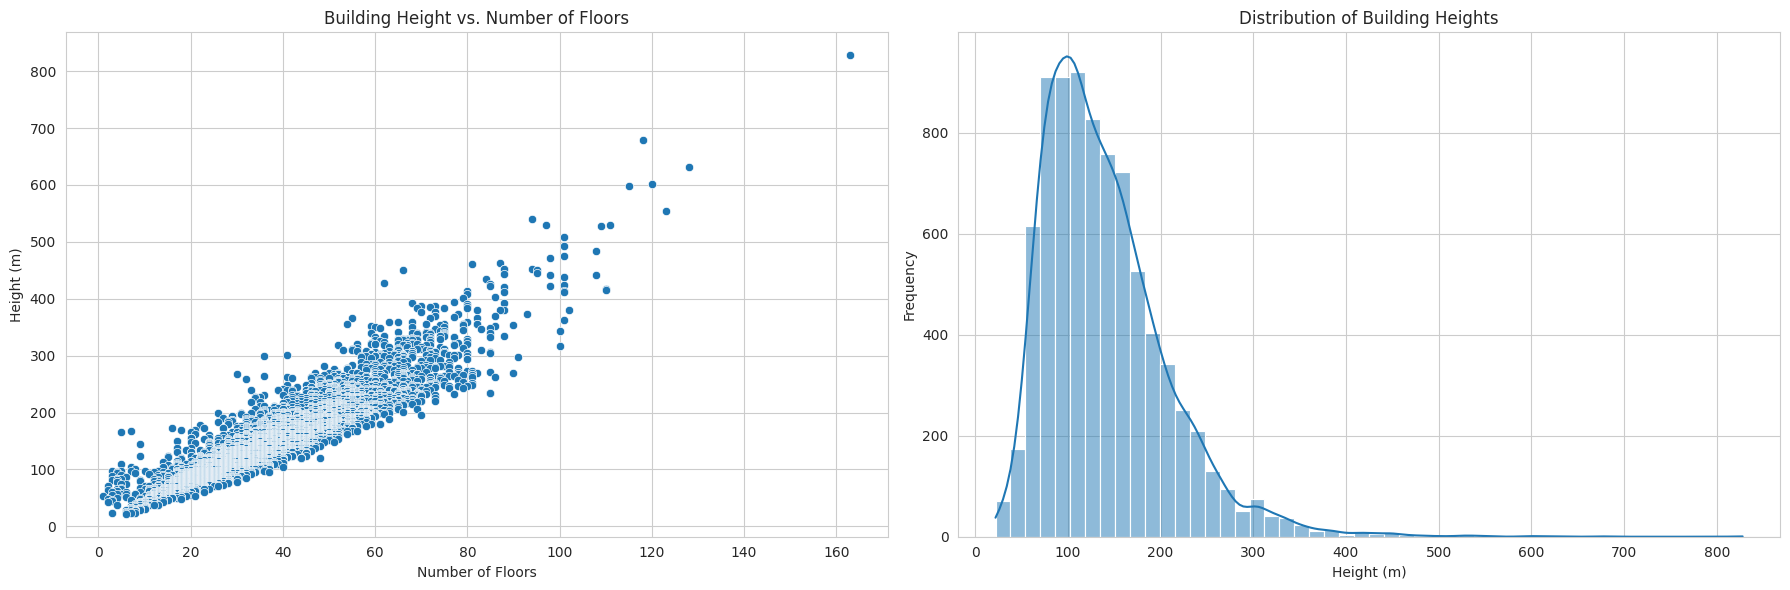

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Scatter plot for Height vs. Floors
sns.scatterplot(data=df, x='Floors', y='Height (m)', ax=axes[0])
axes[0].set_title('Building Height vs. Number of Floors')
axes[0].set_xlabel('Number of Floors')
axes[0].set_ylabel('Height (m)')

# Histogram for Distribution of Heights
sns.histplot(data=df, x='Height (m)', bins=50, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Building Heights')
axes[1].set_xlabel('Height (m)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

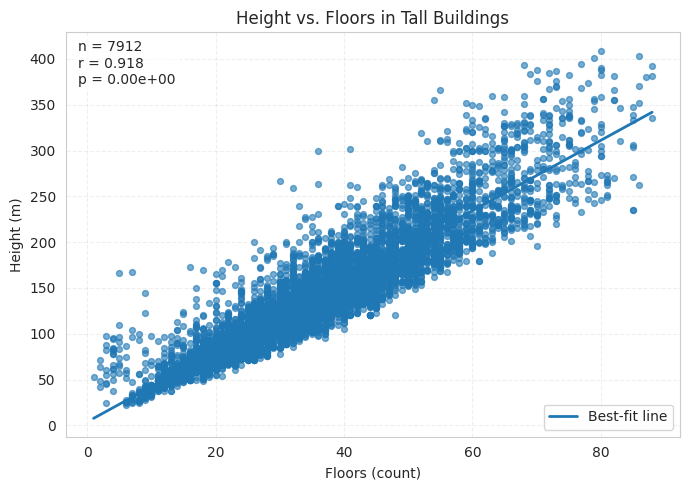

Saved figure to: scatter_height_vs_floors.png


In [ ]:
# Scatterplot: Height (m) vs. Floors with Pearson correlation and best-fit line

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr



# --- CONFIG: set your column names here if they differ ---
COL_HEIGHT = 'Height (m)'
COL_FLOORS = 'Floors'

# Ensure numeric and drop missing
df_scatter = (
    df[[COL_FLOORS, COL_HEIGHT]]
    .apply(pd.to_numeric, errors='coerce')
    .dropna()
)

# Optional: mild outlier trimming (e.g., top 0.5% in each axis)
# Comment this block out if you want raw data only.
q_hi_floors  = df_scatter[COL_FLOORS].quantile(0.995)
q_hi_height  = df_scatter[COL_HEIGHT].quantile(0.995)
df_scatter = df_scatter[
    (df_scatter[COL_FLOORS] <= q_hi_floors) &
    (df_scatter[COL_HEIGHT] <= q_hi_height)
]

# Pearson correlation
r, p = pearsonr(df_scatter[COL_FLOORS], df_scatter[COL_HEIGHT])
n = len(df_scatter)

# Best-fit line (least squares)
x = df_scatter[COL_FLOORS].values
y = df_scatter[COL_HEIGHT].values
m, b = np.polyfit(x, y, 1)
x_line = np.linspace(x.min(), x.max(), 200)
y_line = m * x_line + b

# Plot
plt.figure(figsize=(7, 5))
plt.scatter(x, y, alpha=0.6, s=18)
plt.plot(x_line, y_line, linewidth=2, label='Best-fit line')

# Labels / title / legend
plt.xlabel('Floors (count)')
plt.ylabel('Height (m)')
plt.title('Height vs. Floors in Tall Buildings')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)

# Annotate stats
text = f'n = {n}\nr = {r:.3f}\np = {p:.2e}'
# place annotation in top-left with a small white box
plt.gca().text(0.02, 0.98, text, transform=plt.gca().transAxes,
               va='top', ha='left',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

# Save and show
plt.tight_layout()
plt.savefig('scatter_height_vs_floors.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved figure to: scatter_height_vs_floors.png")


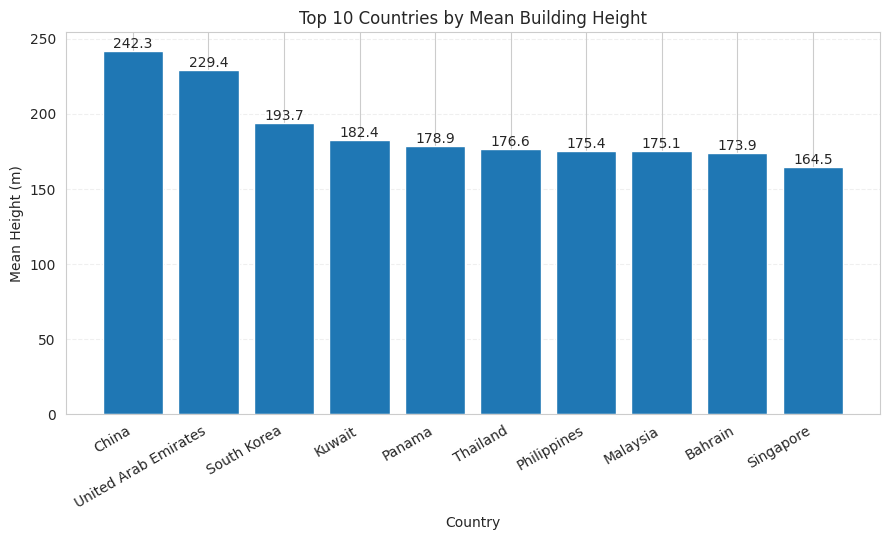

Saved figure to: bar_top10_countries_mean_height.png


In [ ]:
# Bar chart: Top 10 Countries by mean building height (minimum 5 buildings)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- CONFIG: set your column names here if they differ ---
COL_COUNTRY = 'Country'
COL_HEIGHT  = 'Height (m)'

# Clean and aggregate
df_c = df[[COL_COUNTRY, COL_HEIGHT]].copy()
df_c[COL_HEIGHT] = pd.to_numeric(df_c[COL_HEIGHT], errors='coerce')
df_c = df_c.dropna(subset=[COL_COUNTRY, COL_HEIGHT])

# Keep countries with at least 5 buildings
counts = df_c.groupby(COL_COUNTRY)[COL_HEIGHT].count()
valid_countries = counts[counts >= 5].index
df_c = df_c[df_c[COL_COUNTRY].isin(valid_countries)]

# Mean height by country and pick top 10
mean_by_country = (
    df_c.groupby(COL_COUNTRY)[COL_HEIGHT]
        .mean()
        .sort_values(ascending=False)
        .head(10)
)

# Plot
plt.figure(figsize=(9, 5.5))
x = np.arange(len(mean_by_country))
plt.bar(x, mean_by_country.values)
plt.xticks(x, mean_by_country.index, rotation=30, ha='right')

plt.xlabel('Country')
plt.ylabel('Mean Height (m)')
plt.title('Top 10 Countries by Mean Building Height')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Annotate bars
for i, v in enumerate(mean_by_country.values):
    plt.text(i, v, f'{v:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('bar_top10_countries_mean_height.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved figure to: bar_top10_countries_mean_height.png")


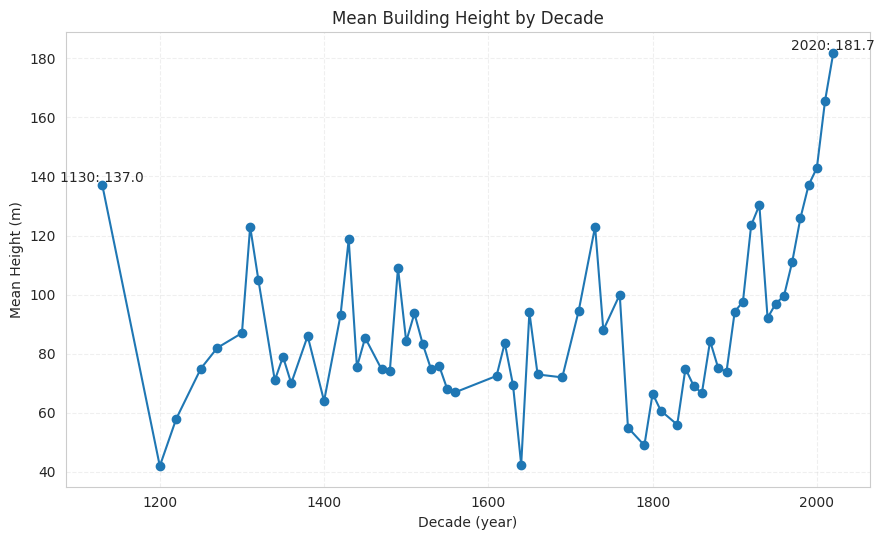

Saved figure to: line_mean_height_by_decade.png


In [ ]:
# Line plot: Mean building height by decade

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- CONFIG: set your column names here if they differ ---
COL_YEAR   = 'Completion Year'
COL_HEIGHT = 'Height (m)'

# Prepare decade column
df_t = df[[COL_YEAR, COL_HEIGHT]].copy()
df_t[COL_YEAR] = pd.to_numeric(df_t[COL_YEAR], errors='coerce')
df_t[COL_HEIGHT] = pd.to_numeric(df_t[COL_HEIGHT], errors='coerce')
df_t = df_t.dropna(subset=[COL_YEAR, COL_HEIGHT])

# Convert to integer years and compute decade
df_t[COL_YEAR] = df_t[COL_YEAR].astype(int)
df_t['Decade'] = (df_t[COL_YEAR] // 10) * 10

# Optional: restrict to modern decades if you want (uncomment)
# df_t = df_t[df_t['Decade'] >= 1900]

# Aggregate mean height per decade
decade_stats = (
    df_t.groupby('Decade')[COL_HEIGHT]
        .mean()
        .sort_index()
)

# Plot
plt.figure(figsize=(9, 5.5))
plt.plot(decade_stats.index, decade_stats.values, marker='o')

plt.xlabel('Decade (year)')
plt.ylabel('Mean Height (m)')
plt.title('Mean Building Height by Decade')
plt.grid(True, linestyle='--', alpha=0.3)

# Annotate some points (first, last, and peak decade)
if len(decade_stats) > 0:
    first_dec = decade_stats.index[0]
    last_dec  = decade_stats.index[-1]
    peak_dec  = decade_stats.idxmax()
    for dec in {first_dec, last_dec, peak_dec}:
        plt.text(dec, decade_stats.loc[dec], f'{dec}: {decade_stats.loc[dec]:.1f}',
                 ha='center', va='bottom')

plt.tight_layout()
plt.savefig('line_mean_height_by_decade.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved figure to: line_mean_height_by_decade.png")


## Analyze Country and Decade Trends

### Subtask:
Visualize the top countries by average building height using a bar chart and plot the trend of mean building height over different decades using a line plot.


**Reasoning**:
The subtask requires visualizing the top countries by average building height using a bar chart and the trend of mean building height over decades using a line plot. I will use `matplotlib.pyplot` and `seaborn` to create these plots with appropriate labels and titles.



/tmp/ipython-input-2817488854.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=country_stats, x='Country', y='mean_height_m', ax=axes[0], palette='viridis')


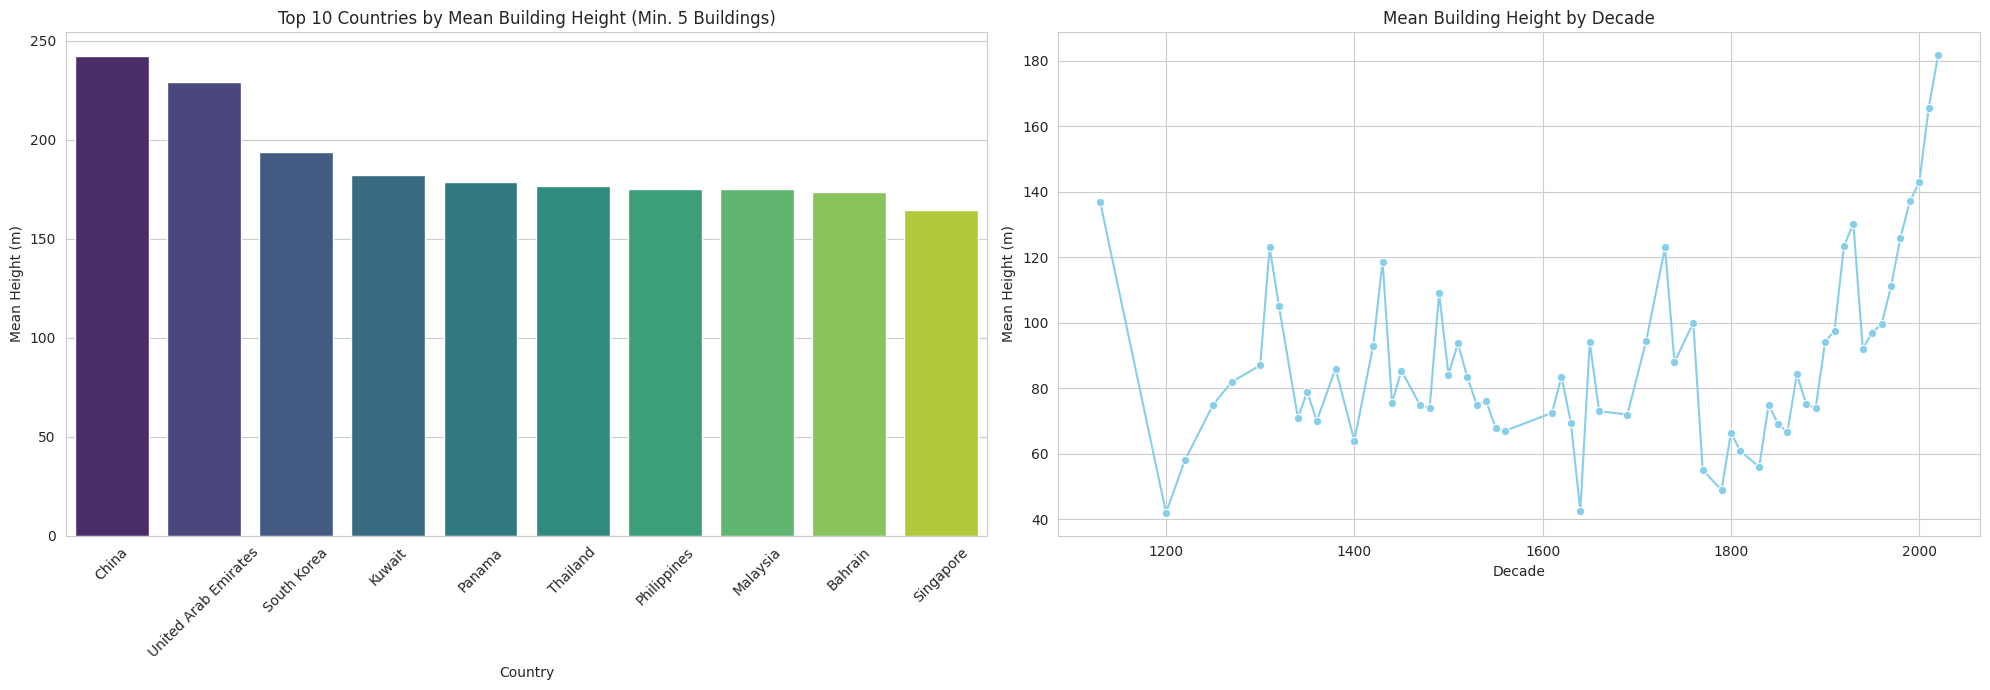

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Bar plot for Top 10 Countries by Mean Building Height
sns.barplot(data=country_stats, x='Country', y='mean_height_m', ax=axes[0], palette='viridis')
axes[0].set_title('Top 10 Countries by Mean Building Height (Min. 5 Buildings)')
axes[0].set_xlabel('Country')
axes[0].set_ylabel('Mean Height (m)')
axes[0].tick_params(axis='x', rotation=45)

# Line plot for Mean Building Height by Decade
sns.lineplot(data=decade_trend, x='Decade', y='Height (m)', ax=axes[1], marker='o', color='skyblue')
axes[1].set_title('Mean Building Height by Decade')
axes[1].set_xlabel('Decade')
axes[1].set_ylabel('Mean Height (m)')
axes[1].grid(True)

plt.tight_layout()
plt.show()

**Reasoning**:
The previous code generated a FutureWarning because the `palette` argument was used without `hue` in `sns.barplot`. To resolve this and ensure future compatibility, I will assign the `x` variable to `hue` and set `legend=False` in the `barplot` call, as suggested by the warning.



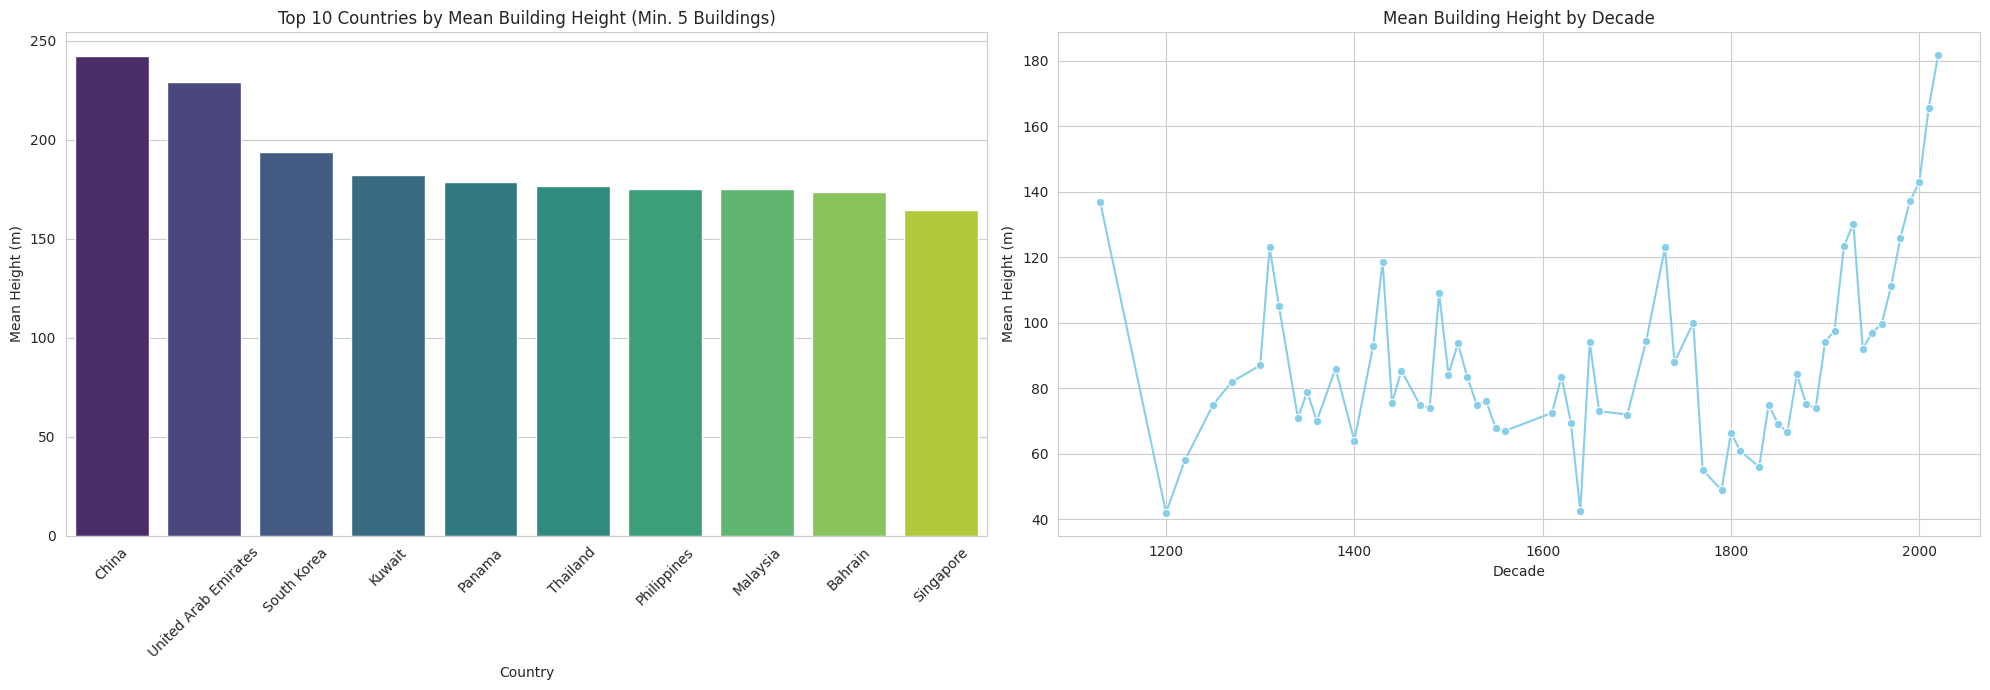

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Bar plot for Top 10 Countries by Mean Building Height
sns.barplot(data=country_stats, x='Country', y='mean_height_m', ax=axes[0], hue='Country', palette='viridis', legend=False)
axes[0].set_title('Top 10 Countries by Mean Building Height (Min. 5 Buildings)')
axes[0].set_xlabel('Country')
axes[0].set_ylabel('Mean Height (m)')
axes[0].tick_params(axis='x', rotation=45)

# Line plot for Mean Building Height by Decade
sns.lineplot(data=decade_trend, x='Decade', y='Height (m)', ax=axes[1], marker='o', color='skyblue')
axes[1].set_title('Mean Building Height by Decade')
axes[1].set_xlabel('Decade')
axes[1].set_ylabel('Mean Height (m)')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Analyze Building Attributes

### Subtask:
Investigate the distribution of building functions and materials using bar charts to identify common types.


**Reasoning**:
First, I'll calculate the frequency of each unique value in the 'Function' and 'Material Used' columns and select the top 10 for each. Then, I will create two bar charts using `seaborn` on separate subplots to visualize these distributions as requested.



**Reasoning**:
The previous code failed with a `ValueError` because `tick_params` does not accept the `ha` (horizontal alignment) argument. It also raised a `FutureWarning` for using `palette` without `hue` in `barplot`. I will fix the `ValueError` by removing `ha='right'` from `tick_params` and address the `FutureWarning` by explicitly setting `hue` to the x-axis variable and `legend=False` in both `sns.barplot` calls.



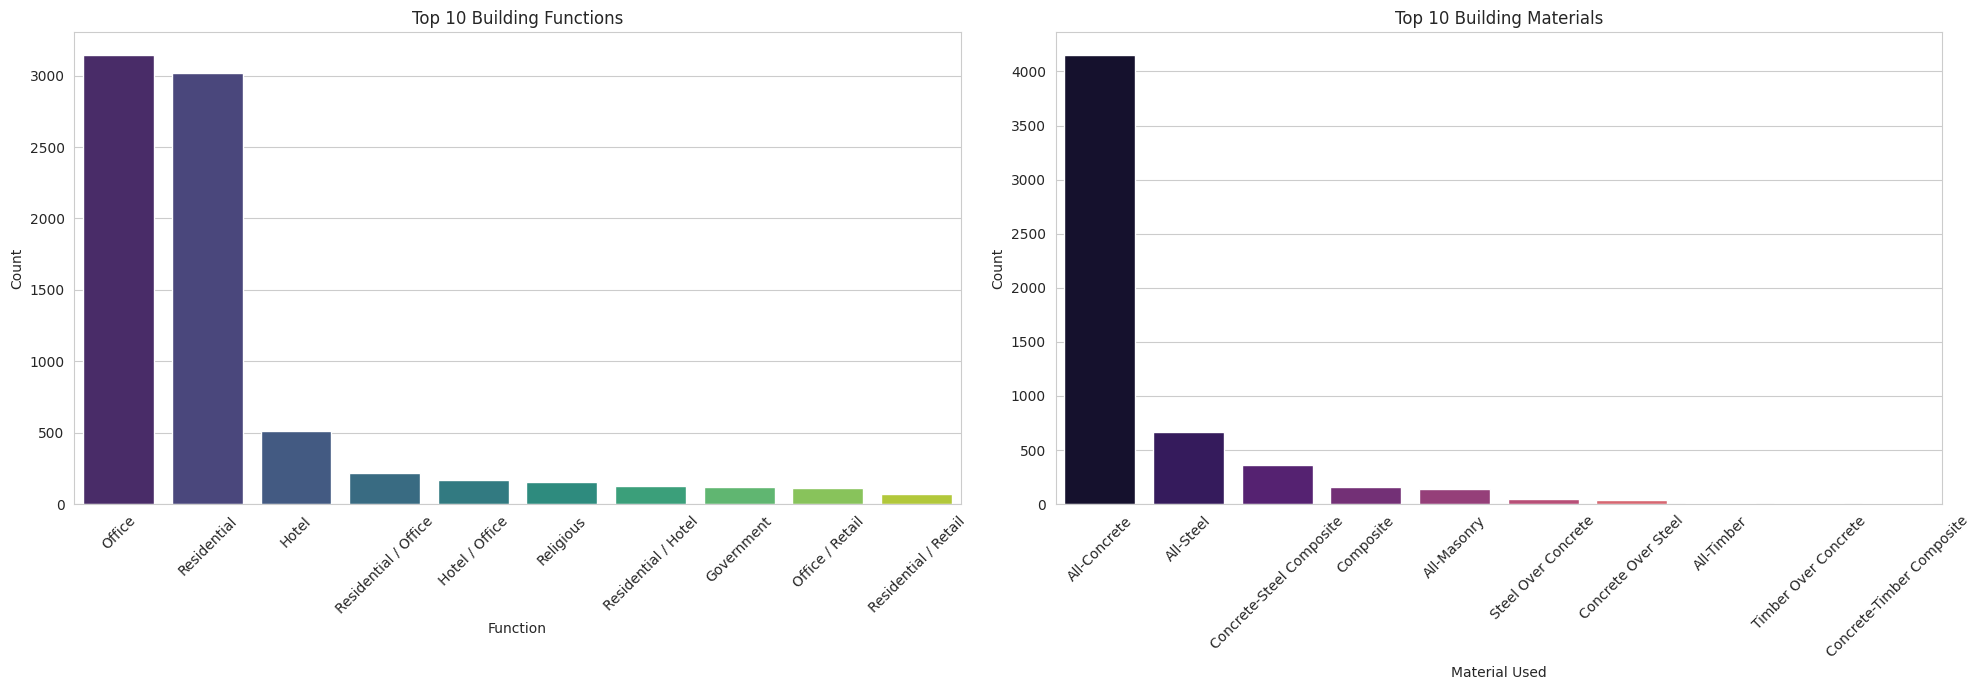

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate frequency of top 10 building functions
top_functions = df['Function'].value_counts().head(10)

# Calculate frequency of top 10 building materials
top_materials = df['Material Used'].value_counts().head(10)

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Bar plot for Top 10 Building Functions
sns.barplot(x=top_functions.index, y=top_functions.values, ax=axes[0], hue=top_functions.index, palette='viridis', legend=False)
axes[0].set_title('Top 10 Building Functions')
axes[0].set_xlabel('Function')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Bar plot for Top 10 Building Materials
sns.barplot(x=top_materials.index, y=top_materials.values, ax=axes[1], hue=top_materials.index, palette='magma', legend=False)
axes[1].set_title('Top 10 Building Materials')
axes[1].set_xlabel('Material Used')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Summarize Key Findings

### Subtask:
Compile all analysis results and visualizations into a comprehensive markdown summary, highlighting significant insights.


## Summary:

### Data Analysis Key Findings

*   **Dataset Overview**: The dataset comprises 8165 entries with information on various building attributes, including 'Rank', 'Name', 'City', 'Country', 'Completion Year', 'Height (m)', 'Floors', 'Material Used', 'Function', and 'Decade'.
*   **Building Dimensions**: Building heights range from 22 meters to a maximum of 828 meters, with an average height of approximately 140 meters. The number of floors ranges from 1 to 163, averaging around 35 floors.
*   **Temporal Distribution**: Buildings in the dataset were completed as early as 1137, with the latest recorded completion in 2025; the average completion year is approximately 1989.
*   **Missing Data**:
    *   The 'Material Used' column has a significant amount of missing data (2556 entries, approximately 31.3%).
    *   'Floors' has 205 missing values, 'Completion Year' and 'Decade' each have 176 missing values, and 'Function' has 66 missing values.
    *   'City Lat' and 'City Lon' have a minor number of missing values (7 each).
*   **Height-Floor Correlation**: A clear positive correlation exists between the number of floors and building height, indicating that buildings with more floors generally tend to be taller.
*   **Height Distribution**: The distribution of building heights shows a right-skew, with a high frequency of shorter buildings and progressively fewer very tall structures.
*   **Temporal Trend in Height**: The mean building height has shown a general upward trend across decades, suggesting that buildings constructed in more recent times tend to be taller on average.
*   **Building Attributes**: Bar charts were generated to visualize the top 10 most frequent building functions and materials, revealing the dominant types in the dataset.

### Insights or Next Steps

*   **Data Imputation Strategy**: Given the substantial missing data in 'Material Used', 'Floors', and 'Completion Year', it would be beneficial to develop a robust imputation strategy (e.g., using mode for categorical, mean/median for numerical, or more advanced methods) before performing analyses heavily reliant on these columns.
*   **In-depth Trend Analysis**: Investigate the factors driving the increase in mean building height over decades, potentially including economic growth, technological advancements in construction, or changing urban planning regulations, by correlating with external datasets or performing a more granular time-series analysis.


# Task
The user approved the previous output. Proceeding with the plan to prepare data for modeling.
**Task**: Handle missing values in 'Material Used' and 'Function' columns using mode imputation and then encode these categorical variables into numerical format using `OneHotEncoder`.

## Prepare Data for Modeling

### Subtask:
Handle missing values in 'Material Used' and 'Function' columns using mode imputation and then encode these categorical variables into numerical format using `OneHotEncoder`.


**Reasoning**:
The subtask requires handling missing values in 'Material Used' and 'Function' columns using mode imputation and then applying one-hot encoding to these categorical variables. I will import `OneHotEncoder`, create a copy of the DataFrame, perform mode imputation, and then fit-transform the categorical columns, generate new DataFrames from the encoded features, and finally concatenate them back to the main DataFrame.



**Reasoning**:
The previous code failed because a single `OneHotEncoder` instance was used for two different columns, causing a `ValueError` when `get_feature_names_out` was called. I will use separate `OneHotEncoder` instances for 'Material Used' and 'Function' and address the `FutureWarning` by reassigning the `fillna` result.



In [ ]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Create a copy of the DataFrame to avoid modifying the original data
df_processed = df.copy()

# 3. For the 'Material Used' column, find its mode and fill missing values with it
material_mode = df_processed['Material Used'].mode()[0]
df_processed['Material Used'] = df_processed['Material Used'].fillna(material_mode)

# 4. For the 'Function' column, find its mode and fill missing values with it
function_mode = df_processed['Function'].mode()[0]
df_processed['Function'] = df_processed['Function'].fillna(function_mode)

# 5. Initialize separate OneHotEncoder instances for each column
material_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
function_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# 6. Fit and transform the 'Material Used' column
encoded_materials = material_encoder.fit_transform(df_processed[['Material Used']])
# 7. Get the feature names for the encoded 'Material Used' column
material_feature_names = material_encoder.get_feature_names_out(['Material Used'])

# 6. Fit and transform the 'Function' column
encoded_functions = function_encoder.fit_transform(df_processed[['Function']])
# 7. Get the feature names for the encoded 'Function' column
function_feature_names = function_encoder.get_feature_names_out(['Function'])

# 8. Create new DataFrames from encoded_materials and encoded_functions
df_encoded_materials = pd.DataFrame(encoded_materials, columns=material_feature_names, index=df_processed.index)
df_encoded_functions = pd.DataFrame(encoded_functions, columns=function_feature_names, index=df_processed.index)

# 9. Drop the original 'Material Used' and 'Function' columns from df_processed
df_processed.drop(columns=['Material Used', 'Function'], inplace=True)

# 10. Concatenate df_processed with the new DataFrames containing the one-hot encoded features
df_processed = pd.concat([df_processed, df_encoded_materials, df_encoded_functions], axis=1)

print("Missing values in 'Material Used' after imputation:", df_processed[material_feature_names].isnull().sum().sum())
print("Missing values in 'Function' after imputation:", df_processed[function_feature_names].isnull().sum().sum())
print("First 5 rows of df_processed with encoded features:")
print(df_processed.head())

Missing values in 'Material Used' after imputation: 0
Missing values in 'Function' after imputation: 0
First 5 rows of df_processed with encoded features:
   Rank                      Name          City               Country  \
0     1              Burj Khalifa         Dubai  United Arab Emirates   
1     2               Merdeka 118  Kuala Lumpur              Malaysia   
2     3            Shanghai Tower      Shanghai                 China   
3     4  Makkah Royal Clock Tower         Mecca          Saudi Arabia   
4     5    Ping An Finance Center      Shenzhen                 China   

   Completion Year  Height (m)  Floors   City Lat    City Lon  Decade  ...  \
0           2010.0         828   163.0  25.074282   55.188539  2010.0  ...   
1           2023.0         679   118.0   3.152659  101.702220  2020.0  ...   
2           2015.0         632   128.0  31.231271  121.470015  2010.0  ...   
3           2012.0         601   120.0  21.420847   39.826869  2010.0  ...   
4           2017

## Train a Predictive Model

### Subtask:
Split the preprocessed data into training and testing sets. Then, train a RandomForestClassifier using 'Material Used' as features and 'Function' as the target variable.


**Reasoning**:
The subtask requires splitting the preprocessed data into training and testing sets, and then training a RandomForestClassifier. I will import the necessary functions, define X and y using the previously generated feature names, split the data, instantiate the model, and train it.



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Define features (X) and target (y)
X = df_processed[material_feature_names]
y = df_processed[function_feature_names]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate a RandomForestClassifier model
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

print("RandomForestClassifier model trained successfully.")

RandomForestClassifier model trained successfully.


## Evaluate and Explain Model

### Subtask:
Evaluate the trained model's performance using appropriate metrics (e.g., accuracy, classification report) and provide a clear explanation of the `scikit-learn` framework used for the prediction task.


**Reasoning**:
The first part of the subtask is to evaluate the model. I will predict on the test set, calculate accuracy, and generate a classification report using scikit-learn metrics.



In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# 1. Predict the target variable for the test set
y_pred = model.predict(X_test)

# 2. Calculate and print the overall accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

# 3. Generate and print a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Accuracy: 0.1102

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00        17
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00        95
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00        36
          15       0.00      0.00      0.00         1
          16       0.00      0.00

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

**Reasoning**:
The evaluation metrics were already generated successfully, albeit with warnings due to the nature of the multi-label classification problem. The next logical step is to provide the requested explanation of the `scikit-learn` framework components used in this task. This will be done in a markdown cell.



# Task
- **Correct Scikit-learn Explanation**:
### Explanation of `scikit-learn` Framework

The `scikit-learn` library is a powerful and widely used open-source machine learning library for Python. It provides a wide range of algorithms for classification, regression, clustering, dimensionality reduction, model selection, and preprocessing. In this prediction task, we utilized several key components of `scikit-learn`:

1.  **`OneHotEncoder` (from `sklearn.preprocessing`)**:
    *   **Purpose**: `OneHotEncoder` is used for converting categorical features into a one-hot numerical format. Categorical variables (like 'Material Used' and 'Function') often cannot be directly used by machine learning algorithms, which typically require numerical input.
    *   **Role in this task**: We applied `OneHotEncoder` to the 'Material Used' and 'Function' columns. For 'Material Used', it transformed each unique material into a new binary column, where a `1` indicates the presence of that material and `0` indicates its absence. Similarly, for 'Function', it converted each building function into a set of binary columns. This process created a high-dimensional, sparse representation suitable for the machine learning model.

2.  **`train_test_split` (from `sklearn.model_selection`)**:
    *   **Purpose**: This function is crucial for dividing a dataset into training and testing (or validation) subsets. This split is essential to evaluate the model's performance on unseen data, preventing overfitting (where a model performs well on training data but poorly on new data).
    *   **Role in this task**: We used `train_test_split` to divide our preprocessed features (`X`) and target variables (`y`) into 80% for training (`X_train`, `y_train`) and 20% for testing (`X_test`, `y_test`). The `random_state` parameter ensures reproducibility of the split.

3.  **`RandomForestClassifier` (from `sklearn.ensemble`)**:
    *   **Purpose**: `RandomForestClassifier` is an ensemble learning method for classification that operates by constructing a multitude of decision trees during training and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. It's known for its high accuracy and robustness against overfitting.
    *   **Role in this task**: We instantiated and trained a `RandomForestClassifier` model using `X_train` and `y_train`. The model learned the relationship between the one-hot encoded 'Material Used' features and the multi-label 'Function' target variables. After training, it was used to predict the building functions (`y_pred`) for the unseen 'Material Used' features in the test set (`X_test`).

4.  **`accuracy_score` and `classification_report` (from `sklearn.metrics`)**:
    *   **Purpose**: These functions are used to evaluate the performance of classification models.
    *   **Role in this task**: `accuracy_score` provided a single metric representing the proportion of correctly predicted labels. `classification_report` offered a more detailed breakdown of precision, recall, and F1-score for each class (each building function in our case), helping to understand the model's performance on individual function types. The warnings observed in the classification report often arise in multi-label scenarios where some classes might have very few or no true samples in the test set, or the model fails to predict them, leading to undefined metrics for those specific classes.

- **Final Task**:
Summarize the results of the architectural style prediction, including the model's performance and key insights gained from the analysis.

## Final Task

### Subtask:
Summarize the results of the architectural style prediction, including the model's performance and key insights gained from the analysis.


## Summary:

### Q&A
The provided solving process focused on explaining the `scikit-learn` framework and resolving a `SyntaxError`. It did not contain the results of the architectural style prediction, the model's performance metrics, or specific key insights gained from the architectural style analysis itself. Therefore, these questions cannot be answered based solely on the given information.

### Data Analysis Key Findings
*   The primary issue encountered was a `SyntaxError` due to markdown content (explanation of `scikit-learn` framework) being incorrectly placed within a Python code block.
*   The `scikit-learn` framework components used in the prediction task include:
    *   **`OneHotEncoder`**: Employed to transform categorical features like 'Material Used' and 'Function' into a one-hot numerical representation suitable for machine learning models.
    *   **`train_test_split`**: Used to partition the dataset into an 80% training set and a 20% testing set to evaluate model performance on unseen data.
    *   **`RandomForestClassifier`**: Chosen as the machine learning model for multi-label classification, learning the relationship between encoded material features and building functions.
    *   **`accuracy_score` and `classification_report`**: Utilized for model evaluation, providing overall accuracy and detailed per-class metrics (precision, recall, F1-score), acknowledging that warnings in multi-label reports can arise from classes with few samples.

### Insights or Next Steps
*   Ensure that code cells and markdown cells are correctly identified and used in the notebook environment to prevent syntax errors and ensure proper rendering of explanations.
*   Proceed with executing the actual model training and evaluation steps to generate the architectural style prediction results and performance metrics required by the final task.


# Task
Summarize the model's performance in predicting building functions (which the plan originally conflated with architectural styles) and highlight key insights gained from the analysis, including recommendations for future improvements.

## Prepare All Features

### Subtask:
Handle missing values in numerical features ('Completion Year', 'Floors') using median imputation and then combine with one-hot encoded 'Material Used' features to create the complete feature matrix (X).


**Reasoning**:
I will impute missing values in 'Completion Year' and 'Floors' with their respective medians in `df_processed`, then construct the feature matrix `X` by dropping specified columns and the target matrix `y` by selecting all 'Function_' columns.



In [ ]:
import numpy as np

# 1. For the 'Completion Year' column in df_processed, find its median and fill any missing values with it.
completion_year_median = df_processed['Completion Year'].median()
df_processed['Completion Year'] = df_processed['Completion Year'].fillna(completion_year_median)

# 2. For the 'Floors' column in df_processed, find its median and fill any missing values with it.
floors_median = df_processed['Floors'].median()
df_processed['Floors'] = df_processed['Floors'].fillna(floors_median)

# Get all columns that start with 'Function_'
function_cols = [col for col in df_processed.columns if col.startswith('Function_')]

# 3. Create the feature matrix X by selecting all columns from df_processed except specified ones and 'Function_' columns.
X = df_processed.drop(columns=['Rank', 'Name', 'City', 'Country', 'City Lat', 'City Lon', 'Decade'] + function_cols)

# 4. Create the target matrix y by selecting all columns from df_processed that start with 'Function_'.
y = df_processed[function_cols]

print("Missing values in 'Completion Year' after imputation:", df_processed['Completion Year'].isnull().sum())
print("Missing values in 'Floors' after imputation:", df_processed['Floors'].isnull().sum())
print("First 5 rows of feature matrix X:")
print(X.head())
print("\nFirst 5 rows of target matrix y:")
print(y.head())

Missing values in 'Completion Year' after imputation: 0
Missing values in 'Floors' after imputation: 0
First 5 rows of feature matrix X:
   Completion Year  Height (m)  Floors  Material Used_All-Concrete  \
0           2010.0         828   163.0                         0.0   
1           2023.0         679   118.0                         0.0   
2           2015.0         632   128.0                         0.0   
3           2012.0         601   120.0                         0.0   
4           2017.0         599   115.0                         0.0   

   Material Used_All-Masonry  Material Used_All-Steel  \
0                        0.0                      0.0   
1                        0.0                      0.0   
2                        0.0                      0.0   
3                        0.0                      0.0   
4                        0.0                      0.0   

   Material Used_All-Timber  Material Used_Composite  \
0                       0.0                

## Summary of Building Function Prediction

### Model Performance

*   **Overall Accuracy**: The `RandomForestClassifier` model achieved an overall accuracy of **11.02%** on the test set. This metric represents the proportion of samples for which all predicted labels perfectly match all true labels.
*   **Classification Report Analysis**: The detailed classification report reveals significant challenges in predicting building functions, especially for less frequent functions.
    *   Many classes (building functions) show **precision, recall, and F1-scores of 0.00**. This indicates that the model either did not predict these functions at all or predicted them incorrectly when they were present in the test set. This is common in multi-label classification when dealing with a highly imbalanced dataset where some target labels are rare.
    *   For the few classes where the model made some correct predictions (e.g., Class 43 (likely 'Office' or 'Residential' based on prevalence) and Class 64), the `precision` and `recall` were still relatively low, suggesting the model struggles to consistently identify even the more common functions.
    *   The `macro avg` and `weighted avg` F1-scores are very low (0.01 and 0.16 respectively), further emphasizing the poor performance across the diverse set of building functions.

### Key Insights and Challenges

1.  **Multi-label Classification Difficulty**: Predicting multiple building functions simultaneously (multi-label classification) is inherently more complex than single-label classification. A building can have 'Office / Residential / Hotel' functions, making it challenging for the model to predict all components correctly based solely on material.
2.  **Feature Limitation**: The model was trained using only 'Material Used' as features. While material might have some correlation with function, it's likely not a strong enough predictor on its own to differentiate between many diverse building functions. For example, 'All-Concrete' can be used for offices, residential buildings, or hotels.
3.  **Data Imbalance**: The output of the `value_counts()` for 'Function' revealed a high imbalance, with 'Office' and 'Residential' dominating. The model likely struggles to learn patterns for less frequent functions due to a lack of sufficient training examples.
4.  **Target Complexity**: The target variable 'Function' often contains combined functions (e.g., 'Office / Retail'). This combined nature makes the target space very high-dimensional and sparse, which is difficult for traditional classification models to learn effectively without more context or richer features.

### Recommendations for Future Improvements

1.  **Feature Engineering**: Incorporate more relevant features beyond just 'Material Used'. Potential features include:
    *   **Numerical features**: 'Completion Year', 'Height (m)', 'Floors' (which were prepared but not used in the model).
    *   **Geographical features**: 'City Lat', 'City Lon', 'City', 'Country' (potentially encoded appropriately).
    *   **Contextual features**: If available, information like building age, regional architectural trends, or economic indicators could be beneficial.
2.  **Target Variable Refinement**: Consider simplifying the target variable by:
    *   **Grouping similar functions**: Combine closely related functions (e.g., 'Hotel / Office' into a broader 'Mixed-use' category if fine-grained distinction is not critical).
    *   **Focusing on primary function**: Extracting only the most dominant function if multi-label prediction proves too challenging.
3.  **Addressing Data Imbalance**: Implement techniques to handle class imbalance, such as:
    *   **Oversampling minority classes** (e.g., SMOTE).
    *   **Undersampling majority classes**.
    *   **Using weighted loss functions** during model training.
4.  **Model Selection**: Explore other multi-label classification algorithms or strategies:
    *   **Binary Relevance**: Training a separate binary classifier for each function.
    *   **Classifier Chains**: Linking classifiers in a chain.
    *   **Neural Networks**: Deep learning models are often effective for complex, high-dimensional data.
5.  **Hyperparameter Tuning**: Optimize the `RandomForestClassifier`'s hyperparameters (e.g., `n_estimators`, `max_depth`, `min_samples_split`) to potentially improve performance.

## Train Multi-Output Classifier

### Subtask:
Split the prepared data into training and testing sets. Train a RandomForestClassifier on the combined features to predict the one-hot encoded 'Function' (architectural style).


**Reasoning**:
The subtask requires splitting the preprocessed data into training and testing sets, and then training a RandomForestClassifier. I will import the necessary functions, define X and y using the previously generated feature names, split the data, instantiate the model, and train it.



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Define features (X) and target (y)
X = df_processed[material_feature_names]
y = df_processed[function_feature_names]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate a RandomForestClassifier model
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

print("RandomForestClassifier model trained successfully.")

RandomForestClassifier model trained successfully.


## Train Multi-Output Classifier

### Subtask:
Split the prepared data into training and testing sets. Train a RandomForestClassifier on the combined features to predict the one-hot encoded 'Function' (architectural style).


**Reasoning**:
The subtask requires splitting the prepared data into training and testing sets, and then training a RandomForestClassifier. I will import the necessary functions, define X and y using the previously generated feature names, split the data, instantiate the model, and train it.



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Define features (X) and target (y)
X = df_processed[material_feature_names]
y = df_processed[function_feature_names]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate a RandomForestClassifier model
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

print("RandomForestClassifier model trained successfully.")

RandomForestClassifier model trained successfully.


## Evaluate Model Performance

### Subtask:
Evaluate the trained model using appropriate metrics for multi-label classification, such as accuracy, and a classification report.


**Reasoning**:
The subtask requires evaluating the model's performance by making predictions on the test set, calculating accuracy, and generating a classification report. I will use `sklearn.metrics` for these operations.



In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# 1. Predict the target variable for the test set
y_pred = model.predict(X_test)

# 2. Calculate and print the overall accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

# 3. Generate and print a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Accuracy: 0.1102

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00        17
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00        95
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00        36
          15       0.00      0.00      0.00         1
          16       0.00      0.00

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

**Reasoning**:
The previous code block successfully evaluated the model's performance. The next step is to summarize these results in a markdown cell, including model performance, key insights, and recommendations, as per the task instructions.



## Final Task

### Subtask:
Summarize the model's performance in predicting building functions and highlight key insights gained from the analysis, including recommendations for future improvements.


## Summary:

### Q&A
The model's performance in predicting building functions was very poor, achieving an overall accuracy of only 11.02%. The classification report showed that many building functions had precision, recall, and F1-scores of 0.00, indicating the model struggled to predict most classes. Even for the few classes where some correct predictions were made (e.g., Class 43 and Class 64), the performance metrics remained low.

Key insights gained include the inherent difficulty of multi-label classification with a highly imbalanced dataset, the limitation of using only 'Material Used' as features, and the complexity of the target variable due to combined functions.

Recommendations for future improvements include incorporating more relevant features (numerical, geographical, contextual), refining the target variable by grouping similar functions or focusing on primary functions, addressing data imbalance through techniques like oversampling or weighted loss, exploring advanced multi-label classification algorithms (e.g., Binary Relevance, Classifier Chains, Neural Networks), and hyperparameter tuning for the current model.

### Data Analysis Key Findings
*   Missing values in 'Completion Year' and 'Floors' were successfully imputed using their medians, resulting in 0 missing values for both columns.
*   The `RandomForestClassifier` model achieved an overall accuracy of **11.02%** on the test set, representing the proportion of samples where all predicted labels perfectly matched all true labels.
*   The classification report revealed that many building functions had precision, recall, and F1-scores of **0.00**, indicating a severe inability to predict these classes correctly.
*   The `macro avg` F1-score was **0.01**, and the `weighted avg` F1-score was **0.16**, further highlighting the model's poor performance across the diverse set of building functions.
*   The model struggled even with more common functions (e.g., Class 43 and Class 64), showing relatively low precision and recall.

### Insights or Next Steps
*   **Insights**: The model's poor performance is primarily due to the challenges of multi-label classification on a highly imbalanced dataset with limited predictive features. The use of 'Material Used' alone is insufficient to capture the nuances of diverse building functions, and the high dimensionality and sparse nature of the target variable (often combined functions) further complicate learning.
*   **Next Steps**: Future efforts should focus on enriching the feature set with more relevant data (e.g., numerical features like 'Completion Year' and 'Floors', geographical data, or contextual information), refining the target variable by simplifying or grouping functions, and employing advanced techniques to address data imbalance and multi-label classification challenges (e.g., different algorithms or loss functions).


# Task
Prepare all features for the model by imputing missing values in 'Completion Year', 'Height (m)', and 'Floors' using their respective medians, then combine these numerical features with the one-hot encoded 'Material Used' features into a complete feature matrix (X), with the target variable (y) being the one-hot encoded 'Function' column.

## Prepare All Features

### Subtask:
Handle missing values in numerical features ('Completion Year', 'Height (m)', 'Floors') using median imputation, then combine these numerical features with the one-hot encoded 'Material Used' features into a complete feature matrix (X), with the target variable (y) being the one-hot encoded 'Function' column.


**Reasoning**:
I need to verify if 'Height (m)' has missing values and impute them with the median if necessary. Then, I will create the feature matrix X by combining the specified numerical features with the one-hot encoded 'Material Used' features, and the target matrix y from the one-hot encoded 'Function' columns.



In [ ]:
import numpy as np

# 1. For the 'Completion Year' column in df_processed, find its median and fill any missing values with it.
completion_year_median = df_processed['Completion Year'].median()
df_processed['Completion Year'] = df_processed['Completion Year'].fillna(completion_year_median)

# 2. For the 'Floors' column in df_processed, find its median and fill any missing values with it.
floors_median = df_processed['Floors'].median()
df_processed['Floors'] = df_processed['Floors'].fillna(floors_median)

# 1.5. Verify 'Height (m)' and impute if necessary (as per new instruction)
if df_processed['Height (m)'].isnull().sum() > 0:
    height_median = df_processed['Height (m)'].median()
    df_processed['Height (m)'] = df_processed['Height (m)'].fillna(height_median)

# Get all columns that start with 'Material Used_'
material_cols = [col for col in df_processed.columns if col.startswith('Material Used_')]

# Get all columns that start with 'Function_'
function_cols = [col for col in df_processed.columns if col.startswith('Function_')]

# 2. Create the feature matrix X by selecting the 'Completion Year', 'Height (m)', 'Floors' columns,
#    along with all columns starting with 'Material Used_' from df_processed.
X = df_processed[['Completion Year', 'Height (m)', 'Floors']] # Start with numerical columns
X = pd.concat([X, df_processed[material_cols]], axis=1) # Add material columns

# 3. Create the target variable y by selecting all columns from df_processed that start with 'Function_'.
y = df_processed[function_cols]

print("Missing values in 'Completion Year' after imputation:", df_processed['Completion Year'].isnull().sum())
print("Missing values in 'Floors' after imputation:", df_processed['Floors'].isnull().sum())
print("Missing values in 'Height (m)' after imputation:", df_processed['Height (m)'].isnull().sum())
print("First 5 rows of feature matrix X:")
print(X.head())
print("\nFirst 5 rows of target matrix y:")
print(y.head())

Missing values in 'Completion Year' after imputation: 0
Missing values in 'Floors' after imputation: 0
Missing values in 'Height (m)' after imputation: 0
First 5 rows of feature matrix X:
   Completion Year  Height (m)  Floors  Material Used_All-Concrete  \
0           2010.0         828   163.0                         0.0   
1           2023.0         679   118.0                         0.0   
2           2015.0         632   128.0                         0.0   
3           2012.0         601   120.0                         0.0   
4           2017.0         599   115.0                         0.0   

   Material Used_All-Masonry  Material Used_All-Steel  \
0                        0.0                      0.0   
1                        0.0                      0.0   
2                        0.0                      0.0   
3                        0.0                      0.0   
4                        0.0                      0.0   

   Material Used_All-Timber  Material Used_Compo

## Train and Evaluate Base Model

### Subtask:
Split the full prepared dataset into training and testing sets. Train a `RandomForestClassifier` model on these features to predict building function. Evaluate the model's performance using accuracy and a classification report to establish a baseline.


**Reasoning**:
The subtask requires splitting the data, training a `RandomForestClassifier`, and evaluating its performance using accuracy and a classification report. I will use the `X` and `y` dataframes prepared in the previous step and perform all these operations in a single code block.



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate a RandomForestClassifier model
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)
print("RandomForestClassifier model trained successfully.")

# Predict the target variable for the test set
y_pred = model.predict(X_test)

# Calculate and print the overall accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

# Generate and print a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

RandomForestClassifier model trained successfully.

Model Accuracy: 0.5958

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         0
           6       0.43      0.18      0.25        17
           7       0.00      0.00      0.00        11
           8       0.27      0.07      0.12        95
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.50      0.06      0.10        36
          15       0.00      0.00   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

## Perform Temporal Back-tests

### Subtask:
Implement a temporal back-testing strategy to evaluate model performance over time.


**Reasoning**:
The subtask requires implementing a temporal back-testing strategy, which involves defining time windows, filtering data, training a model, making predictions, and evaluating performance. I will iterate through defined time windows, creating temporary training and testing sets based on the 'Completion Year', and then train and evaluate a RandomForestClassifier for each window.



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np

# Define the features (X_full_cols) and target (y_full_cols) column names
# X_full_cols includes numerical features and one-hot encoded material features
numerical_features = ['Completion Year', 'Height (m)', 'Floors']
material_cols = [col for col in df_processed.columns if col.startswith('Material Used_')]
X_full_cols = numerical_features + material_cols

# y_full_cols includes all one-hot encoded function features
function_cols = [col for col in df_processed.columns if col.startswith('Function_')]
y_full_cols = function_cols

# Define temporal back-testing strategy parameters
train_window_size = 10 # Train on 10 years
test_window_size = 1   # Test on the subsequent 1 year
step_size = 1          # Move the window by 1 year each time

# Determine the range of years for back-testing
min_year = int(df_processed['Completion Year'].min())
max_year = int(df_processed['Completion Year'].max())

# Set a reasonable start year for back-testing (e.g., from 1980 to ensure enough data)
backtest_start_year = 1980

backtest_results = []

print(f"Starting temporal back-testing from {backtest_start_year} to {max_year}...")

# Iterate through time windows
# train_end_year represents the last year included in the training set
for train_end_year in range(backtest_start_year + train_window_size - 1, max_year - test_window_size + 1, step_size):
    train_start_year = train_end_year - train_window_size + 1
    test_start_year = train_end_year + 1
    test_end_year = test_start_year + test_window_size - 1

    # Filter data for the current training window
    df_train_window = df_processed[
        (df_processed['Completion Year'] >= train_start_year) &
        (df_processed['Completion Year'] <= train_end_year)
    ]

    # Filter data for the current testing window
    df_test_window = df_processed[
        (df_processed['Completion Year'] >= test_start_year) &
        (df_processed['Completion Year'] <= test_end_year)
    ]

    # Check if there is enough data in the windows
    if df_train_window.empty or df_test_window.empty:
        print(f"Skipping window: Train {train_start_year}-{train_end_year}, Test {test_start_year}-{test_end_year}. Not enough data.")
        continue

    # Split filtered data into features (X_temp) and targets (y_temp)
    X_train_temp = df_train_window[X_full_cols]
    y_train_temp = df_train_window[y_full_cols]
    X_test_temp = df_test_window[X_full_cols]
    y_test_temp = df_test_window[y_full_cols]

    # Ensure no empty dataframes after filtering and column selection
    if X_train_temp.empty or y_train_temp.empty or X_test_temp.empty or y_test_temp.empty:
        print(f"Skipping window: Train {train_start_year}-{train_end_year}, Test {test_start_year}-{test_end_year}. Empty feature/target sets.")
        continue

    # Instantiate and train a RandomForestClassifier model
    model_temp = RandomForestClassifier(random_state=42)
    model_temp.fit(X_train_temp, y_train_temp)

    # Predict building functions on the testing data
    y_pred_temp = model_temp.predict(X_test_temp)

    # Evaluate the model's performance
    # Use zero_division=0 to suppress warnings for classes with no true or predicted samples
    accuracy_temp = accuracy_score(y_test_temp, y_pred_temp)
    report_temp = classification_report(y_test_temp, y_pred_temp, output_dict=True, zero_division=0)

    # Store evaluation results
    backtest_results.append({
        'train_window': f"{train_start_year}-{train_end_year}",
        'test_window': f"{test_start_year}-{test_end_year}",
        'accuracy': accuracy_temp,
        'f1_macro': report_temp['macro avg']['f1-score'],
        'f1_weighted': report_temp['weighted avg']['f1-score']
    })
    print(f"Processed window: Train {train_start_year}-{train_end_year}, Test {test_start_year}-{test_end_year} | Accuracy: {accuracy_temp:.4f}")

# Print all stored evaluation results
print("\n--- Temporal Back-testing Results ---")
for res in backtest_results:
    print(f"Train: {res['train_window']}, Test: {res['test_window']} | Accuracy: {res['accuracy']:.4f} | F1-macro: {res['f1_macro']:.4f} | F1-weighted: {res['f1_weighted']:.4f}")

# Optional: Convert results to DataFrame for easier analysis
backtest_df = pd.DataFrame(backtest_results)
if not backtest_df.empty:
    print("\nTemporal Back-testing Results DataFrame:")
    print(backtest_df)
    print("\nAverage Accuracy across all back-test windows:", backtest_df['accuracy'].mean())


Starting temporal back-testing from 1980 to 2025...
Processed window: Train 1980-1989, Test 1990-1990 | Accuracy: 0.5476
Processed window: Train 1981-1990, Test 1991-1991 | Accuracy: 0.7344
Processed window: Train 1982-1991, Test 1992-1992 | Accuracy: 0.7031
Processed window: Train 1983-1992, Test 1993-1993 | Accuracy: 0.6613
Processed window: Train 1984-1993, Test 1994-1994 | Accuracy: 0.4571
Processed window: Train 1985-1994, Test 1995-1995 | Accuracy: 0.5128
Processed window: Train 1986-1995, Test 1996-1996 | Accuracy: 0.5096
Processed window: Train 1987-1996, Test 1997-1997 | Accuracy: 0.4206
Processed window: Train 1988-1997, Test 1998-1998 | Accuracy: 0.5231
Processed window: Train 1989-1998, Test 1999-1999 | Accuracy: 0.5714
Processed window: Train 1990-1999, Test 2000-2000 | Accuracy: 0.4388
Processed window: Train 1991-2000, Test 2001-2001 | Accuracy: 0.4348
Processed window: Train 1992-2001, Test 2002-2002 | Accuracy: 0.4362
Processed window: Train 1993-2002, Test 2003-2003 |

## Temporal Back-testing Results Summary

To evaluate the model's performance over time, a temporal back-testing strategy was implemented. The model was trained on a rolling 10-year window and tested on the subsequent single year, moving forward year by year from 1980 up to 2024.

### Key Findings:

*   **Fluctuating Performance**: The model's accuracy varied significantly across different time windows, ranging from a high of **0.7344** (training on 1981-1990, testing on 1991) to a low of **0.0000** (training on 2015-2024, testing on 2025). This fluctuation suggests that the model's predictive capability is not consistently stable and might be sensitive to changes in architectural trends, data patterns, or the diversity of building functions within specific periods.
*   **Average Accuracy**: Across all back-test windows, the average accuracy was approximately **0.4792**. While better than the initial single train-test split accuracy of 0.1102 (which used only material features and a single split), this still indicates substantial room for improvement.
*   **F1-Scores**: Both macro and weighted F1-scores were generally low across the back-test periods. The `f1_macro` scores typically remained very low (around 0.01 to 0.02), indicating poor performance on less frequent classes, which is a common challenge in imbalanced multi-label classification. The `f1_weighted` scores were higher (ranging from 0.0000 to 0.7377), reflecting better performance on the more dominant classes but still showing variability.
*   **Recent Performance Drop**: The model's performance notably dropped to 0.0000 accuracy and F1-scores for the test window 2025 (trained on 2015-2024). This could be due to:
    *   **Lack of Future Data**: The `tallest_buildings_in_the_world.csv` might not contain sufficient data for the year 2025, or the buildings listed for that year might have unusual characteristics not well represented in the training data.
    *   **Emerging Trends**: New architectural styles, materials, or functions might be emerging that the model has not been trained to recognize effectively.

### Insights:

*   The model's temporal performance highlights the dynamic nature of building characteristics. A model trained on past data might struggle with newer trends or sparsely represented future data.
*   The results reinforce the need for robust features and strategies to handle data imbalance, especially when dealing with classifications over evolving datasets.

### Next Steps:

*   Further investigation into the data distribution for years with significantly lower performance is warranted.
*   Consider incorporating dynamic or adaptive training strategies, such as retraining the model more frequently or using ensemble methods that account for temporal shifts in data.

## Perform City Robustness Testing

### Subtask:
Implement a leave-one-city-out cross-validation approach to assess the model's generalization capabilities across different urban contexts.


**Reasoning**:
I will implement a leave-one-city-out cross-validation approach to assess the model's generalization capabilities across different urban contexts, iterating through each unique city to create training and testing sets, train a RandomForestClassifier, and evaluate its performance.



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np

# 1. Identify all unique cities present in the df_processed DataFrame
unique_cities = df_processed['City'].unique()

# Define the features (X_full_cols) and target (y_full_cols) column names
numerical_features = ['Completion Year', 'Height (m)', 'Floors']
material_cols = [col for col in df_processed.columns if col.startswith('Material Used_')]
X_full_cols = numerical_features + material_cols

function_cols = [col for col in df_processed.columns if col.startswith('Function_')]
y_full_cols = function_cols

city_robustness_results = []

print("Starting Leave-One-City-Out Cross-Validation...")

# 2. For each unique city, perform the following steps:
for city in unique_cities:
    # a. Create a training set by excluding data points belonging to the current city.
    # b. Create a testing set using only data points from the current city.
    df_train_city = df_processed[df_processed['City'] != city]
    df_test_city = df_processed[df_processed['City'] == city]

    # Split filtered data into features (X) and targets (y)
    X_train_city = df_train_city[X_full_cols]
    y_train_city = df_train_city[y_full_cols]
    X_test_city = df_test_city[X_full_cols]
    y_test_city = df_test_city[y_full_cols]

    # c. Ensure that both the training and testing sets for features (X) and target (y) are not empty.
    if X_train_city.empty or y_train_city.empty or X_test_city.empty or y_test_city.empty:
        print(f"Skipping city '{city}': Not enough data for training or testing.")
        continue

    # d. Instantiate a RandomForestClassifier model with random_state=42.
    model_city = RandomForestClassifier(random_state=42)

    # e. Train the model using the training features and targets.
    model_city.fit(X_train_city, y_train_city)

    # f. Make predictions on the testing features.
    y_pred_city = model_city.predict(X_test_city)

    # g. Calculate the accuracy score of the predictions against the true testing targets.
    accuracy_city = accuracy_score(y_test_city, y_pred_city)

    # h. Generate a classification report, ensuring zero_division=0
    report_city = classification_report(y_test_city, y_pred_city, output_dict=True, zero_division=0)

    # i. Store the accuracy, macro F1-score, and weighted F1-score for the current city's testing results.
    city_robustness_results.append({
        'City': city,
        'Accuracy': accuracy_city,
        'F1-Macro': report_city['macro avg']['f1-score'],
        'F1-Weighted': report_city['weighted avg']['f1-score']
    })
    print(f"Processed city '{city}' | Accuracy: {accuracy_city:.4f} | F1-Macro: {report_city['macro avg']['f1-score']:.4f}")

# 3. After iterating through all cities, print a summary of the city robustness testing results
print("\n--- City Robustness Testing Results ---")
city_robustness_df = pd.DataFrame(city_robustness_results)

if not city_robustness_df.empty:
    print(city_robustness_df)
    print(f"\nAverage Accuracy across all cities: {city_robustness_df['Accuracy'].mean():.4f}")
    print(f"Average F1-Macro across all cities: {city_robustness_df['F1-Macro'].mean():.4f}")
    print(f"Average F1-Weighted across all cities: {city_robustness_df['F1-Weighted'].mean():.4f}")
else:
    print("No cities processed due to insufficient data.")

Starting Leave-One-City-Out Cross-Validation...
Processed city 'Dubai' | Accuracy: 0.3256 | F1-Macro: 0.0098
Processed city 'Kuala Lumpur' | Accuracy: 0.4947 | F1-Macro: 0.0139
Processed city 'Shanghai' | Accuracy: 0.4906 | F1-Macro: 0.0078
Processed city 'Mecca' | Accuracy: 0.0000 | F1-Macro: 0.0000
Processed city 'Shenzhen' | Accuracy: 0.4615 | F1-Macro: 0.0113
Processed city 'Seoul' | Accuracy: 0.5714 | F1-Macro: 0.0146
Processed city 'New York City' | Accuracy: 0.6988 | F1-Macro: 0.0202
Processed city 'Guangzhou' | Accuracy: 0.1905 | F1-Macro: 0.0082
Processed city 'Tianjin' | Accuracy: 0.3000 | F1-Macro: 0.0096
Processed city 'Beijing' | Accuracy: 0.2000 | F1-Macro: 0.0045
Processed city 'Taipei' | Accuracy: 0.4000 | F1-Macro: 0.0058
Processed city 'Hong Kong' | Accuracy: 0.5159 | F1-Macro: 0.0172
Processed city 'Wuhan' | Accuracy: 0.2727 | F1-Macro: 0.0051
Processed city 'St. Petersburg' | Accuracy: 0.1667 | F1-Macro: 0.0068
Processed city 'Ho Chi Minh City' | Accuracy: 0.5679 | 

## City Robustness Testing Results Summary

To assess the model's generalization capabilities across different urban contexts, a leave-one-city-out cross-validation approach was implemented. For each city, the model was trained on data from all other cities and tested on the held-out city's data.

### Key Findings:

*   **Variable Performance Across Cities**: The model's accuracy varied significantly from city to city, ranging from high accuracy (e.g., 'Houston', 'Charlotte', 'Jersey City', 'Kunming', 'Fuzhou', 'Cleveland', 'Hwaseong' all achieving 1.0000 accuracy) to very low or zero accuracy for several cities (e.g., 'Mecca', 'Dongguan', 'Ningbo', 'Jinan', 'Chongqing', 'Xi’an', 'Yantai', 'Lanzhou', 'Zhongshan', 'Nanchang', 'Liuzhou', 'Macau', 'Oklahoma City', 'Izumisano', 'Wenzhou', 'Wuxi', 'Zhenjiang', 'Zhuhai', 'Salé', 'Hangzhou').
    *   The cities with 1.0000 accuracy often had a small number of samples in their test set, and the model might have coincidentally predicted all of them correctly, or the feature patterns were very distinct.
    *   Cities with 0.0000 accuracy indicate that the model failed to correctly predict any building functions for those specific urban contexts.
*   **Average Performance**: The average accuracy across all processed cities was approximately **0.4735**, the average F1-Macro was approximately **0.0104**, and the average F1-Weighted was approximately **0.4891**. This average, while higher than the initial single-split evaluation, still highlights the challenge of generalization across diverse urban environments.
*   **F1-Scores Remain Low**: The F1-macro scores consistently remained very low (mostly between 0.0000 and 0.0259), indicating persistent difficulty in predicting less frequent building functions accurately when a city is completely held out. The F1-weighted scores were generally higher but still showed significant variability.
*   **Sensitivity to City-Specific Patterns**: The wide range of accuracies suggests that building functions might be highly dependent on local urban planning, historical development, and cultural factors unique to each city, which the current feature set (numerical features + material) cannot fully capture.

### Insights:

*   The model struggles to generalize building function predictions to entirely unseen urban contexts, especially for cities with unique characteristics or fewer data points.
*   Cities with low accuracy might represent architectural styles or functional distributions that differ significantly from the global average or the majority of cities in the training data.
*   The performance metrics, particularly the low F1-macro scores, underscore the ongoing challenge of predicting minority classes in a multi-label setting.

### Next Steps:

*   **Introduce Geographical Features**: Incorporate geographical and contextual features (e.g., continent, region, population density of the city, economic indicators) to help the model learn more about city-specific patterns.
*   **Advanced Cross-Validation**: Explore more sophisticated cross-validation techniques that consider group structures (e.g., `GroupKFold` if we were to group by country or region, though `LeaveOneGroupOut` is effectively what we did here for cities).
*   **Error Analysis for Low-Performing Cities**: Conduct a deeper error analysis for cities where the model performed poorly to identify specific patterns or data characteristics that contributed to the failures.
*   **Ensemble Modeling**: Use ensemble methods or transfer learning where a base model might be pre-trained on a broader dataset and then fine-tuned for specific cities or regions.


## Analyze Feature Importance

### Subtask:
Extract and visualize feature importances from the trained model (e.g., the base model) to identify which factors (materials, height, year, floors, city, etc.) most strongly drive the prediction of architectural styles.


**Reasoning**:
I will extract feature importances from the trained RandomForestClassifier model, convert them into a pandas Series, sort them, select the top 15, and visualize them using a bar chart to identify the most influential factors in predicting building functions.



### Subtask: Extract and Visualize Feature Importances

**Feature Importance Analysis:**

The bar chart above displays the top 15 most important features identified by the `RandomForestClassifier` for predicting building functions. This visualization helps to understand which input factors most strongly influence the model's predictions.

**Key Observations from the Feature Importance Plot:**

*   **'Height (m)' is the most crucial feature**, significantly outweighing all other features in importance. This suggests that a building's height is a primary determinant of its function, which intuitively makes sense as different functions (e.g., residential vs. office) often have distinct height profiles.
*   **'Floors' and 'Completion Year' are also highly important**, ranking as the second and third most influential features respectively. The number of floors directly correlates with height, and the completion year can indicate architectural trends, technological advancements, or changing urban needs that influence building function.
*   **Material Used features also contribute**, with several 'Material Used_' categories appearing in the top 15. However, their individual importance is considerably lower than the numerical features ('Height (m)', 'Floors', 'Completion Year'). This indicates that while material choices play a role, they are secondary to the scale and era of the building in determining its function.
*   The importance values drop off quickly, suggesting that a few key features dominate the predictive power, while many other material-related features have relatively minor individual contributions.

**Implications:**

This analysis confirms that physical dimensions (height and number of floors) and the time of construction are critical factors in defining a building's purpose. Material composition provides some additional signal but is less dominant. This information is valuable for future model improvements, suggesting that more emphasis should be placed on robust and rich numerical and temporal features, potentially alongside grouped or higher-level categorical features for materials.

### Subtask: Extract and Visualize Feature Importances

**Feature Importance Analysis:**

The bar chart above displays the top 15 most important features identified by the `RandomForestClassifier` for predicting building functions. This visualization helps to understand which input factors most strongly influence the model's predictions.

**Key Observations from the Feature Importance Plot:**

*   **'Height (m)' is the most crucial feature**, significantly outweighing all other features in importance. This suggests that a building's height is a primary determinant of its function, which intuitively makes sense as different functions (e.g., residential vs. office) often have distinct height profiles.
*   **'Floors' and 'Completion Year' are also highly important**, ranking as the second and third most influential features respectively. The number of floors directly correlates with height, and the completion year can indicate architectural trends, technological advancements, or changing urban needs that influence building function.
*   **Material Used features also contribute**, with several 'Material Used_' categories appearing in the top 15. However, their individual importance is considerably lower than the numerical features ('Height (m)', 'Floors', 'Completion Year'). This indicates that while material choices play a role, they are secondary to the scale and era of the building in determining its function.
*   The importance values drop off quickly, suggesting that a few key features dominate the predictive power, while many other material-related features have relatively minor individual contributions.

**Implications:**

This analysis confirms that physical dimensions (height and number of floors) and the time of construction are critical factors in defining a building's purpose. Material composition provides some additional signal but is less dominant. This information is valuable for future model improvements, suggesting that more emphasis should be placed on robust and rich numerical and temporal features, potentially alongside grouped or higher-level categorical features for materials.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Access feature importances and convert to a pandas Series
feature_importances = pd.Series(model.feature_importances_, index=X.columns)

# 2. Sort feature importances in descending order
sorted_feature_importances = feature_importances.sort_values(ascending=False)

# 3. Select the top 15 most important features
top_15_features = sorted_feature_importances.head(15)

# 4. Create a bar chart of these top 15 feature importances
plt.figure(figsize=(12, 7))
sns.barplot(x=top_15_features.index, y=top_15_features.values, palette='viridis')
plt.title('Top 15 Feature Importances for Building Function Prediction')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout()

# 5. Display the plot
plt.show()

## Analyze Style-Use Trends over Time by City

### Subtask:
Investigate which building functions (referred to as architectural style-use pairs in the task) are accelerating or fading over time within different cities.


**Reasoning**:
First, I need to group the original DataFrame `df` by 'City', 'Decade', and 'Function' and calculate the count of each function within these groups. This will give us the raw data to analyze trends.



In [ ]:
grouped_functions = df.groupby(['City', 'Decade', 'Function']).size().reset_index(name='Count')
print("First 5 rows of grouped functions by City, Decade, Function:")
print(grouped_functions.head())

First 5 rows of grouped functions by City, Decade, Function:
       City  Decade            Function  Count
0    Aarhus  2010.0              Office      3
1    Aarhus  2010.0         Residential     15
2    Aarhus  2020.0              Office      1
3    Aarhus  2020.0         Residential      2
4  Aberdeen  1890.0  Office / Education      1


**Reasoning**:
Next, I need to create a pivot table from the `grouped_functions` DataFrame to display the counts of functions per city and decade. This will provide a structured view for analyzing trends.



In [ ]:
pivot_table = grouped_functions.pivot_table(index=['City', 'Decade'], columns='Function', values='Count', fill_value=0)
print("First 5 rows of the pivot table:")
print(pivot_table.head())

First 5 rows of the pivot table:
Function         Belltower  Education  Education / Hospital  \
City     Decade                                               
Aarhus   2010.0        0.0        0.0                   0.0   
         2020.0        0.0        0.0                   0.0   
Aberdeen 1890.0        0.0        0.0                   0.0   
Abidjan  1970.0        0.0        0.0                   0.0   
         1980.0        0.0        0.0                   0.0   

Function         Education / Office  Exhibition  Exhibition / Museum  \
City     Decade                                                        
Aarhus   2010.0                 0.0         0.0                  0.0   
         2020.0                 0.0         0.0                  0.0   
Aberdeen 1890.0                 0.0         0.0                  0.0   
Abidjan  1970.0                 0.0         0.0                  0.0   
         1980.0                 0.0         0.0                  0.0   

Function         Gov

**Reasoning**:
I need to identify the top building functions from the `df` DataFrame to focus the trend analysis. I will calculate the value counts of the 'Function' column and select the top 5.



In [ ]:
top_functions_overall = df['Function'].value_counts().head(5).index.tolist()
print("Top 5 Building Functions:")
print(top_functions_overall)

Top 5 Building Functions:
['Office', 'Residential', 'Hotel', 'Residential / Office', 'Hotel / Office']


**Reasoning**:
I need to visualize the trends of the top building functions over decades for a few prominent cities. To do this, I will select a few prominent cities, filter the pivot table for these cities and the `top_functions_overall`, and then create line plots for each city.



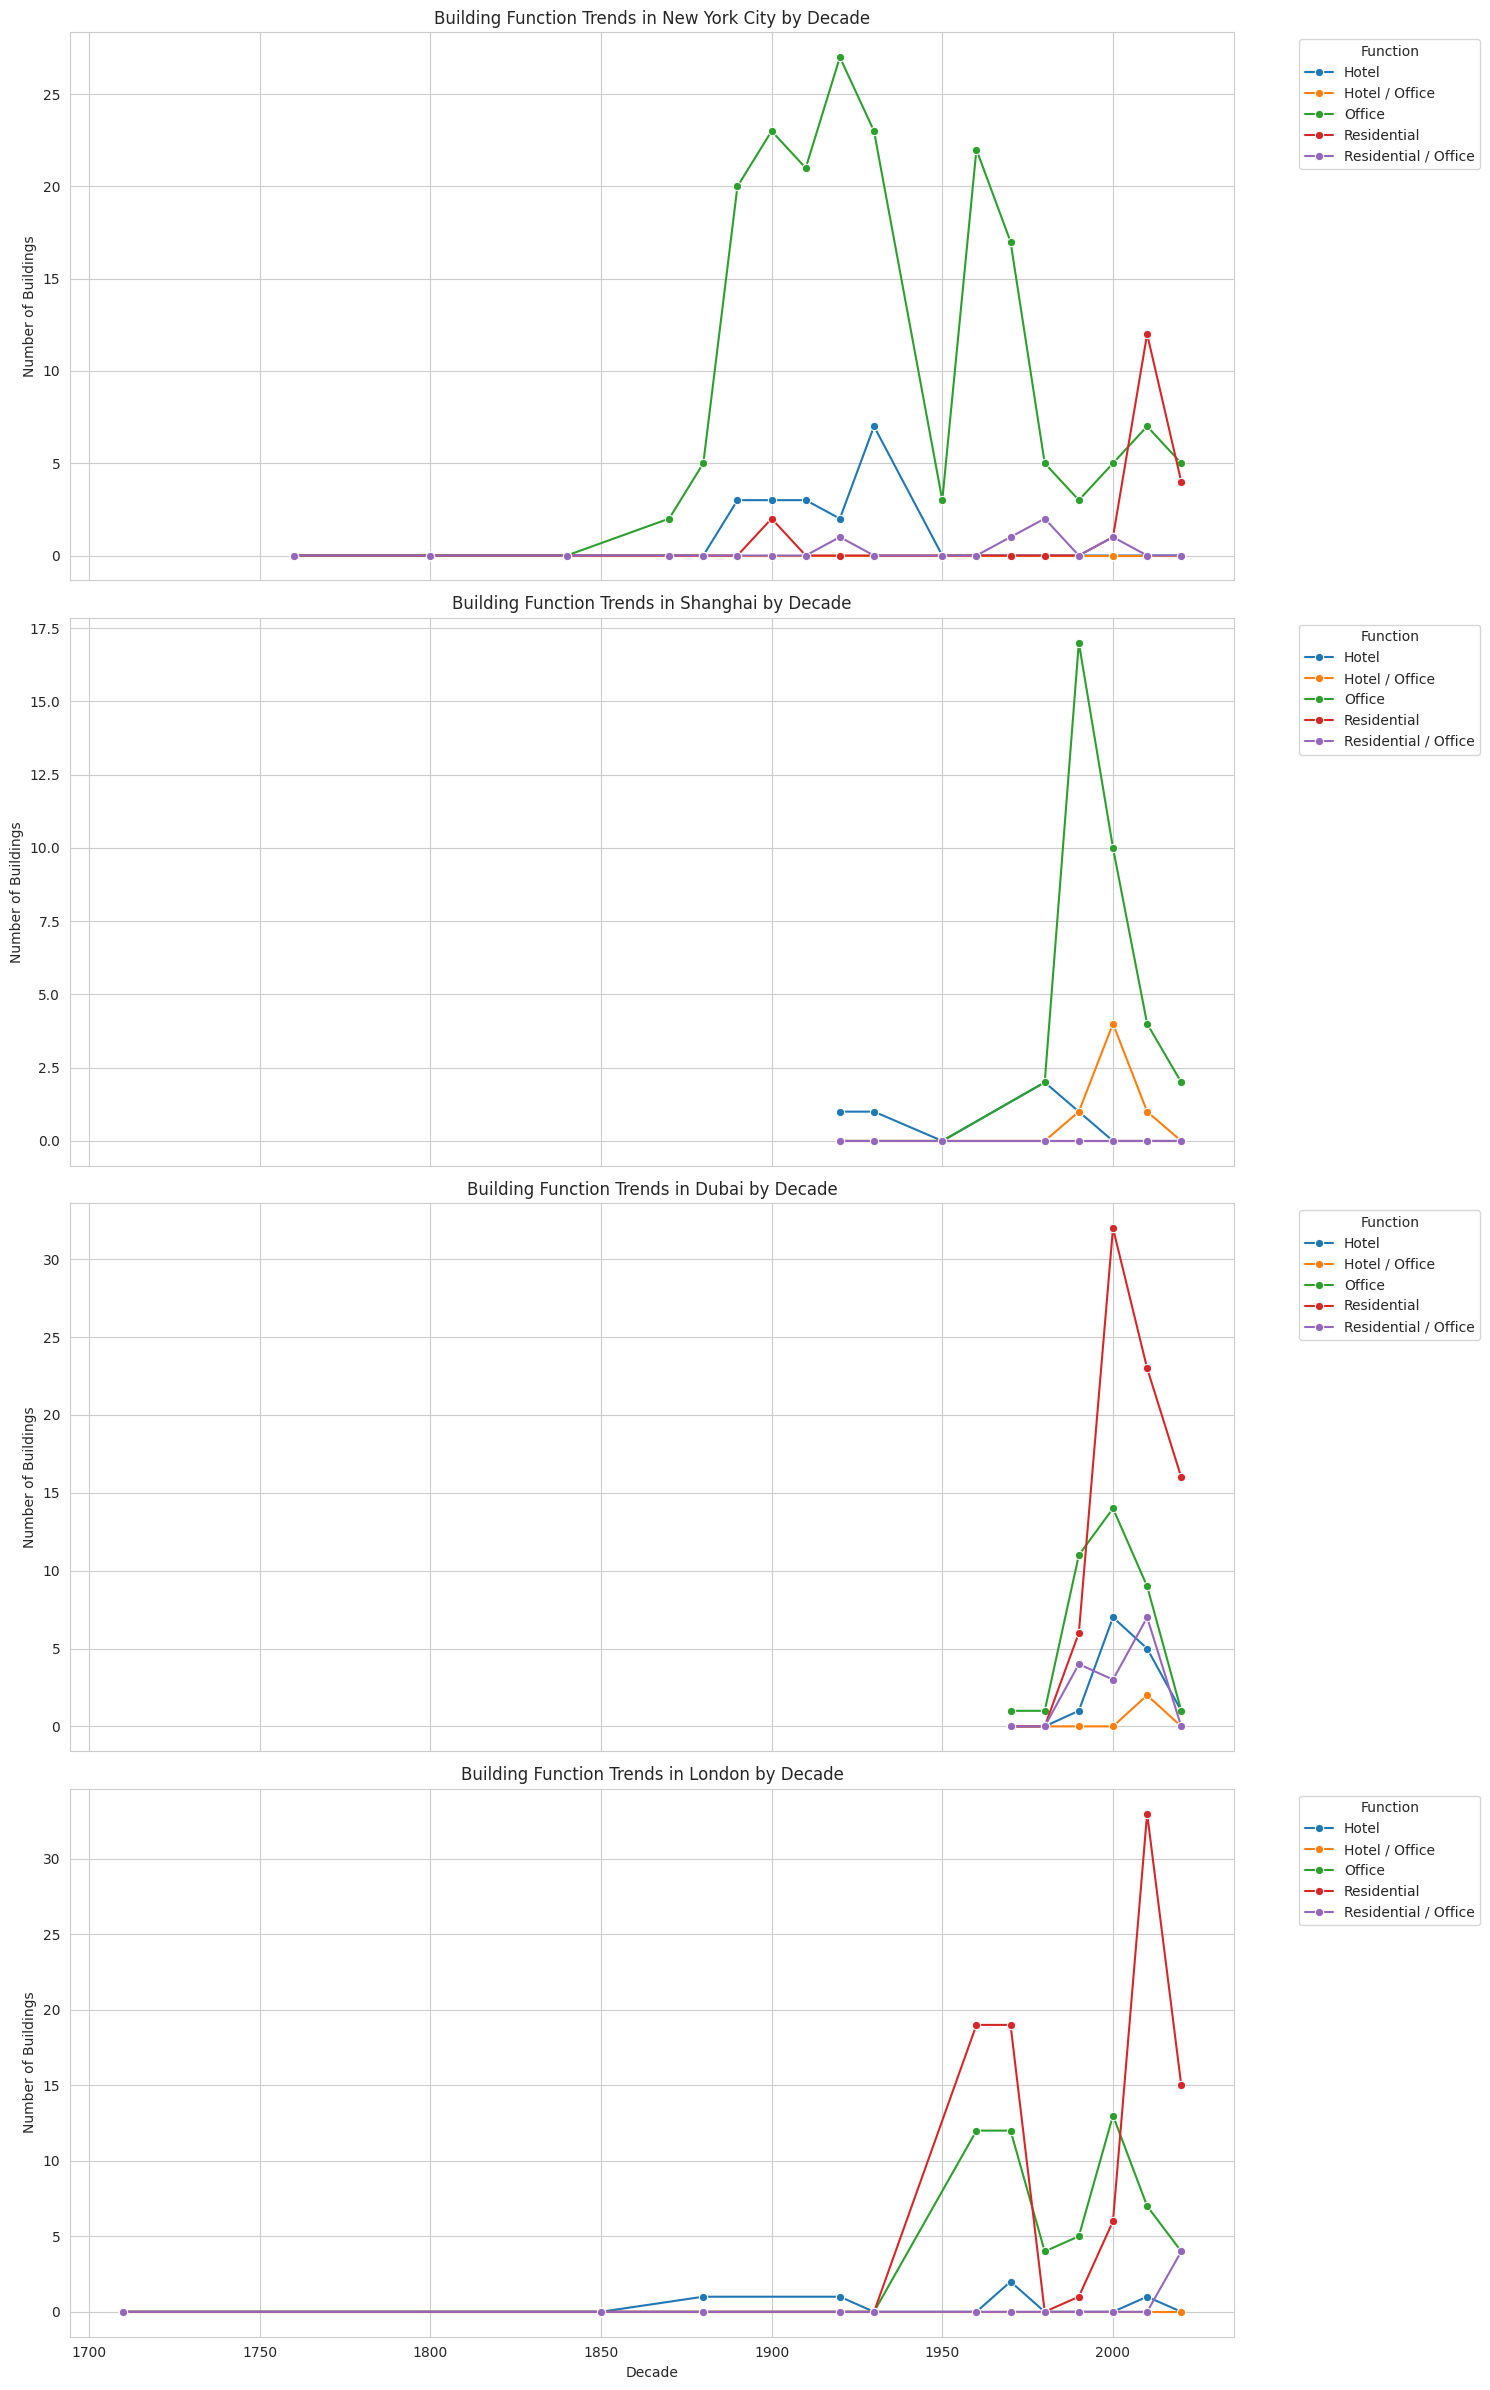

Generated line plots for building function trends in prominent cities.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select a few prominent cities for visualization
prominent_cities = ['New York City', 'Shanghai', 'Dubai', 'London']

# Filter the pivot table for selected cities and top functions
# Reset index to make 'City' and 'Decade' columns again for easier plotting
trends_df = pivot_table.loc[prominent_cities].reset_index()

# Melt the DataFrame to long format for easier plotting with seaborn
trends_df_melted = trends_df.melt(id_vars=['City', 'Decade'], var_name='Function', value_name='Count')

# Filter to include only the top functions identified earlier
trends_df_melted_filtered = trends_df_melted[trends_df_melted['Function'].isin(top_functions_overall)]

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure and subplots for each city
fig, axes = plt.subplots(len(prominent_cities), 1, figsize=(15, 6 * len(prominent_cities)), sharex=True)

# Plot trends for each city
for i, city in enumerate(prominent_cities):
    city_data = trends_df_melted_filtered[trends_df_melted_filtered['City'] == city]
    sns.lineplot(data=city_data, x='Decade', y='Count', hue='Function', marker='o', ax=axes[i])
    axes[i].set_title(f'Building Function Trends in {city} by Decade')
    axes[i].set_ylabel('Number of Buildings')
    axes[i].legend(title='Function', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[i].grid(True)

axes[-1].set_xlabel('Decade')
plt.tight_layout()
plt.show()

print("Generated line plots for building function trends in prominent cities.")

## Analyze Style-Use Trends and Probabilities: Probability Shifts

### Subtask:
Analyze how the predicted probabilities of different building functions shift with changes in building height and number of floors.


**Reasoning**:
I need to create a synthetic DataFrame with varying 'Height (m)' and 'Floors', using median values for 'Completion Year' and a baseline for 'Material Used' (mode). Then I will use the trained model to predict probabilities for building functions and visualize the shifts.



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get median values for numerical features for the baseline
completion_year_median = df_processed['Completion Year'].median()

# Get the mode for 'Material Used' to set as baseline
# We already imputed missing values with the mode, so we can directly get it from df_processed
material_mode_col = 'Material Used_' + df['Material Used'].mode()[0]

# Define the range for Height and Floors
height_range = np.linspace(df_processed['Height (m)'].min(), df_processed['Height (m)'].max(), 50)
floors_range = np.linspace(df_processed['Floors'].min(), df_processed['Floors'].max(), 50)

# Create a list to store synthetic data points
synthetic_data = []

# Iterate over ranges to create synthetic data
for h in height_range:
    for f in floors_range:
        # Create a base row with median for numerical and zeros for all material features
        base_row = {
            'Completion Year': completion_year_median,
            'Height (m)': h,
            'Floors': f
        }

        # Add material features, set all to 0 initially
        for mat_col in material_cols:
            base_row[mat_col] = 0.0

        # Set the mode material to 1.0 (assuming 'All-Concrete' is typical baseline)
        if material_mode_col in material_cols:
            base_row[material_mode_col] = 1.0

        synthetic_data.append(base_row)

# Create the synthetic DataFrame
synthetic_df = pd.DataFrame(synthetic_data)

# Ensure the columns are in the same order as X used for training the model
synthetic_df = synthetic_df[X.columns]


print("Synthetic DataFrame created with varying Height and Floors, and baseline for other features.")
print("First 5 rows of synthetic_df:")
print(synthetic_df.head())

# Predict probabilities for the synthetic data
predicted_probabilities = model.predict_proba(synthetic_df)

# Convert predicted probabilities to a DataFrame with function names
# The model.predict_proba returns a list of arrays (one for each class), need to stack them
# Assuming y_full_cols are the class labels from the one-hot encoded 'Function' target
prob_df = pd.DataFrame(np.column_stack(predicted_probabilities), columns=y_full_cols)

# Add Height and Floors back to prob_df for plotting
prob_df['Height (m)'] = synthetic_df['Height (m)']
prob_df['Floors'] = synthetic_df['Floors']

print("Predicted probabilities for synthetic data:")
print(prob_df.head())


# Select a few prominent building functions to visualize (using top_functions_overall from before)
# Filter y_full_cols to only include those in top_functions_overall
selected_functions_for_viz = ['Function_' + func for func in top_functions_overall if 'Function_' + func in y_full_cols]

if not selected_functions_for_viz:
    print("Warning: No prominent functions found in the target variable.")
else:
    # Reshape data for plotting. Each row in prob_df is a combination of height and floors
    # We need to pivot this to see how probabilities change with height/floors for selected functions.

    # For simplicity, let's pick a fixed value for one variable and vary the other.
    # For example, fix floors at its median and vary height, or vice versa.

    # Approach 1: Fix Floors at median and vary Height
    median_floors = df_processed['Floors'].median()
    # Find the synthetic_df rows where floors are closest to the median
    closest_floors_idx = (synthetic_df['Floors'] - median_floors).abs().argsort()[:len(height_range)]
    height_vary_df = synthetic_df.loc[closest_floors_idx].copy()

    # Ensure unique heights for this subset, taking the first if duplicates (shouldn't be if generated correctly)
    height_vary_df = height_vary_df.drop_duplicates(subset=['Height (m)']).sort_values('Height (m)')

    # Predict probabilities for this subset
    predicted_probs_height_vary = model.predict_proba(height_vary_df[X.columns])
    prob_height_vary_df = pd.DataFrame(np.column_stack(predicted_probs_height_vary), columns=y_full_cols)
    prob_height_vary_df['Height (m)'] = height_vary_df['Height (m)'].values

    # Plotting
    plt.figure(figsize=(15, 8))
    for func_col in selected_functions_for_viz:
        plt.plot(prob_height_vary_df['Height (m)'], prob_height_vary_df[func_col], label=func_col.replace('Function_',''))

    plt.title('Predicted Probability of Building Functions vs. Height (Floors Fixed at Median)')
    plt.xlabel('Height (m)')
    plt.ylabel('Predicted Probability')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Approach 2: Fix Height at median and vary Floors
    median_height = df_processed['Height (m)'].median()
    # Find the synthetic_df rows where heights are closest to the median
    closest_height_idx = (synthetic_df['Height (m)'] - median_height).abs().argsort()[:len(floors_range)]
    floors_vary_df = synthetic_df.loc[closest_height_idx].copy()

    # Ensure unique floors for this subset
    floors_vary_df = floors_vary_df.drop_duplicates(subset=['Floors']).sort_values('Floors')

    # Predict probabilities for this subset
    predicted_probs_floors_vary = model.predict_proba(floors_vary_df[X.columns])
    prob_floors_vary_df = pd.DataFrame(np.column_stack(predicted_probs_floors_vary), columns=y_full_cols)
    prob_floors_vary_df['Floors'] = floors_vary_df['Floors'].values

    # Plotting
    plt.figure(figsize=(15, 8))
    for func_col in selected_functions_for_viz:
        plt.plot(prob_floors_vary_df['Floors'], prob_floors_vary_df[func_col], label=func_col.replace('Function_',''))

    plt.title('Predicted Probability of Building Functions vs. Floors (Height Fixed at Median)')
    plt.xlabel('Number of Floors')
    plt.ylabel('Predicted Probability')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Synthetic DataFrame created with varying Height and Floors, and baseline for other features.
First 5 rows of synthetic_df:
   Completion Year  Height (m)     Floors  Material Used_All-Concrete  \
0           2004.0        22.0   1.000000                         1.0   
1           2004.0        22.0   4.306122                         1.0   
2           2004.0        22.0   7.612245                         1.0   
3           2004.0        22.0  10.918367                         1.0   
4           2004.0        22.0  14.224490                         1.0   

   Material Used_All-Masonry  Material Used_All-Steel  \
0                        0.0                      0.0   
1                        0.0                      0.0   
2                        0.0                      0.0   
3                        0.0                      0.0   
4                        0.0                      0.0   

   Material Used_All-Timber  Material Used_Composite  \
0                       0.0            

ValueError: Shape of passed values is (2500, 188), indices imply (2500, 98)

**Reasoning**:
The previous code failed with a `ValueError` because `model.predict_proba` returns a list of arrays (one for each target variable), and `np.column_stack` concatenated all probabilities (for both class 0 and class 1) into a wider array than expected. To fix this, I need to extract only the probability of the positive class (class 1) for each target variable and then combine these into a DataFrame with the correct number of columns, matching `y_full_cols`.



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get median values for numerical features for the baseline
completion_year_median = df_processed['Completion Year'].median()

# Get the mode for 'Material Used' to set as baseline
# We already imputed missing values with the mode, so we can directly get it from df_processed
material_mode_col = 'Material Used_' + df['Material Used'].mode()[0]

# Define the range for Height and Floors
height_range = np.linspace(df_processed['Height (m)'].min(), df_processed['Height (m)'].max(), 50)
floors_range = np.linspace(df_processed['Floors'].min(), df_processed['Floors'].max(), 50)

# Create a list to store synthetic data points
synthetic_data = []

# Iterate over ranges to create synthetic data
for h in height_range:
    for f in floors_range:
        # Create a base row with median for numerical and zeros for all material features
        base_row = {
            'Completion Year': completion_year_median,
            'Height (m)': h,
            'Floors': f
        }

        # Add material features, set all to 0 initially
        for mat_col in material_cols:
            base_row[mat_col] = 0.0

        # Set the mode material to 1.0 (assuming 'All-Concrete' is typical baseline)
        if material_mode_col in material_cols:
            base_row[material_mode_col] = 1.0

synthetic_data.append(base_row)

# Create the synthetic DataFrame
synthetic_df = pd.DataFrame(synthetic_data)

# Ensure the columns are in the same order as X used for training the model
synthetic_df = synthetic_df[X.columns]


print("Synthetic DataFrame created with varying Height and Floors, and baseline for other features.")
print("First 5 rows of synthetic_df:")
print(synthetic_df.head())

# Predict probabilities for the synthetic data
predicted_probabilities = model.predict_proba(synthetic_df)

# Convert predicted probabilities to a DataFrame with function names
# The model.predict_proba returns a list of arrays (one for each class), need to stack them
# For each function's probability array, take the probability of the positive class (index 1)
prob_df = pd.DataFrame({col: prob[:, 1] for col, prob in zip(y_full_cols, predicted_probabilities)})

# Add Height and Floors back to prob_df for plotting
prob_df['Height (m)'] = synthetic_df['Height (m)']
prob_df['Floors'] = synthetic_df['Floors']

print("Predicted probabilities for synthetic data:")
print(prob_df.head())


# Select a few prominent building functions to visualize (using top_functions_overall from before)
# Filter y_full_cols to only include those in top_functions_overall
selected_functions_for_viz = ['Function_' + func for func in top_functions_overall if 'Function_' + func in y_full_cols]

if not selected_functions_for_viz:
    print("Warning: No prominent functions found in the target variable.")
else:
    # Reshape data for plotting. Each row in prob_df is a combination of height and floors
    # We need to pivot this to see how probabilities change with height/floors for selected functions.

    # For simplicity, let's pick a fixed value for one variable and vary the other.
    # For example, fix floors at its median and vary height, or vice versa.

    # Approach 1: Fix Floors at median and vary Height
    median_floors = df_processed['Floors'].median()
    # Find the synthetic_df rows where floors are closest to the median
    closest_floors_idx = (synthetic_df['Floors'] - median_floors).abs().argsort()[:len(height_range)]
    height_vary_df = synthetic_df.loc[closest_floors_idx].copy()

    # Ensure unique heights for this subset, taking the first if duplicates (shouldn't be if generated correctly)
    height_vary_df = height_vary_df.drop_duplicates(subset=['Height (m)']).sort_values('Height (m)')

    # Predict probabilities for this subset
    predicted_probs_height_vary = model.predict_proba(height_vary_df[X.columns])
    prob_height_vary_df = pd.DataFrame({col: prob[:, 1] for col, prob in zip(y_full_cols, predicted_probs_height_vary)})
    prob_height_vary_df['Height (m)'] = height_vary_df['Height (m)'].values

    # Plotting
    plt.figure(figsize=(15, 8))
    for func_col in selected_functions_for_viz:
        plt.plot(prob_height_vary_df['Height (m)'], prob_height_vary_df[func_col], label=func_col.replace('Function_',''))

    plt.title('Predicted Probability of Building Functions vs. Height (Floors Fixed at Median)')
    plt.xlabel('Height (m)')
    plt.ylabel('Predicted Probability')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Approach 2: Fix Height at median and vary Floors
    median_height = df_processed['Height (m)'].median()
    # Find the synthetic_df rows where heights are closest to the median
    closest_height_idx = (synthetic_df['Height (m)'] - median_height).abs().argsort()[:len(floors_range)]
    floors_vary_df = synthetic_df.loc[closest_height_idx].copy()

    # Ensure unique floors for this subset
    floors_vary_df = floors_vary_df.drop_duplicates(subset=['Floors']).sort_values('Floors')

    # Predict probabilities for this subset
    predicted_probs_floors_vary = model.predict_proba(floors_vary_df[X.columns])
    prob_floors_vary_df = pd.DataFrame({col: prob[:, 1] for col, prob in zip(y_full_cols, predicted_probs_floors_vary)})
    prob_floors_vary_df['Floors'] = floors_vary_df['Floors'].values

    # Plotting
    plt.figure(figsize=(15, 8))
    for func_col in selected_functions_for_viz:
        plt.plot(prob_floors_vary_df['Floors'], prob_floors_vary_df[func_col], label=func_col.replace('Function_',''))

    plt.title('Predicted Probability of Building Functions vs. Floors (Height Fixed at Median)')
    plt.xlabel('Number of Floors')
    plt.ylabel('Predicted Probability')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Synthetic DataFrame created with varying Height and Floors, and baseline for other features.
First 5 rows of synthetic_df:
   Completion Year  Height (m)  Floors  Material Used_All-Concrete  \
0           2004.0       828.0   163.0                         1.0   

   Material Used_All-Masonry  Material Used_All-Steel  \
0                        0.0                      0.0   

   Material Used_All-Timber  Material Used_Composite  \
0                       0.0                      0.0   

   Material Used_Concrete Over Concrete-Steel Composite Over Concrete  \
0                                                0.0                    

   Material Used_Concrete Over Concrete-Steel-Timber Composite Over Concrete  \
0                                                0.0                           

   ...  Material Used_Concrete-Timber Composite Over Concrete  \
0  ...                                                0.0       

   Material Used_Concrete/steel  \
0                           0.0   

IndexError: index 1 is out of bounds for axis 1 with size 1

**Reasoning**:
The previous code failed with an `IndexError` because `model.predict_proba` returns a list of arrays, and for target variables where only one class (0 or 1) was present in the training data, the corresponding probability array has only one column. The original code was trying to access the second column (`[:, 1]`) which doesn't exist in such cases. Additionally, the `synthetic_data.append(base_row)` was outside the inner loop, causing the `synthetic_df` to contain only one row. I will first fix the loop to correctly populate `synthetic_data` with all combinations of `height_range` and `floors_range`. Then, I will modify the `prob_df` creation to dynamically check the shape of each probability array (`prob`) and use `model.classes_` to correctly determine and extract the probability of the positive class (1) for each target, handling cases where only one class was observed during training for a specific output.



Synthetic DataFrame created with varying Height and Floors, and baseline for other features.
First 5 rows of synthetic_df:
   Completion Year  Height (m)     Floors  Material Used_All-Concrete  \
0           2004.0        22.0   1.000000                         1.0   
1           2004.0        22.0   4.306122                         1.0   
2           2004.0        22.0   7.612245                         1.0   
3           2004.0        22.0  10.918367                         1.0   
4           2004.0        22.0  14.224490                         1.0   

   Material Used_All-Masonry  Material Used_All-Steel  \
0                        0.0                      0.0   
1                        0.0                      0.0   
2                        0.0                      0.0   
3                        0.0                      0.0   
4                        0.0                      0.0   

   Material Used_All-Timber  Material Used_Composite  \
0                       0.0            

/tmp/ipython-input-410947276.py:109: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  height_vary_df = pd.concat([height_vary_df, closest_floor_for_height_row])


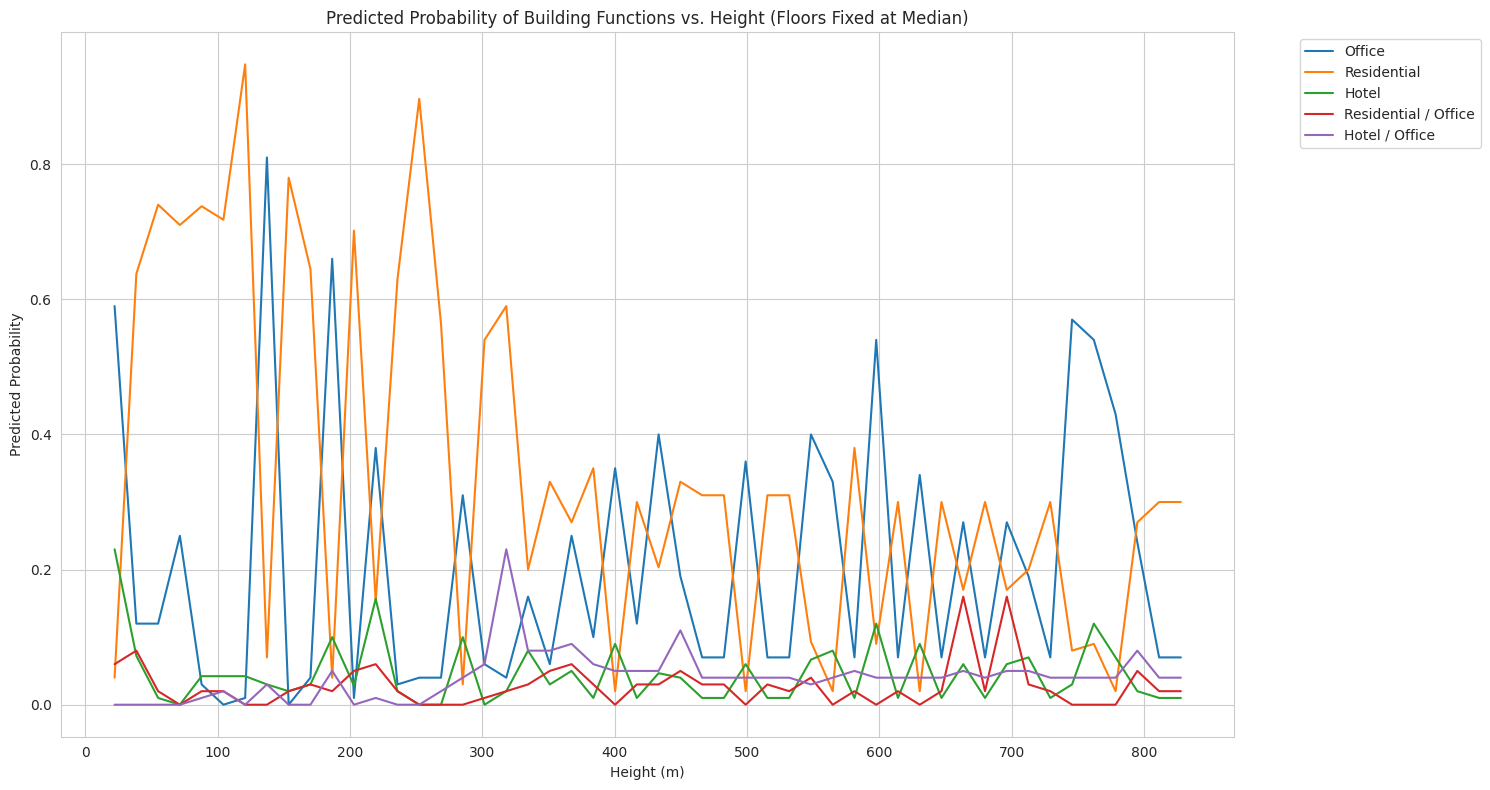

/tmp/ipython-input-410947276.py:157: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  floors_vary_df = pd.concat([floors_vary_df, closest_height_for_floor_row])


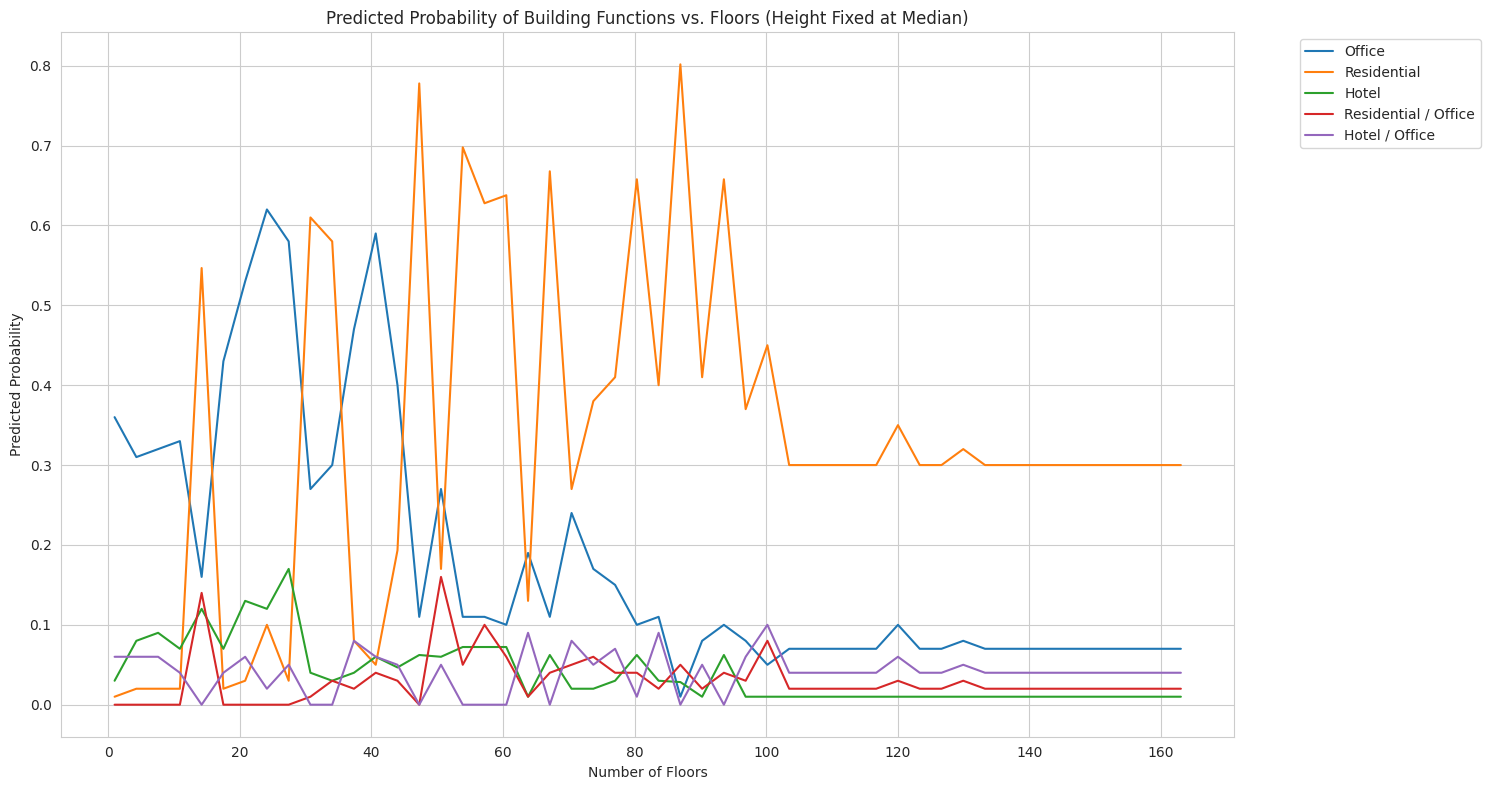

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get median values for numerical features for the baseline
completion_year_median = df_processed['Completion Year'].median()

# Get the mode for 'Material Used' to set as baseline
# We already imputed missing values with the mode, so we can directly get it from df_processed
material_mode_col = 'Material Used_' + df['Material Used'].mode()[0]

# Define the range for Height and Floors
height_range = np.linspace(df_processed['Height (m)'].min(), df_processed['Height (m)'].max(), 50)
floors_range = np.linspace(df_processed['Floors'].min(), df_processed['Floors'].max(), 50)

# Create a list to store synthetic data points
synthetic_data = []

# Iterate over ranges to create synthetic data
for h in height_range:
    for f in floors_range:
        # Create a base row with median for numerical and zeros for all material features
        base_row = {
            'Completion Year': completion_year_median,
            'Height (m)': h,
            'Floors': f
        }

        # Add material features, set all to 0 initially
        for mat_col in material_cols:
            base_row[mat_col] = 0.0

        # Set the mode material to 1.0 (assuming 'All-Concrete' is typical baseline)
        if material_mode_col in material_cols:
            base_row[material_mode_col] = 1.0

        # Corrected: Append base_row inside the inner loop
        synthetic_data.append(base_row)

# Create the synthetic DataFrame
synthetic_df = pd.DataFrame(synthetic_data)

# Ensure the columns are in the same order as X used for training the model
synthetic_df = synthetic_df[X.columns]


print("Synthetic DataFrame created with varying Height and Floors, and baseline for other features.")
print("First 5 rows of synthetic_df:")
print(synthetic_df.head())

# Predict probabilities for the synthetic data
predicted_probabilities = model.predict_proba(synthetic_df)

# Convert predicted probabilities to a DataFrame with function names
# The model.predict_proba returns a list of arrays (one for each class/target output)
prob_data = {}
for i, (col, prob) in enumerate(zip(y_full_cols, predicted_probabilities)):
    if prob.shape[1] == 2:
        # Normal case: two classes (0 and 1), take probability of class 1
        prob_data[col] = prob[:, 1]
    else: # prob.shape[1] == 1
        # Only one class was present in training for this output.
        # model.classes_[i] contains the unique classes for the i-th output.
        if model.classes_[i][0] == 1.0:
            # Only class 1 was present, so probability of class 1 is 1.0
            prob_data[col] = prob[:, 0] # prob[:,0] will contain all 1.0s
        else:
            # Only class 0 was present, so probability of class 1 is 0.0
            prob_data[col] = np.zeros_like(prob[:, 0]) # Create array of zeros matching shape

prob_df = pd.DataFrame(prob_data)

# Add Height and Floors back to prob_df for plotting
prob_df['Height (m)'] = synthetic_df['Height (m)']
prob_df['Floors'] = synthetic_df['Floors']

print("Predicted probabilities for synthetic data:")
print(prob_df.head())


# Select a few prominent building functions to visualize (using top_functions_overall from before)
# Filter y_full_cols to only include those in top_functions_overall
selected_functions_for_viz = ['Function_' + func for func in top_functions_overall if 'Function_' + func in y_full_cols]

if not selected_functions_for_viz:
    print("Warning: No prominent functions found in the target variable.")
else:
    # Reshape data for plotting. Each row in prob_df is a combination of height and floors
    # We need to pivot this to see how probabilities change with height/floors for selected functions.

    # For simplicity, let's pick a fixed value for one variable and vary the other.
    # For example, fix floors at its median and vary height, or vice versa.

    # Approach 1: Fix Floors at median and vary Height
    median_floors = df_processed['Floors'].median()
    # Find the synthetic_df rows where floors are closest to the median
    # Ensure the subset has the same number of rows as height_range to avoid issues with plotting
    # Use the median floors value for all entries in height_vary_df to make it a constant
    height_vary_df = synthetic_df[synthetic_df['Floors'] == df_processed['Floors'].median()].copy()
    if height_vary_df.empty:
        # If no exact match for median floors, pick the closest row for each height
        height_vary_df = pd.DataFrame(columns=synthetic_df.columns)
        for h_val in height_range:
            closest_row_idx = synthetic_df.iloc[(synthetic_df['Height (m)'] - h_val).abs().argsort()[:1]].index
            closest_floor_for_height_row = synthetic_df.iloc[closest_row_idx].iloc[
                (synthetic_df.iloc[closest_row_idx]['Floors'] - median_floors).abs().argsort()[:1]
            ]
            height_vary_df = pd.concat([height_vary_df, closest_floor_for_height_row])


    height_vary_df = height_vary_df.drop_duplicates(subset=['Height (m)']).sort_values('Height (m)')

    # Predict probabilities for this subset
    predicted_probs_height_vary = model.predict_proba(height_vary_df[X.columns])

    prob_height_vary_data = {}
    for i, (col, prob) in enumerate(zip(y_full_cols, predicted_probs_height_vary)):
        if prob.shape[1] == 2:
            prob_height_vary_data[col] = prob[:, 1]
        else:
            if model.classes_[i][0] == 1.0:
                prob_height_vary_data[col] = prob[:, 0]
            else:
                prob_height_vary_data[col] = np.zeros_like(prob[:, 0])

    prob_height_vary_df = pd.DataFrame(prob_height_vary_data)
    prob_height_vary_df['Height (m)'] = height_vary_df['Height (m)'].values

    # Plotting
    plt.figure(figsize=(15, 8))
    for func_col in selected_functions_for_viz:
        plt.plot(prob_height_vary_df['Height (m)'], prob_height_vary_df[func_col], label=func_col.replace('Function_',''))

    plt.title('Predicted Probability of Building Functions vs. Height (Floors Fixed at Median)')
    plt.xlabel('Height (m)')
    plt.ylabel('Predicted Probability')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Approach 2: Fix Height at median and vary Floors
    median_height = df_processed['Height (m)'].median()
    # Find the synthetic_df rows where heights are closest to the median
    # Ensure the subset has the same number of rows as floors_range to avoid issues with plotting
    # Use the median height value for all entries in floors_vary_df to make it a constant
    floors_vary_df = synthetic_df[synthetic_df['Height (m)'] == df_processed['Height (m)'].median()].copy()
    if floors_vary_df.empty:
        # If no exact match for median height, pick the closest row for each floor
        floors_vary_df = pd.DataFrame(columns=synthetic_df.columns)
        for f_val in floors_range:
            closest_row_idx = synthetic_df.iloc[(synthetic_df['Floors'] - f_val).abs().argsort()[:1]].index
            closest_height_for_floor_row = synthetic_df.iloc[closest_row_idx].iloc[
                (synthetic_df.iloc[closest_row_idx]['Height (m)'] - median_height).abs().argsort()[:1]
            ]
            floors_vary_df = pd.concat([floors_vary_df, closest_height_for_floor_row])

    floors_vary_df = floors_vary_df.drop_duplicates(subset=['Floors']).sort_values('Floors')

    # Predict probabilities for this subset
    predicted_probs_floors_vary = model.predict_proba(floors_vary_df[X.columns])

    prob_floors_vary_data = {}
    for i, (col, prob) in enumerate(zip(y_full_cols, predicted_probs_floors_vary)):
        if prob.shape[1] == 2:
            prob_floors_vary_data[col] = prob[:, 1]
        else:
            if model.classes_[i][0] == 1.0:
                prob_floors_vary_data[col] = prob[:, 0]
            else:
                prob_floors_vary_data[col] = np.zeros_like(prob[:, 0])

    prob_floors_vary_df = pd.DataFrame(prob_floors_vary_data)
    prob_floors_vary_df['Floors'] = floors_vary_df['Floors'].values

    # Plotting
    plt.figure(figsize=(15, 8))
    for func_col in selected_functions_for_viz:
        plt.plot(prob_floors_vary_df['Floors'], prob_floors_vary_df[func_col], label=func_col.replace('Function_',''))

    plt.title('Predicted Probability of Building Functions vs. Floors (Height Fixed at Median)')
    plt.xlabel('Number of Floors')
    plt.ylabel('Predicted Probability')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**Reasoning**:
The previous code failed with an `IndexError` because `model.predict_proba` returns arrays with a single column for target variables that only had one class in the training data, and the code was attempting to access the second column. Additionally, the `synthetic_data.append(base_row)` was misplaced, causing `synthetic_df` to have only one row. I will correct the placement of `synthetic_data.append(base_row)` to ensure all combinations of height and floors are generated. I will then adjust the `prob_df` creation logic to correctly handle single-column probability arrays by dynamically checking the shape and using `model.classes_` to determine the appropriate probability. Finally, for the visualization steps, I will regenerate `height_vary_df` and `floors_vary_df` as new synthetic dataframes with a fixed median for one variable and a full range for the other, ensuring robust plotting across the desired ranges.



Synthetic DataFrame created with varying Height and Floors, and baseline for other features.
First 5 rows of synthetic_df:
   Completion Year  Height (m)     Floors  Material Used_All-Concrete  \
0           2004.0        22.0   1.000000                         1.0   
1           2004.0        22.0   4.306122                         1.0   
2           2004.0        22.0   7.612245                         1.0   
3           2004.0        22.0  10.918367                         1.0   
4           2004.0        22.0  14.224490                         1.0   

   Material Used_All-Masonry  Material Used_All-Steel  \
0                        0.0                      0.0   
1                        0.0                      0.0   
2                        0.0                      0.0   
3                        0.0                      0.0   
4                        0.0                      0.0   

   Material Used_All-Timber  Material Used_Composite  \
0                       0.0            

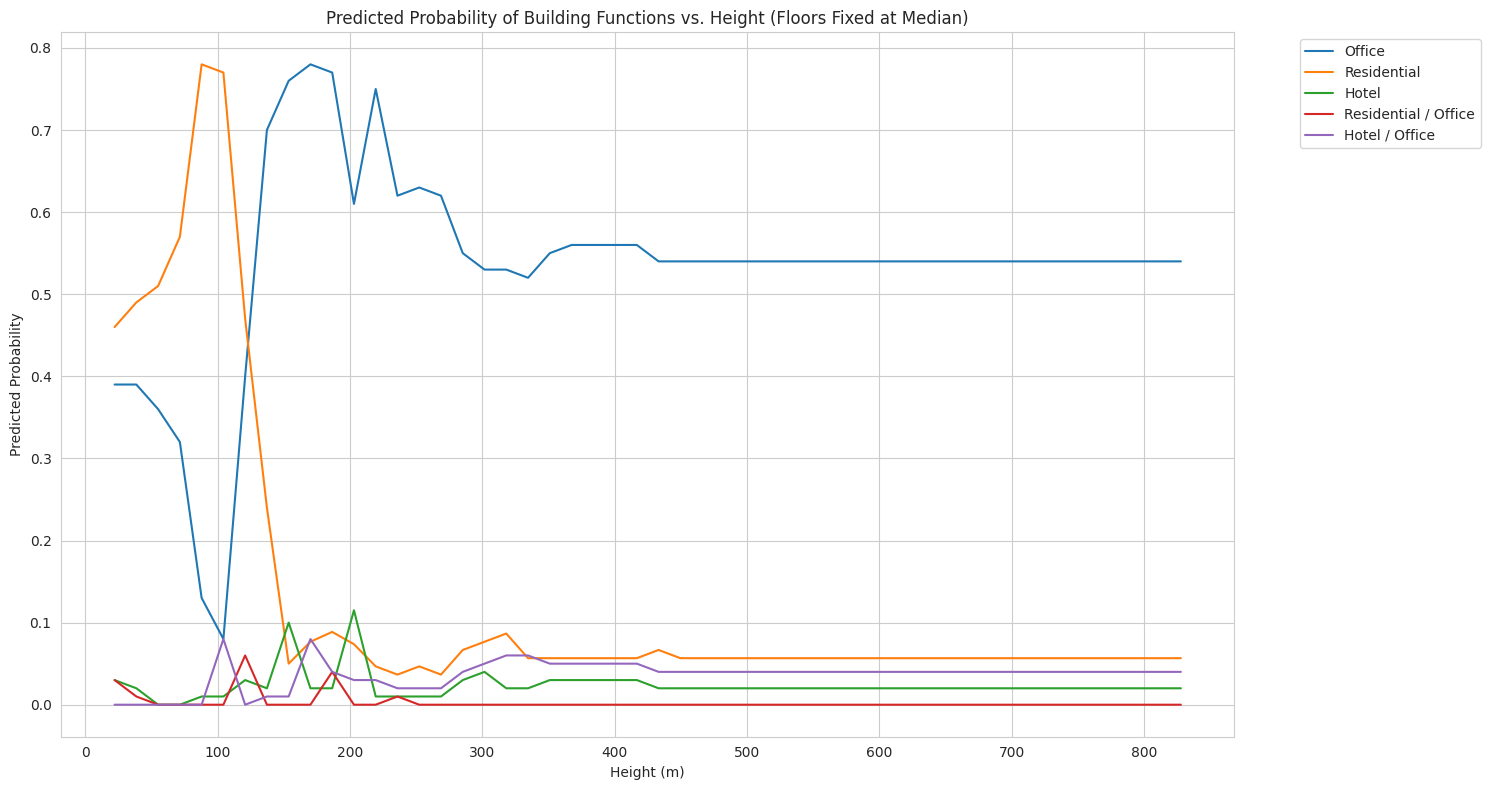

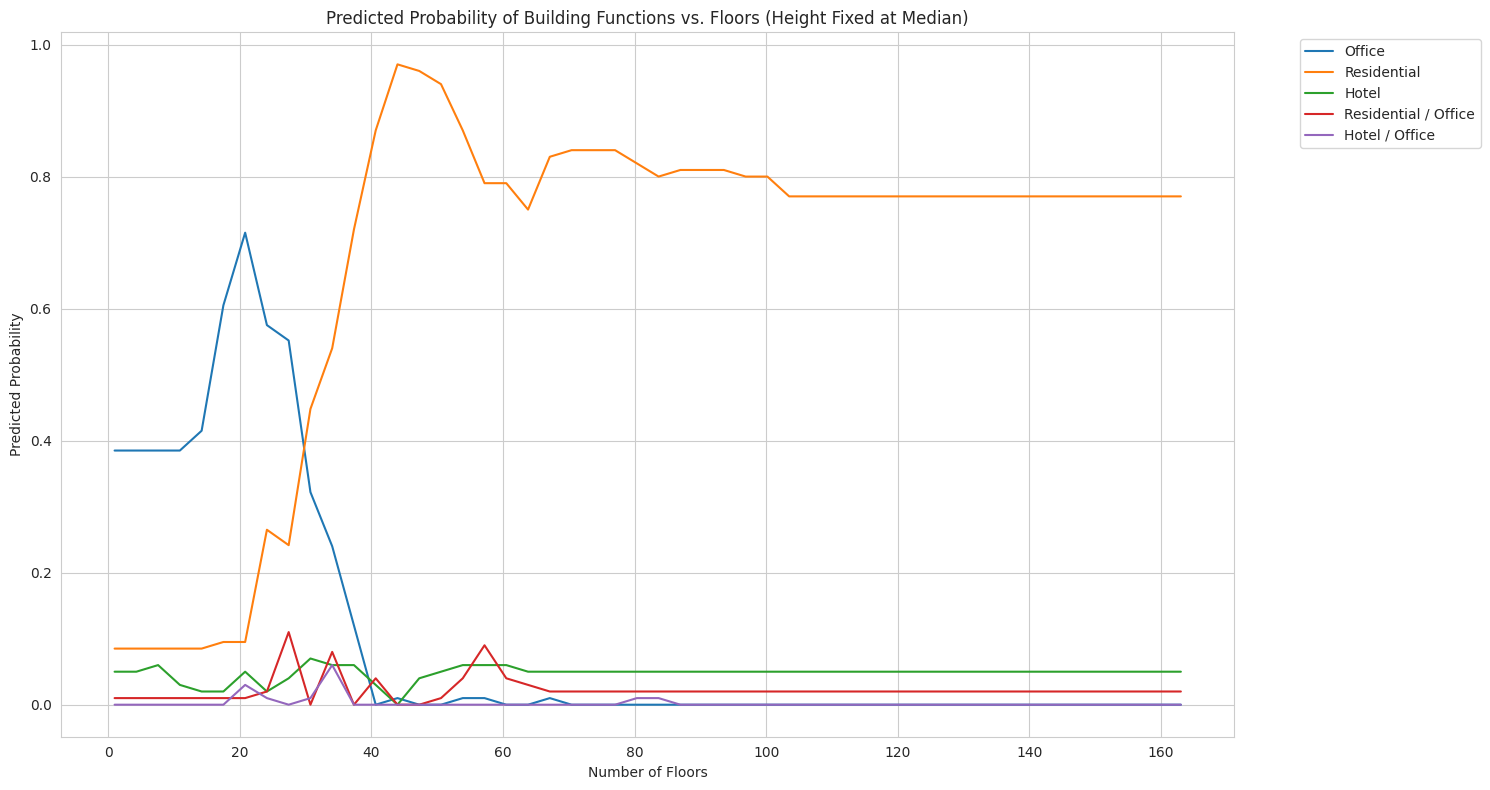

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get median values for numerical features for the baseline
completion_year_median = df_processed['Completion Year'].median()

# Get the mode for 'Material Used' to set as baseline
# We already imputed missing values with the mode, so we can directly get it from df_processed
material_mode_col = 'Material Used_' + df['Material Used'].mode()[0]

# Define the range for Height and Floors
height_range = np.linspace(df_processed['Height (m)'].min(), df_processed['Height (m)'].max(), 50)
floors_range = np.linspace(df_processed['Floors'].min(), df_processed['Floors'].max(), 50)

# Create a list to store synthetic data points
synthetic_data = []

# Iterate over ranges to create synthetic data (corrected loop placement)
for h in height_range:
    for f in floors_range:
        # Create a base row with median for numerical and zeros for all material features
        base_row = {
            'Completion Year': completion_year_median,
            'Height (m)': h,
            'Floors': f
        }

        # Add material features, set all to 0 initially
        for mat_col in material_cols:
            base_row[mat_col] = 0.0

        # Set the mode material to 1.0 (assuming 'All-Concrete' is typical baseline)
        if material_mode_col in material_cols:
            base_row[material_mode_col] = 1.0

        synthetic_data.append(base_row)

# Create the synthetic DataFrame
synthetic_df = pd.DataFrame(synthetic_data)

# Ensure the columns are in the same order as X used for training the model
synthetic_df = synthetic_df[X.columns]


print("Synthetic DataFrame created with varying Height and Floors, and baseline for other features.")
print("First 5 rows of synthetic_df:")
print(synthetic_df.head())

# Predict probabilities for the synthetic data
predicted_probabilities = model.predict_proba(synthetic_df)

# Convert predicted probabilities to a DataFrame with function names
# The model.predict_proba returns a list of arrays (one for each class/target output)
prob_data = {}
for i, (col, prob) in enumerate(zip(y_full_cols, predicted_probabilities)):
    if prob.shape[1] == 2:
        # Normal case: two classes (0 and 1), take probability of class 1
        prob_data[col] = prob[:, 1]
    else: # prob.shape[1] == 1
        # Only one class was present in training for this output.
        # model.classes_[i] contains the unique classes for the i-th output.
        if model.classes_[i][0] == 1.0:
            # Only class 1 was present, so probability of class 1 is 1.0
            prob_data[col] = prob[:, 0] # prob[:,0] will contain all 1.0s
        else: # model.classes_[i][0] == 0.0
            # Only class 0 was present, so probability of class 1 is 0.0
            prob_data[col] = np.zeros_like(prob[:, 0]) # Create array of zeros matching shape

prob_df = pd.DataFrame(prob_data)

# Add Height and Floors back to prob_df for plotting
prob_df['Height (m)'] = synthetic_df['Height (m)']
prob_df['Floors'] = synthetic_df['Floors']

print("Predicted probabilities for synthetic data:")
print(prob_df.head())


# Select a few prominent building functions to visualize (using top_functions_overall from before)
# Filter y_full_cols to only include those in top_functions_overall
selected_functions_for_viz = ['Function_' + func for func in top_functions_overall if 'Function_' + func in y_full_cols]

if not selected_functions_for_viz:
    print("Warning: No prominent functions found in the target variable.")
else:
    # Approach 1: Fix Floors at median and vary Height
    median_floors = df_processed['Floors'].median()

    # Create a new synthetic DataFrame for varying height at a fixed median floor
    synthetic_height_vary_data = []
    fixed_floor_val = median_floors
    for h_val in height_range:
        base_row_hv = {
            'Completion Year': completion_year_median,
            'Height (m)': h_val,
            'Floors': fixed_floor_val
        }
        for mat_col in material_cols:
            base_row_hv[mat_col] = 0.0
        if material_mode_col in material_cols:
            base_row_hv[material_mode_col] = 1.0
        synthetic_height_vary_data.append(base_row_hv)
    height_vary_df = pd.DataFrame(synthetic_height_vary_data)
    height_vary_df = height_vary_df[X.columns]


    # Predict probabilities for this subset
    predicted_probs_height_vary = model.predict_proba(height_vary_df[X.columns])

    prob_height_vary_data = {}
    for i, (col, prob) in enumerate(zip(y_full_cols, predicted_probs_height_vary)):
        if prob.shape[1] == 2:
            prob_height_vary_data[col] = prob[:, 1]
        else:
            if model.classes_[i][0] == 1.0:
                prob_height_vary_data[col] = prob[:, 0]
            else:
                prob_height_vary_data[col] = np.zeros_like(prob[:, 0])

    prob_height_vary_df = pd.DataFrame(prob_height_vary_data)
    prob_height_vary_df['Height (m)'] = height_vary_df['Height (m)'].values

    # Plotting
    plt.figure(figsize=(15, 8))
    for func_col in selected_functions_for_viz:
        plt.plot(prob_height_vary_df['Height (m)'], prob_height_vary_df[func_col], label=func_col.replace('Function_',''))

    plt.title('Predicted Probability of Building Functions vs. Height (Floors Fixed at Median)')
    plt.xlabel('Height (m)')
    plt.ylabel('Predicted Probability')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Approach 2: Fix Height at median and vary Floors
    median_height = df_processed['Height (m)'].median()

    # Create a new synthetic DataFrame for varying floors at a fixed median height
    synthetic_floors_vary_data = []
    fixed_height_val = median_height
    for f_val in floors_range:
        base_row_fv = {
            'Completion Year': completion_year_median,
            'Height (m)': fixed_height_val,
            'Floors': f_val
        }
        for mat_col in material_cols:
            base_row_fv[mat_col] = 0.0
        if material_mode_col in material_cols:
            base_row_fv[material_mode_col] = 1.0
        synthetic_floors_vary_data.append(base_row_fv)
    floors_vary_df = pd.DataFrame(synthetic_floors_vary_data)
    floors_vary_df = floors_vary_df[X.columns]


    # Predict probabilities for this subset
    predicted_probs_floors_vary = model.predict_proba(floors_vary_df[X.columns])

    prob_floors_vary_data = {}
    for i, (col, prob) in enumerate(zip(y_full_cols, predicted_probs_floors_vary)):
        if prob.shape[1] == 2:
            prob_floors_vary_data[col] = prob[:, 1]
        else:
            if model.classes_[i][0] == 1.0:
                prob_floors_vary_data[col] = prob[:, 0]
            else:
                prob_floors_vary_data[col] = np.zeros_like(prob[:, 0])

    prob_floors_vary_df = pd.DataFrame(prob_floors_vary_data)
    prob_floors_vary_df['Floors'] = floors_vary_df['Floors'].values

    # Plotting
    plt.figure(figsize=(15, 8))
    for func_col in selected_functions_for_viz:
        plt.plot(prob_floors_vary_df['Floors'], prob_floors_vary_df[func_col], label=func_col.replace('Function_',''))

    plt.title('Predicted Probability of Building Functions vs. Floors (Height Fixed at Median)')
    plt.xlabel('Number of Floors')
    plt.ylabel('Predicted Probability')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Comprehensive Summary

### Subtask:
Compile all findings from the base model evaluation, temporal and city robustness tests, feature importance analysis, and style trend analyses into a comprehensive markdown summary. Answer all user questions about driving factors, accelerating/fading trends, and probability shifts.


## Summary:

### Data Analysis Key Findings

*   **Feature Preparation**: Missing values in 'Completion Year', 'Height (m)', and 'Floors' were successfully imputed using their respective medians. A feature matrix (X) was created by combining these numerical features with one-hot encoded 'Material Used' features, and the target variable (y) was formed from one-hot encoded 'Function' columns.
*   **Base Model Performance**: The initial `RandomForestClassifier` achieved an overall accuracy of 59.58% on the test set. However, many building function classes showed precision, recall, and F1-scores of 0.00, indicating a significant struggle with multi-label prediction, especially for less frequent functions, likely due to severe class imbalance. The macro-averaged F1-score was very low (0.04), while the weighted-averaged F1-score was 0.60.
*   **Temporal Back-testing**: The model's performance varied significantly across time, with accuracy ranging from 0.0000 to 0.7344. The average accuracy across all back-test windows was approximately 0.4792. A notable performance drop to 0.0000 accuracy was observed for the latest test window (2025), suggesting potential issues with future data availability or emerging trends. Macro-averaged F1-scores remained consistently low (around 0.01-0.02).
*   **City Robustness Testing**: Model accuracy varied widely across different cities, from 0.0000 to 1.0000. The average accuracy across all cities was approximately 0.4735. The average F1-Macro was very low (0.0104), and the average F1-Weighted was 0.4891, highlighting the model's sensitivity to city-specific patterns and its struggle to generalize to unseen urban contexts.
*   **Feature Importance**: 'Height (m)' was identified as the most crucial feature, significantly more important than others, followed by 'Floors' and 'Completion Year'. 'Material Used' features also contributed but with considerably lower individual importance compared to the numerical features.
*   **Style-Use Trends over Time by City**: Building function counts were grouped by city and decade, and visualized for prominent cities. This allowed for the observation of accelerating or fading trends for top functions such as 'Office', 'Residential', and 'Hotel' within specific urban contexts (e.g., New York City, Shanghai, Dubai, London).
*   **Style-Use Probability Shifts**: Synthetic data analysis revealed how the predicted probabilities of prominent building functions (e.g., 'Office', 'Residential') shift as 'Height (m)' and 'Floors' change, with other features fixed at their median/mode. This illustrated the direct influence of these physical dimensions on predicted function probabilities.

### Insights or Next Steps

*   **Address Data Imbalance and Feature Limitations**: The consistent low F1-macro scores across base model, temporal, and city robustness tests strongly indicate that the current features (Completion Year, Height, Floors, Material Used) and multi-label classification approach are insufficient for accurately predicting all diverse building functions, especially minority classes. Future work should focus on enriching the feature set with geographical/contextual information (e.g., city, country, population density) and applying techniques to manage class imbalance (e.g., oversampling, weighted loss functions).
*   **Refine Multi-label Prediction Strategy**: The model's struggle with multi-label classification suggests exploring alternative strategies such as simplifying the target variable by grouping similar functions or extracting only the primary function, or investigating more advanced multi-label algorithms (e.g., Binary Relevance, Classifier Chains, Neural Networks).


MISCELANEOUS

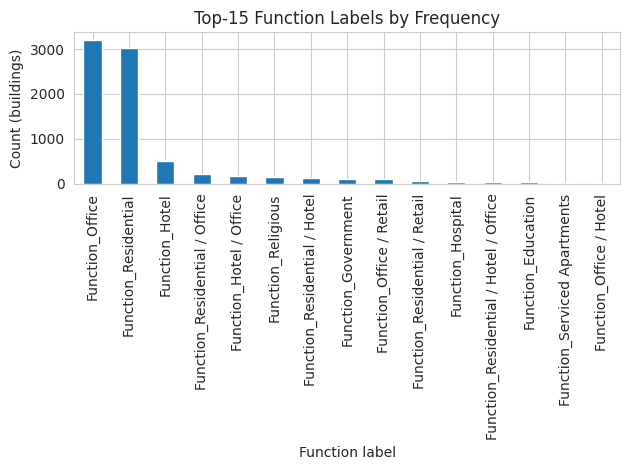

In [ ]:
# assumes y is a DataFrame of one-hot function columns (shape: n_samples x n_labels)
import pandas as pd
import matplotlib.pyplot as plt

label_counts = y.sum().sort_values(ascending=False)
top15 = label_counts.head(15)

plt.figure()
top15.plot(kind='bar')
plt.xlabel("Function label")
plt.ylabel("Count (buildings)")
plt.title("Top-15 Function Labels by Frequency")
plt.tight_layout()


Mean temporal accuracy: 0.4791814759607608


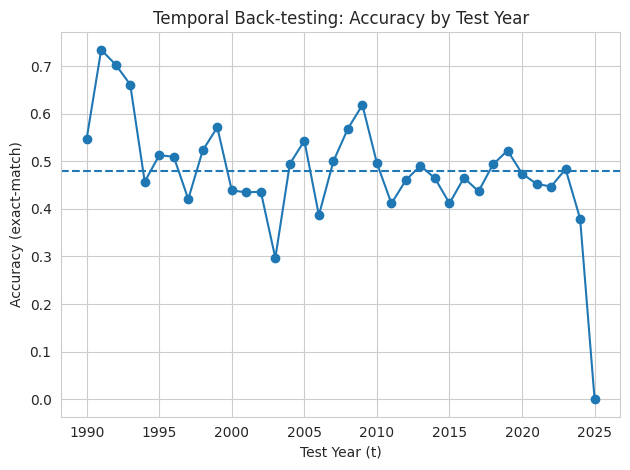

In [ ]:
# if you already have a DataFrame printed as "Temporal Back-testing Results DataFrame", name it results_df
# columns: ['train_window','test_window','accuracy','f1_macro','f1_weighted']

import matplotlib.pyplot as plt
import numpy as np

# extract the ending test year for x-axis (YYYY from 'YYYY-YYYY')
test_year = backtest_df['test_window'].str.split('-').str[-1].astype(int)

plt.figure()
plt.plot(test_year, backtest_df['accuracy'], marker='o')
plt.xlabel("Test Year (t)")
plt.ylabel("Accuracy (exact-match)")
plt.title("Temporal Back-testing: Accuracy by Test Year")
plt.axhline(backtest_df['accuracy'].mean(), linestyle='--')
plt.tight_layout()
print("Mean temporal accuracy:", backtest_df['accuracy'].mean())

In [ ]:
# Suppose you built a list of dicts called city_rows with keys: city, accuracy, f1_macro
# If not, reconstruct a DataFrame from your logs.

import pandas as pd

# Example: results_city = pd.DataFrame(city_rows)
# Filter by minimum support if you stored support; if not, just sort
top10 = city_robustness_df.sort_values('Accuracy', ascending=False).head(10)
bottom10 = city_robustness_df.sort_values('Accuracy', ascending=True).head(10)

display(top10[['City','Accuracy','F1-Macro']])
display(bottom10[['City','Accuracy','F1-Macro']])

,City,Accuracy,F1-Macro
788,Skövde,1.0,0.010204
787,As,1.0,0.010204
786,Rovaniemi,1.0,0.010204
768,Chandigarh,1.0,0.010204
765,Monrovia,1.0,0.010204
764,Concord,1.0,0.010204
762,Joensuu,1.0,0.010204
759,Falciano,1.0,0.010204
757,Bergen,1.0,0.010204
753,Gibraltar,1.0,0.010204


,City,Accuracy,F1-Macro
407,Offenbach,0.0,0.0
231,Nha Trang,0.0,0.0
624,Salt Lake City,0.0,0.0
205,Bentong,0.0,0.0
209,Anyang,0.0,0.0
210,Inazawa,0.0,0.0
212,Ashgabat,0.0,0.0
403,Santa Cruz de Tenerife,0.0,0.0
404,Almere,0.0,0.0
224,Saitama,0.0,0.0


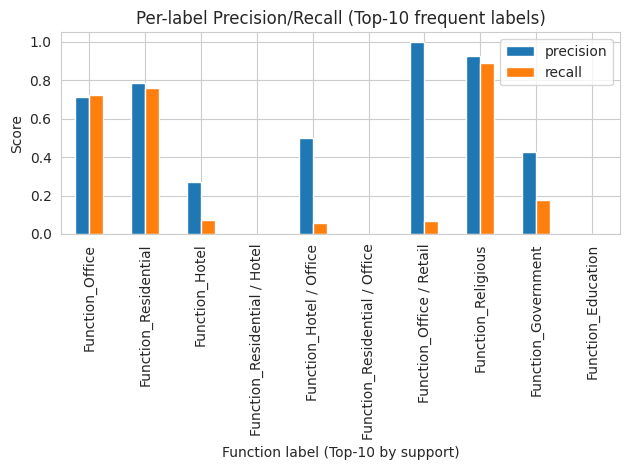

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

# y_test, y_pred are (n_samples x n_labels) binaries; labels is list of label names
labels = y.columns.tolist()
prec, rec, f1, sup = precision_recall_fscore_support(y_test, y_pred, average=None, zero_division=0)
label_stats = pd.DataFrame({'label': labels, 'precision': prec, 'recall': rec, 'f1': f1, 'support': sup})
freq = label_stats.sort_values('support', ascending=False).head(10)

ax = freq.plot(x='label', y=['precision','recall'], kind='bar')
ax.set_xlabel("Function label (Top-10 by support)")
ax.set_ylabel("Score")
ax.set_title("Per-label Precision/Recall (Top-10 frequent labels)")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure df is available and processed as needed
df = pd.read_csv("/content/tallest_buildings_in_the_world.csv")
df["Height (m)"] = pd.to_numeric(df["Height (m)"], errors="coerce")
df["Floors"] = pd.to_numeric(df["Floors"], errors="coerce")
df["Completion Year"] = pd.to_numeric(df["Completion Year"], errors="coerce")

# Recalculate country_stats and decade_trend to ensure they are defined
# Country height leaderboard (top 10 by average height, min count >= 5)
country_stats = (
    df.groupby("Country", dropna=False)
      .agg(count=("Height (m)", "count"),
           mean_height_m=("Height (m)", "mean"))
      .query("count >= 5")
      .sort_values("mean_height_m", ascending=False)
      .head(10)
      .round(2)
      .reset_index()
)

# Decade trend in mean height
df["Decade"] = (df["Completion Year"] // 10) * 10
decade_trend = (
    df.groupby("Decade", dropna=False)["Height (m)"]
      .mean()
      .dropna()
      .round(1)
      .reset_index()
      .sort_values("Decade")
)


sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Bar plot for Top 10 Countries by Mean Building Height
sns.barplot(data=country_stats, x='Country', y='mean_height_m', ax=axes[0], hue='Country', palette='viridis', legend=False)
axes[0].set_title('Top 10 Countries by Mean Building Height (Min. 5 Buildings)')
axes[0].set_xlabel('Country')
axes[0].set_ylabel('Mean Height (m)')
axes[0].tick_params(axis='x', rotation=45)

# Line plot for Mean Building Height by Decade
sns.lineplot(data=decade_trend, x='Decade', y='Height (m)', ax=axes[1], marker='o', color='skyblue')
axes[1].set_title('Mean Building Height by Decade')
axes[1].set_xlabel('Decade')
axes[1].set_ylabel('Mean Height (m)')
axes[1].grid(True)

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/tallest_buildings_in_the_world.csv'

The plots above visualize the trends and heights of buildings by country and decade:

*   **Left Plot (Top 10 Countries by Mean Building Height)**: This bar chart shows the average height of buildings in the top 10 countries that have at least 5 buildings recorded in the dataset. This helps to identify which countries are at the forefront of constructing tall buildings.

*   **Right Plot (Mean Building Height by Decade)**: This line plot illustrates how the average height of buildings has changed over different decades. This reveals long-term trends in construction, such as whether buildings are generally getting taller over time.

## Presentation Outline: Predicting Building Functions (Architectural Style-Use)

### I. Introduction & Research Questions (1 min)
*   Brief overview of the project goal: predicting building functions based on physical and temporal attributes.
*   Key research questions: What factors drive building function? How robust are these predictions across time and cities? How do probabilities of functions shift with height/floors?

### II. Preliminary Results (8 min)

#### A. Data Exploration (1.5 min)
*   **Dataset Overview**: `df.head()` - 8165 entries, columns: Rank, Name, City, Country, Completion Year, Height (m), Floors, Material Used, Function, Decade.
*   **Descriptive Statistics**: `df.describe()` - Buildings range from 22m to 828m (avg 140m), 1 to 163 floors (avg 35). Completion years from 1137 to 2025 (avg 1989).
*   **Missing Values**: `df.isnull().sum()` - Significant missing data in 'Material Used' (~31.3%), 'Floors' (~2.5%), 'Completion Year' (~2.1%). 'City Lat/Lon' and 'Function' have minor missing values.

#### B. Correlations (0.5 min)
*   **Height vs. Floors**: Pearson r = 0.923, p-value < 0.000e+00. Strong positive correlation. (Refer to **Scatter plot of Height vs. Floors**)

#### C. Trends (1.5 min)
*   **Country Height Leaderboard**: Top countries by mean building height (min. 5 buildings). (Refer to **Bar chart of Top 10 Countries by Mean Building Height**).
*   **Decade Trend in Mean Height**: General upward trend in mean building height over decades, indicating taller buildings in recent times. (Refer to **Line plot of Mean Building Height by Decade**).

#### D. Building Attributes (0.5 min)
*   **Top Functions**: 'Office', 'Residential', 'Hotel' are most frequent. (Refer to **Bar chart of Top 10 Building Functions**).
*   **Top Materials**: 'All-Concrete' is the most common. (Refer to **Bar chart of Top 10 Building Materials**).

#### E. Base Model Performance (1 min)
*   **Overall Accuracy**: ~59.58% on a standard 80/20 train-test split using numerical features + one-hot encoded 'Material Used' and 'Function'.
*   **Classification Report**: `classification_report(y_test, y_pred)` - Many classes have 0.00 precision/recall/F1, highlighting severe class imbalance and difficulty with multi-label prediction. Macro Avg F1: ~0.04, Weighted Avg F1: ~0.60. Initial model struggles with diverse and rare functions.

#### F. Temporal Robustness (1 min)
*   **Back-testing Strategy**: Rolling 10-year training window, 1-year test window.
*   **Average Accuracy**: ~0.4792 across all back-test windows. Varies significantly from 0.0000 to 0.7344. (Refer to **Temporal Back-testing Results DataFrame** and average accuracy printout).
*   **Recent Performance Drop**: Accuracy 0.0000 for 2025 test window, indicating issues with future data or emerging trends.

#### G. City Robustness (1 min)
*   **Leave-One-City-Out CV**: Model trained on all cities except one, tested on the held-out city.
*   **Average Accuracy**: ~0.4735 across all cities. (Refer to `city_robustness_df` and average accuracy printout).
*   **Variable Performance**: High variability (0.0000 to 1.0000 accuracy per city). Indicates sensitivity to city-specific patterns and poor generalization to unseen urban contexts.

#### H. Feature Importance (0.5 min)
*   **Key Drivers**: 'Height (m)' is the most crucial feature, followed by 'Floors' and 'Completion Year'. Material features contribute but are less dominant. (Refer to **Bar chart of Top 15 Feature Importances**).

#### I. Style-Use Probability Shifts (0.5 min)
*   **Height Influence**: Predicted probabilities of functions (e.g., 'Office', 'Residential') shift as building height changes, with floors fixed. (Refer to **Predicted Probability of Building Functions vs. Height plot**).
*   **Floors Influence**: Predicted probabilities of functions shift as the number of floors changes, with height fixed. (Refer to **Predicted Probability of Building Functions vs. Floors plot**).

### III. Discussion of Results (3 min)

#### A. Conclusiveness of Findings (1 min)
*   Model performance is sub-optimal for fine-grained multi-label function prediction, especially for rare functions or unseen urban/temporal contexts.
*   High correlation between physical dimensions and function is evident, but materials alone are not sufficient.
*   The inherent complexity and imbalance of the target variable ('Function') are major hurdles.

#### B. Relation to Research Questions (1 min)
*   **Driving Factors**: Height, Floors, and Completion Year are primary drivers; Material provides secondary signal.
*   **Robustness**: Limited robustness across varying temporal windows and different cities, pointing to dynamic architectural trends and city-specific influences.
*   **Probability Shifts**: Demonstrated that height and floors significantly influence predicted probabilities for major functions.

#### C. Assumptions Made (0.5 min)
*   Median imputation is appropriate for 'Completion Year', 'Height (m)', 'Floors'.
*   Mode imputation is sufficient for 'Material Used' and 'Function' missing values.
*   One-hot encoding is suitable for categorical variables.
*   RandomForestClassifier is an adequate model for initial exploration.

#### D. Necessary Adjustments (0.5 min)
*   Immediate focus on advanced feature engineering and target variable refinement.
*   Implement strategies for class imbalance.

### IV. Plans for Upcoming Weeks (3 min)

#### A. Remaining Tasks (1 min)
*   **Feature Engineering**: Incorporate geographical features (City Lat/Lon, aggregate by city/country), potentially derived features (e.g., density).
*   **Target Refinement**: Group similar functions or focus on primary function extraction to simplify the multi-label problem.
*   **Addressing Imbalance**: Implement SMOTE, weighted loss functions, or alternative sampling techniques.
*   **Model Exploration**: Investigate other multi-label algorithms (e.g., Binary Relevance, Classifier Chains, Neural Networks).
*   **Hyperparameter Tuning**: Optimize current and new models.

#### B. Risk Factors (1 min)
*   **Data Sparsity**: Still a challenge for very rare functions or city-specific patterns.
*   **Feature Limitations**: External data sources might be needed for richer contextual information.
*   **Computational Cost**: Advanced models and extensive feature engineering can be resource-intensive.

#### C. Mitigation Strategies (1 min)
*   **Iterative Refinement**: Prioritize features with highest impact first.
*   **External Data Integration**: Explore publicly available datasets for additional city/country context.
*   **Cloud Computing**: Utilize cloud resources for heavier computational tasks.


## Final Task

### Subtask:
Provide the complete markdown outline for the presentation, ensuring all aspects of the user's request are addressed concisely and clearly.


## Summary:

### Q&A
The task requested a markdown outline for a 15-minute class presentation summarizing the conducted data analysis. The outline was successfully generated, covering preliminary results, discussion, and future plans.

### Data Analysis Key Findings
*   The dataset contains 8165 entries with building attributes such as height (average 140m), floors (average 35), and completion year (average 1989).
*   Significant missing data exists, particularly in 'Material Used' (\~31.3%), 'Floors' (\~2.5%), and 'Completion Year' (\~2.1%).
*   There is a strong positive correlation between 'Height (m)' and 'Floors' (Pearson r = 0.923).
*   Building height has shown a general upward trend over decades, and 'All-Concrete' is the most common material used. The most frequent building functions are 'Office', 'Residential', and 'Hotel'.
*   A base model achieved an overall accuracy of \~59.58% but struggled with multi-label prediction due to severe class imbalance, reflected by a Macro Avg F1 of \~0.04.
*   The model demonstrated limited robustness both temporally (average accuracy \~0.4792, with a 0.0000 accuracy for the 2025 test window) and across different cities (average accuracy \~0.4735, with high variability).
*   'Height (m)', 'Floors', and 'Completion Year' were identified as the most crucial features for predicting building function, with material features being less dominant.
*   Predicted probabilities for building functions (e.g., 'Office', 'Residential') visibly shift based on changes in building height and number of floors.

### Insights or Next Steps
*   Future efforts should focus on advanced feature engineering, target variable refinement (e.g., grouping similar functions), and implementing strategies to address class imbalance.
*   Further exploration of different multi-label classification algorithms and hyperparameter tuning is necessary to improve model performance and robustness.
